Link: https://zenodo.org/records/10784947

In [1]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import csv, re, math, gc, os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from scipy.stats import ks_2samp
from pathlib import Path
from tqdm import tqdm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.dates as mdates
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


from datetime import datetime
base_path = Path("./dragon_pi")

--- Aggregated Data Volume per Category (%) ---
bruteforce    52.34
norm          16.74
ctfs          16.02
portscan      13.36
dos            1.54
Name: Data Percentage (%), dtype: float64

--- Generating Plots ---


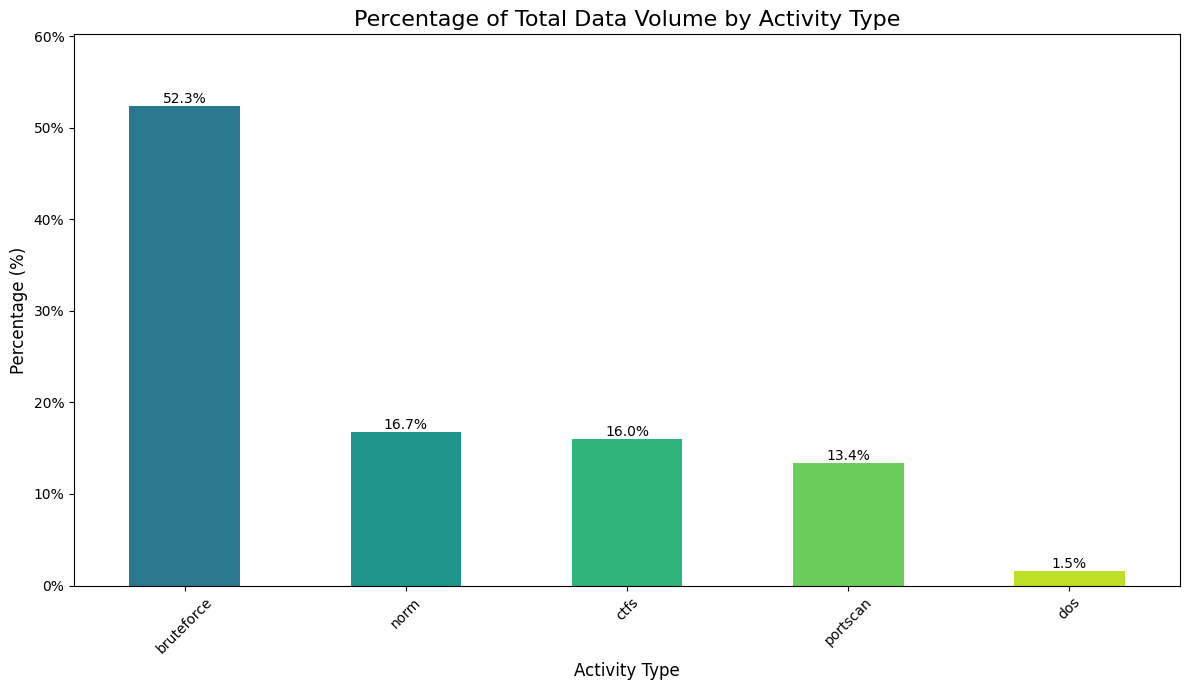

In [ ]:
data_structure_text = """
📁 dragon
  📂 dragon_bruteforce_large
  └── subtotal dragon_bruteforce_large: 26.49 GB
  📂 dragon_ctfs_large
  └── subtotal dragon_ctfs_large: 2.55 GB
  📂 dragon_dos_large
  └── subtotal dragon_dos_large: 497.97 MB
  📂 dragon_norm_large
  └── subtotal dragon_norm_large: 7.49 GB
  📂 dragon_portscan_large
  └── subtotal dragon_portscan_large: 3.33 GB
└── TOTAL dragon: 40.34 GB
📁 pi
  📂 pi_bruteforce_large
  └── subtotal pi_bruteforce_large: 7.19 GB
  📂 pi_ctfs_large
  └── subtotal pi_ctfs_large: 7.76 GB
  📂 pi_dos_large
  └── subtotal pi_dos_large: 517.43 MB
  📂 pi_norm_large
  └── subtotal pi_norm_large: 3.28 GB
  📂 pi_portscan_large
  └── subtotal pi_portscan_large: 5.27 GB
└── TOTAL pi: 24.00 GB
"""

attack_data = {}
pattern = re.compile(r"subtotal\s+\w+_(\w+)_large:\s+([\d.]+)\s+(GB|MB)")

for line in data_structure_text.strip().split('\n'):
    match = pattern.search(line)
    if match:
        category, size, unit = match.groups()
        size = float(size)
        if unit == 'MB':
            size /= 1024 
        attack_data[category] = attack_data.get(category, 0) + size

data_distribution_gb = pd.Series(attack_data)

data_percentage = (data_distribution_gb / data_distribution_gb.sum() * 100).sort_values(ascending=False)
data_percentage.name = 'Data Percentage (%)'

print("--- Aggregated Data Volume per Category (%) ---")
print(data_percentage.round(2))


print("\n--- Generating Plots ---")

fig, ax = plt.subplots(figsize=(12, 7))
data_percentage.plot.bar(ax=ax, color=plt.cm.viridis(np.linspace(0.4, 0.9, len(data_percentage))))
ax.set_title('Percentage of Total Data Volume by Activity Type', fontsize=16)
ax.set_ylabel('Percentage (%)', fontsize=12) 
ax.set_xlabel('Activity Type', fontsize=12)
ax.tick_params(axis='x', rotation=45)

ax.yaxis.set_major_formatter(mtick.PercentFormatter())

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')

ax.set_ylim(0, max(data_percentage) * 1.15)
plt.tight_layout()
plt.show()

# ============================================================
# PI_BRUTEFORCE_LARGE
# ============================================================



--- SSH Brute Force (GB) ---
dragon_bruteforce_large    26.49
pi_bruteforce_large         7.19

--- Quantidade de arquivos ---
dragon_bruteforce_large    33
pi_bruteforce_large         8

--- Tabela IKE/CKE (GB) - varredura filesystem ---
                            ike     cke
dragon_bruteforce_large  12.068  13.564
pi_bruteforce_large       3.580   3.609

--- Distribuição IKE/CKE (nº arquivos) ---
                         IKE  CKE
Device                           
dragon_bruteforce_large   15   18
pi_bruteforce_large        4    4


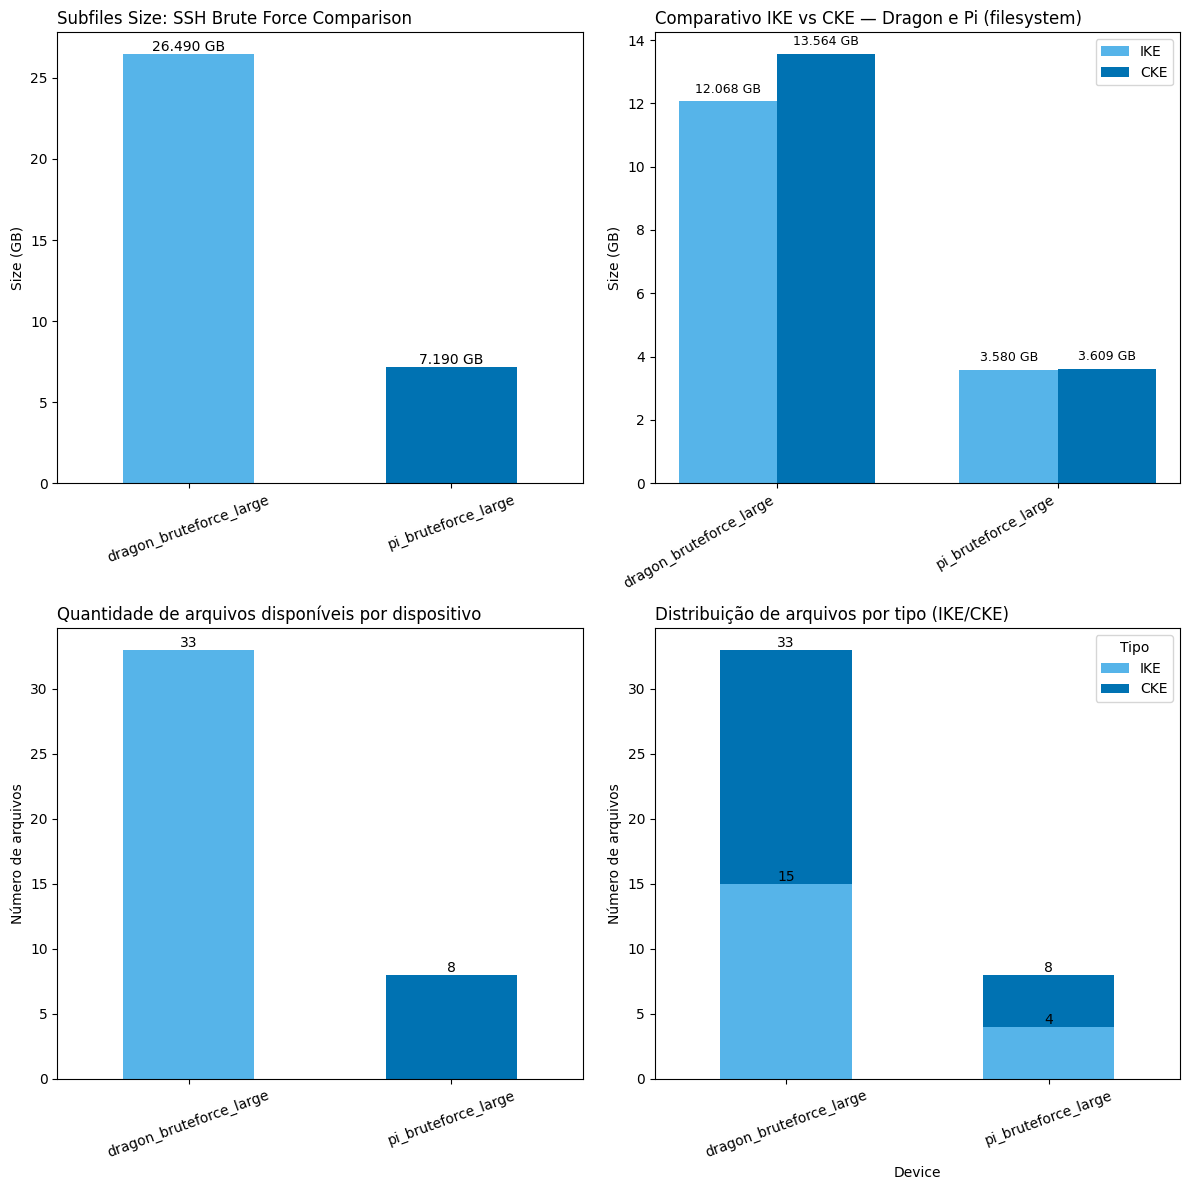

In [ ]:
data_structure_text = """
📁 dragon
  📂 dragon_bruteforce_large
  └── subtotal dragon_bruteforce_large: 26.49 GB
📁 pi
  📂 pi_bruteforce_large
  └── subtotal pi_bruteforce_large: 7.19 GB
"""

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
ax00 = axes[0, 0]  # SSH Brute Force
ax01 = axes[0, 1]  # Comparativo IKE vs CKE (dinâmico via filesystem)
ax10 = axes[1, 0]  # Quantidade de arquivos disponíveis por dispositivo
ax11 = axes[1, 1]  # Distribuição IKE/CKE (stacked)

# --- 1. Comparativo SSH Brute Force (dragon_bruteforce_large | pi_bruteforce_large) ---
pattern_bf = re.compile(r"subtotal\s+(dragon_bruteforce_large|pi_bruteforce_large):\s+([\d.]+)\s+(GB|MB)", re.IGNORECASE)
sizes_bf = {}
for line in data_structure_text.splitlines():
    m = pattern_bf.search(line)
    if m:
        name, size_str, unit = m.groups()
        size = float(size_str)
        if unit.upper() == "MB":
            size = size / 1024.0
        sizes_bf[name] = size

if sizes_bf:
    df2 = pd.Series(sizes_bf, name="Size (GB)")
    print("\n--- SSH Brute Force (GB) ---")
    print(df2.round(3).to_string())
    df2.plot(kind="bar", ax=ax00, color=["#56B4E9", "#0072B2"])
    ax00.set_title("Subfiles Size: SSH Brute Force Comparison", loc="left")
    ax00.set_ylabel("Size (GB)")
    ax00.tick_params(axis="x", rotation=20)
    for c in ax00.containers:
        ax00.bar_label(c, fmt="%.3f GB")
else:
    ax00.text(0.5, 0.5, "No data to plot", ha="center", va="center", fontsize=12)
    ax00.set_title("Subfiles Size: SSH Brute Force Comparison", loc="left")

# --- 2. Quantidade de arquivos disponíveis por dispositivo (usar ax10, não criar nova figura) ---
counts = pd.Series({"dragon_bruteforce_large": 33, "pi_bruteforce_large": 8})
print("\n--- Quantidade de arquivos ---")
print(counts.to_string())

counts.plot(kind="bar", color=["#56B4E9", "#0072B2"], ax=ax10)
ax10.set_title("Quantidade de arquivos disponíveis por dispositivo", loc="left")
ax10.set_ylabel("Número de arquivos")
ax10.tick_params(axis='x', rotation=20)
for c in ax10.containers:
    ax10.bar_label(c)

# --- 3. Comparativo IKE vs CKE — Dragon e Pi (dinâmico via varredura do filesystem) ---
BASE_DIR = Path("./dragon_pi").expanduser()
EXCLUDE_SUBSTR = "_legend"
TYPE_KEYS = ["ike", "cke"]
DEVICE_KEYS = ["dragon", "pi"]

entries = []
if BASE_DIR.exists():
    for bruteforce_dir in BASE_DIR.rglob("*bruteforce*"):
        if not bruteforce_dir.is_dir():
            continue
        for f in bruteforce_dir.rglob("*"):
            if not f.is_file():
                continue
            if EXCLUDE_SUBSTR in f.stem.lower():
                continue
            try:
                entries.append((f.name, f.stat().st_size / (1024**3)))
            except OSError:
                pass

acc = {dev: {t: 0.0 for t in TYPE_KEYS} for dev in DEVICE_KEYS}
for name, size in entries:
    n = name.lower()
    device = None
    for d in DEVICE_KEYS:
        if d in n:
            device = d
            break
    if device is None:
        device = "pi" if n.startswith("pi_") else ("dragon" if "dragon" in n else None)
    if device not in DEVICE_KEYS:
        continue
    typ = None
    for t in TYPE_KEYS:
        if f"_{t}" in n or n.endswith(f"_{t}") or f"_{t}." in n:
            typ = t
            break
    if typ is None:
        for t in TYPE_KEYS:
            if t in n:
                typ = t
                break
    if typ is None:
        continue
    acc[device][typ] += size

df_acc = pd.DataFrame(acc).T[TYPE_KEYS] if any(acc[d][t] for d in acc for t in acc[d]) else pd.DataFrame()
if not df_acc.empty:
    folder_names = {"dragon": "dragon_bruteforce_large", "pi": "pi_bruteforce_large"}
    df_acc.index = [folder_names.get(i, i) for i in df_acc.index]
    print("\n--- Tabela IKE/CKE (GB) - varredura filesystem ---")
    print(df_acc.round(3).to_string())

    labels = df_acc.index.tolist()
    x = np.arange(len(labels))
    width = 0.35
    bars1 = ax01.bar(x - width/2, df_acc["ike"], width, label="IKE", color="#56B4E9")
    bars2 = ax01.bar(x + width/2, df_acc["cke"], width, label="CKE", color="#0072B2")

    ax01.set_ylabel("Size (GB)")
    ax01.set_title("Comparativo IKE vs CKE — Dragon e Pi (filesystem)", loc="left")
    ax01.set_xticks(x)
    ax01.set_xticklabels(labels, rotation=30, ha="right")
    ax01.legend()

    for b in list(bars1) + list(bars2):
        h = b.get_height()
        ax01.annotate(f"{h:.3f} GB",
                      xy=(b.get_x() + b.get_width() / 2, h),
                      xytext=(0, 4), textcoords="offset points",
                      ha="center", va="bottom", fontsize=9)
else:
    print("\n--- Tabela IKE/CKE (GB) - varredura filesystem ---\n<sem dados>")
    ax01.text(0.5, 0.5, "No data to plot", ha="center", va="center", fontsize=12)
    ax01.set_title("Comparativo IKE vs CKE — Dragon e Pi (filesystem)", loc="left")

# --- 4. Distribuição IKE/CKE (stacked) - exemplo estático (troque pelos seus valores se quiser) ---
df3 = pd.DataFrame({
    "Device": ["dragon_bruteforce_large", "pi_bruteforce_large"],
    "IKE": [15, 4],
    "CKE": [18, 4]
}).set_index("Device")
print("\n--- Distribuição IKE/CKE (nº arquivos) ---")
print(df3.to_string())
df3.plot(kind="bar", stacked=True, color=["#56B4E9", "#0072B2"], ax=ax11)
ax11.set_title("Distribuição de arquivos por tipo (IKE/CKE)", loc="left")
ax11.set_ylabel("Número de arquivos")
ax11.tick_params(axis="x", rotation=20)
ax11.legend(title="Tipo")
for c in ax11.containers:
    ax11.bar_label(c)

plt.tight_layout()
plt.show()


In [9]:
PI_BRUTEFORCE_PATH = Path("dragon_pi/pi/pi_bruteforce_large")

results = []

for csv_file in sorted(PI_BRUTEFORCE_PATH.glob("*.csv")):
    if "_legend" in csv_file.name.lower():
        continue

    try:
        df = pd.read_csv(csv_file)
        if "Time" not in df.columns:
            continue

        start = pd.to_timedelta(df["Time"].min(), unit="s")
        end = pd.to_timedelta(df["Time"].max(), unit="s")
        duration = (end - start)

        results.append({
            "Arquivo": csv_file.name,
            "Tamanho (MB)": round(csv_file.stat().st_size / (1024 ** 2), 2),
            "Início": str(start),
            "Fim": str(end),
            "Duração (h)": round(duration.total_seconds() / 3600, 2)
        })
    except Exception as e:
        print(f"Erro ao processar {csv_file.name}: {e}")

df_summary = pd.DataFrame(results)
print(df_summary)


                Arquivo  Tamanho (MB)           Início  \
0  pi_hydra_t16_cke.csv        935.97  0 days 00:00:00   
1  pi_hydra_t16_ike.csv        929.52  0 days 00:00:00   
2   pi_hydra_t1_cke.csv        936.42  0 days 00:00:00   
3   pi_hydra_t1_ike.csv        917.36  0 days 00:00:00   
4  pi_hydra_t32_cke.csv        921.32  0 days 00:00:00   
5  pi_hydra_t32_ike.csv        914.50  0 days 00:00:00   
6   pi_hydra_t4_cke.csv        902.02  0 days 00:00:00   
7   pi_hydra_t4_ike.csv        904.46  0 days 00:00:00   

                         Fim  Duração (h)  
0  0 days 00:04:59.999989760         0.08  
1  0 days 00:04:59.999989760         0.08  
2  0 days 00:04:59.999989760         0.08  
3  0 days 00:04:59.999989760         0.08  
4  0 days 00:04:59.999989760         0.08  
5  0 days 00:04:59.999989760         0.08  
6  0 days 00:04:59.999989760         0.08  
7  0 days 00:04:59.999989760         0.08  


In [12]:
def rms(x: pd.Series) -> float:
    """Calcula o valor RMS (Root Mean Square)."""
    return float(np.sqrt(np.mean(np.square(x)))) if len(x) > 0 else np.nan

def stats_from_series(s: pd.Series) -> dict:
    """Calcula estatísticas básicas sobre uma série de corrente."""
    return {
        "mean_current": float(s.mean()),
        "std_current": float(s.std(ddof=0)),  
        "rms_current": rms(s),
        "max_current": float(s.max()),
        "min_current": float(s.min()),
        "amp_current": float(s.max() - s.min())
    }

all_stats = []

for csv_path in tqdm(sorted(PI_BRUTEFORCE_PATH.glob("*.csv"))):
    if "_legend" in csv_path.name.lower():
        continue

    try:
        df = pd.read_csv(csv_path, usecols=["Time", "Current"])
    except Exception as e:
        print(f"[ERRO] Falha ao ler {csv_path.name}: {e}")
        continue

    s = df["Current"].dropna()
    stats = stats_from_series(s)
    stats["std_current"] = float(np.std(s, ddof=0))  
    stats["source_file"] = csv_path.name
    all_stats.append(stats)

df_all = pd.DataFrame(all_stats)
print(f"Arquivos processados: {len(df_all)}\n")
display(df_all.head(10))


100%|██████████| 16/16 [01:01<00:00,  3.86s/it]

Arquivos processados: 8



mean_current  std_current  rms_current  max_current  min_current  \
0      0.420895     0.207018     0.469051     1.082749     0.248587   
1      0.401068     0.189209     0.443458     0.994235     0.248822   
2      0.318716     0.056188     0.323630     0.769418     0.249129   
3      0.318929     0.052776     0.323266     0.676607     0.250186   
4      0.384427     0.184634     0.426467     1.093517     0.251441   
5      0.383057     0.181687     0.423961     0.987785     0.249755   
6      0.334521     0.128744     0.358440     0.963079     0.251112   
7      0.345079     0.135342     0.370671     1.315644     0.240179   

   amp_current           source_file  
0     0.834162  pi_hydra_t16_cke.csv  
1     0.745413  pi_hydra_t16_ike.csv  
2     0.520289   pi_hydra_t1_cke.csv  
3     0.426421   pi_hydra_t1_ike.csv  
4     0.842075  pi_hydra_t32_cke.csv  
5     0.738029  pi_hydra_t32_ike.csv  
6     0.711967   pi_hydra_t4_cke.csv  
7     1.075466   pi_hydra_t4_ike.csv

Processando pi_hydra_t16_cke.csv...


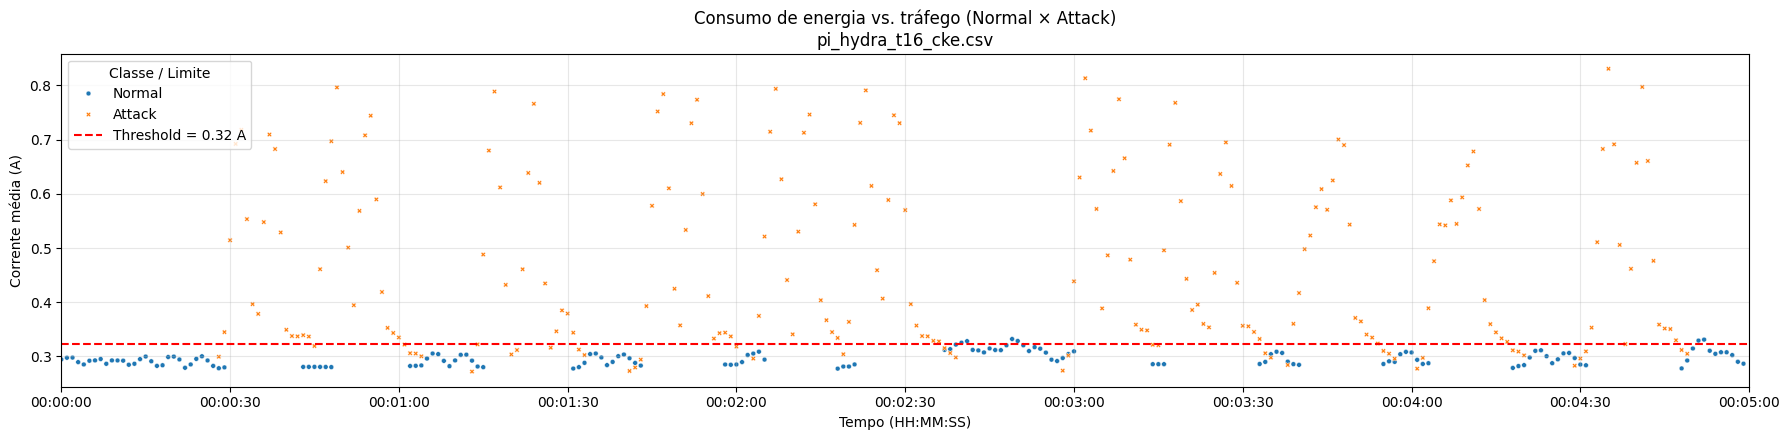

Processando pi_hydra_t16_ike.csv...


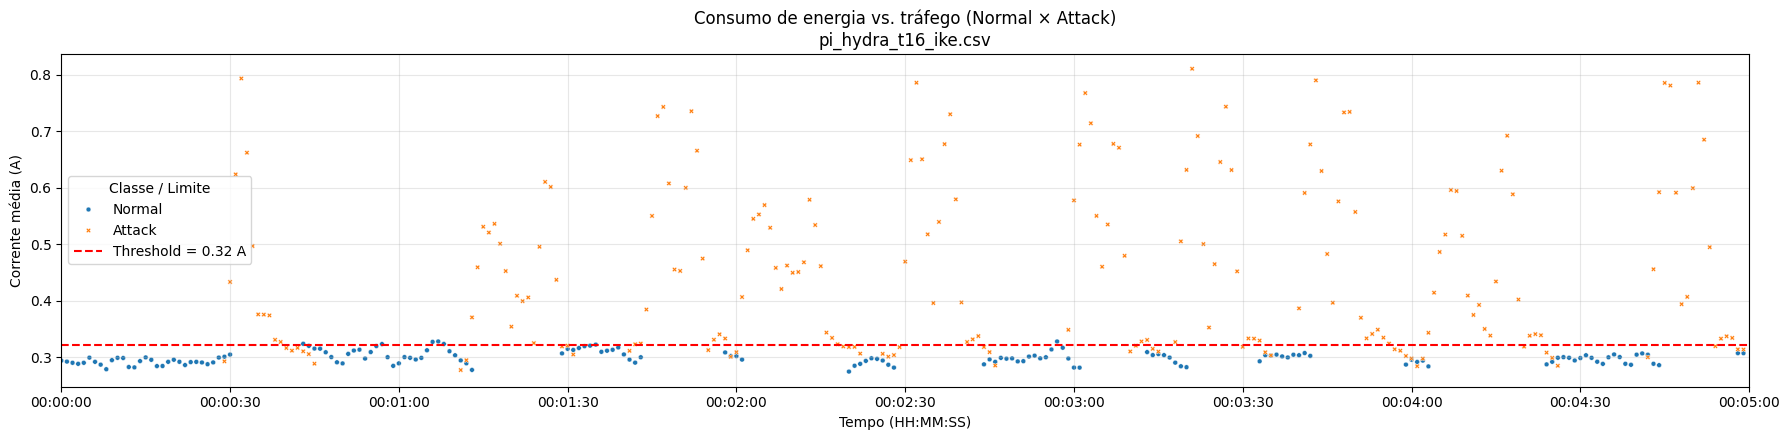

Processando pi_hydra_t1_cke.csv...


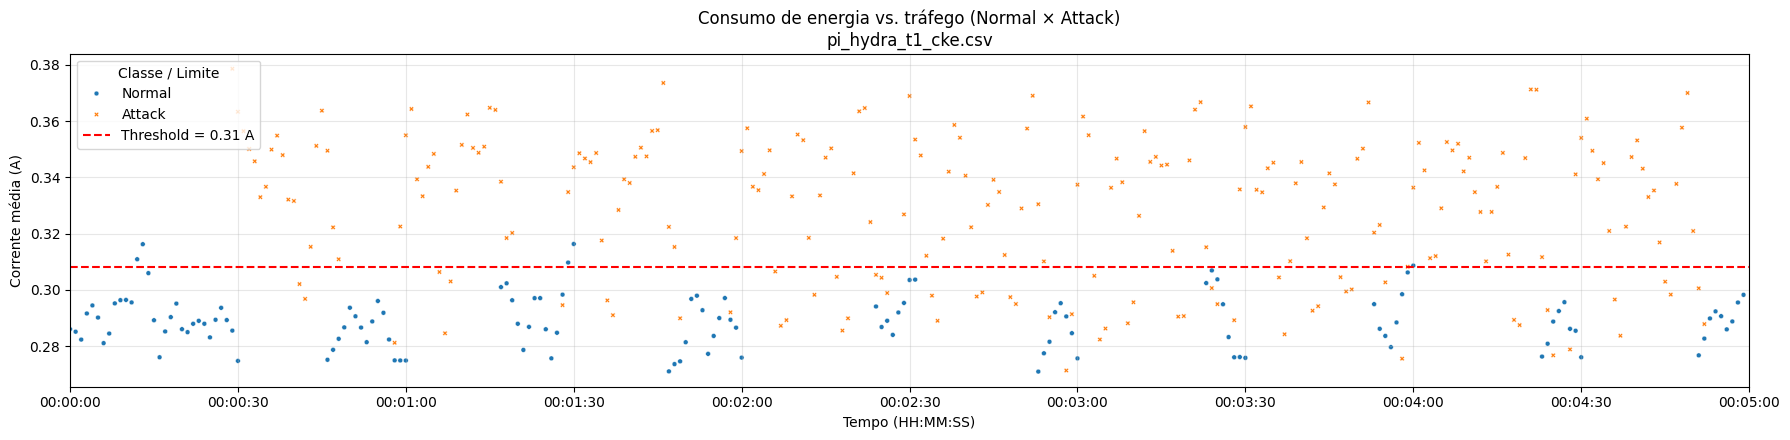

Processando pi_hydra_t1_ike.csv...


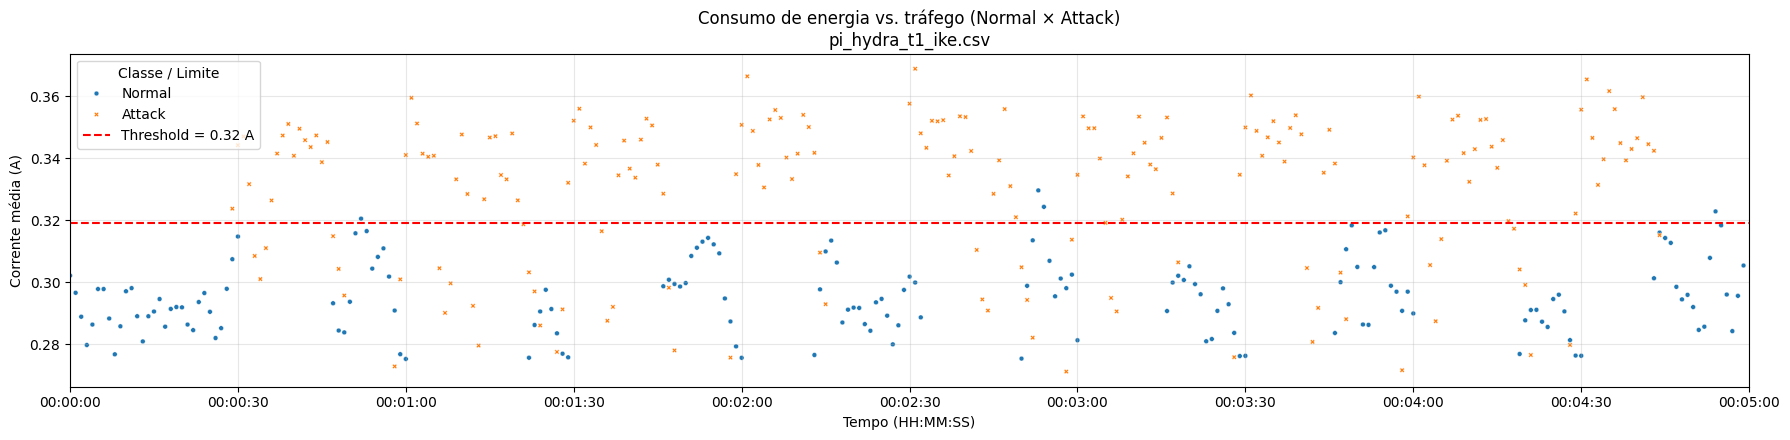

Processando pi_hydra_t32_cke.csv...


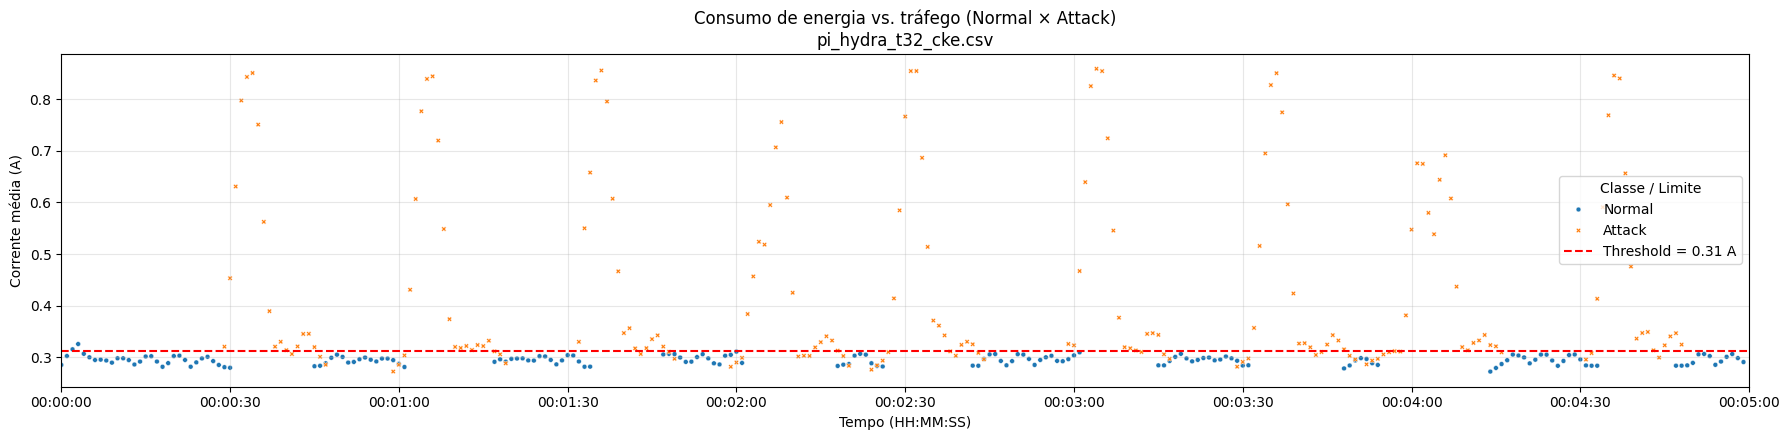

Processando pi_hydra_t32_ike.csv...


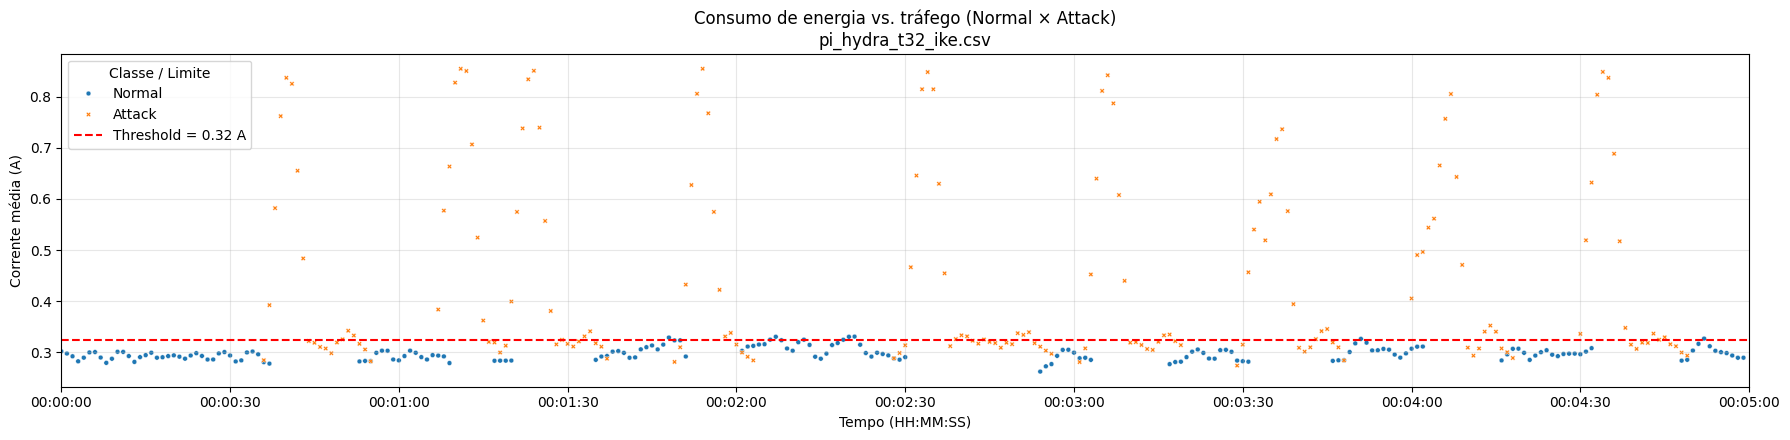

Processando pi_hydra_t4_cke.csv...


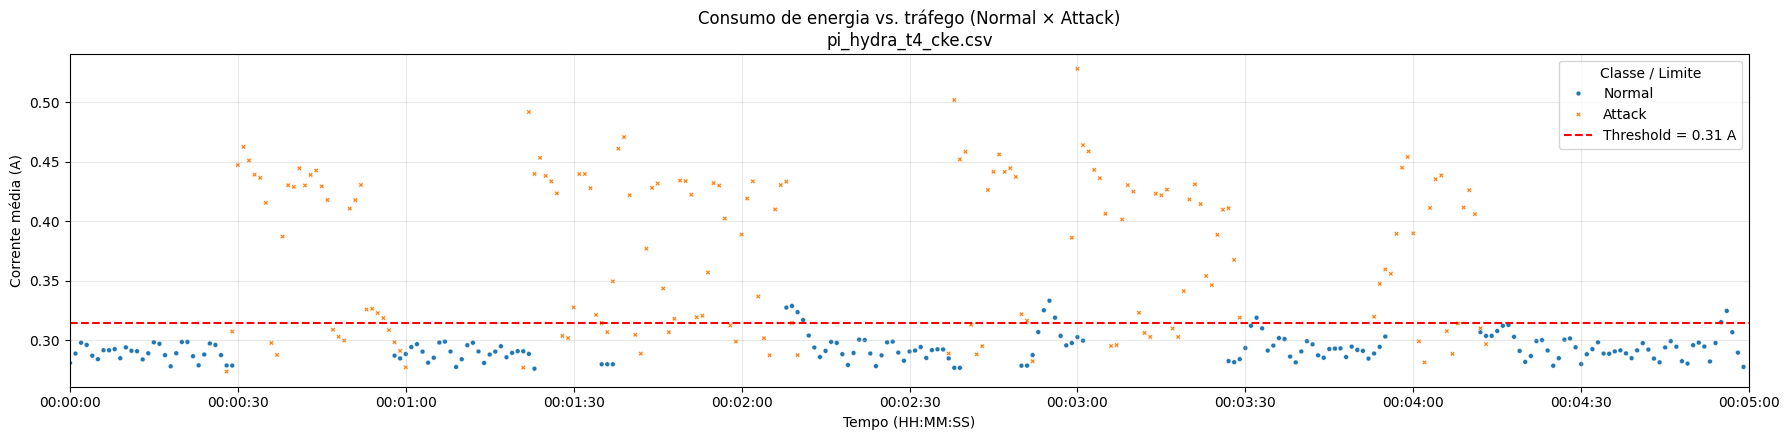

Processando pi_hydra_t4_ike.csv...


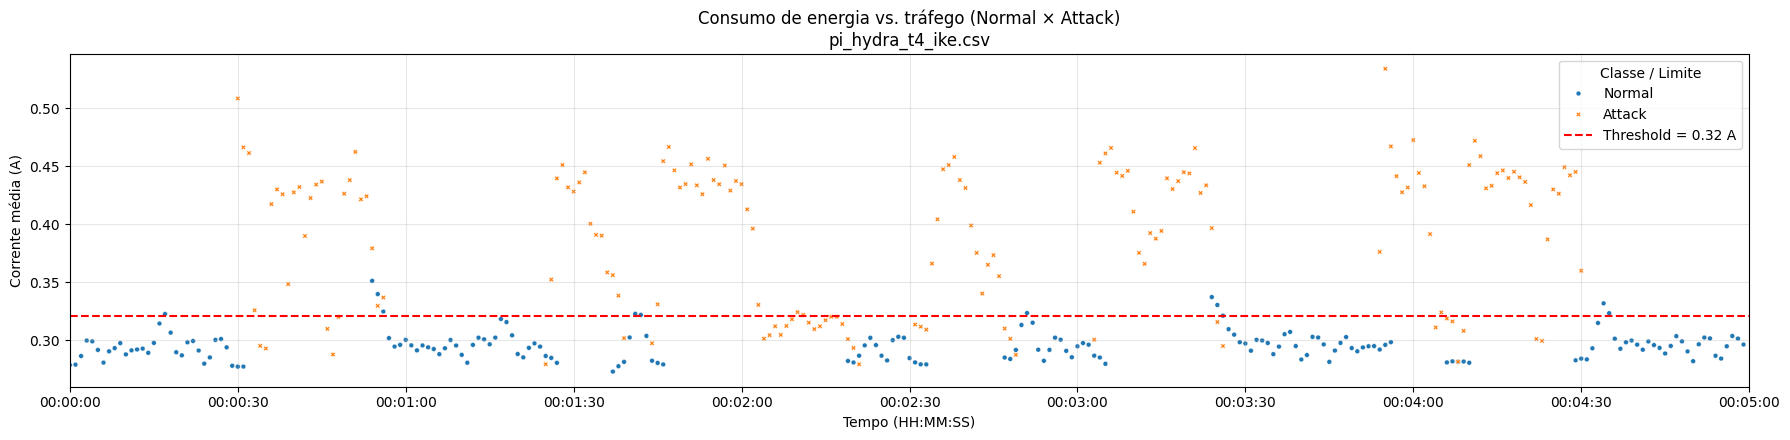

In [46]:
START_DATE = pd.to_datetime("2012-02-29 00:00:00")

for csv_file in sorted(PI_BRUTEFORCE_PATH.glob("*.csv")):
    if "_legend" in csv_file.name.lower():
        continue

    print(f"Processando {csv_file.name}...")

    df = pd.read_csv(csv_file, index_col=0)
    df["Datetime"] = pd.to_timedelta(df["Time"], unit="s") + START_DATE
    df = df.set_index("Datetime")

    for col in ["anno_string", "anno_type", "anno_specific"]:
        if col not in df.columns:
            df[col] = "Normal"

    df["is_attack"] = ~(
        (df["anno_string"].astype(str).str.lower() == "normal")
        & (df["anno_type"].astype(str).str.lower() == "normal")
        & (df["anno_specific"].astype(str).str.lower() == "normal")
    )

    step = "1s"
    df_sec = (
        df[["Current", "is_attack"]]
        .groupby("is_attack")["Current"]
        .resample(step)
        .mean()
        .rename("Corrente (A)")
        .reset_index()
    )

    df_sec["Corrente (A)"] = (
        df_sec.groupby("is_attack")["Corrente (A)"]
        .transform(lambda s: s.rolling(3, min_periods=1, center=True).mean())
    )

    df_sec["classe"] = df_sec["is_attack"].map({False: "Normal", True: "Attack"})

    fig, ax = plt.subplots(figsize=(18, 4.5))
    sns.scatterplot(
        data=df_sec,
        x="Datetime",
        y="Corrente (A)",
        hue="classe",
        style="classe",
        s=12,
        ax=ax
    )

    ax.xaxis.set_major_locator(mdates.SecondLocator(interval=30))     
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))   

    xmin = df.index.min().floor("s")
    xmax = xmin + pd.Timedelta(minutes=5)
    ax.set_xlim(xmin, xmax)

    ax.set_title(f"Consumo de energia vs. tráfego (Normal × Attack)\n{csv_file.name}")
    ax.set_xlabel("Tempo (HH:MM:SS)")
    ax.set_ylabel("Corrente média (A)")
    ax.grid(True, alpha=0.3)
    threshold = df_sec.loc[df_sec["classe"] == "Normal", "Corrente (A)"].mean() \
           + 2 * df_sec.loc[df_sec["classe"] == "Normal", "Corrente (A)"].std()

    ax.axhline(y=threshold, color="red", linestyle="--", label=f"Threshold = {threshold:.2f} A")
    ax.legend(title="Classe / Limite")
    plt.tight_layout()
    plt.show()


Processando pi_hydra_t16_cke.csv...


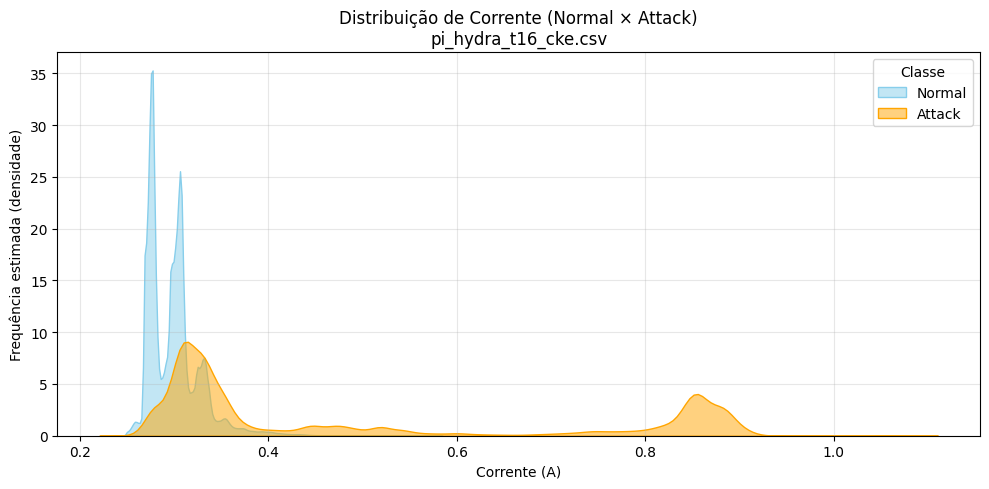

Processando pi_hydra_t16_ike.csv...


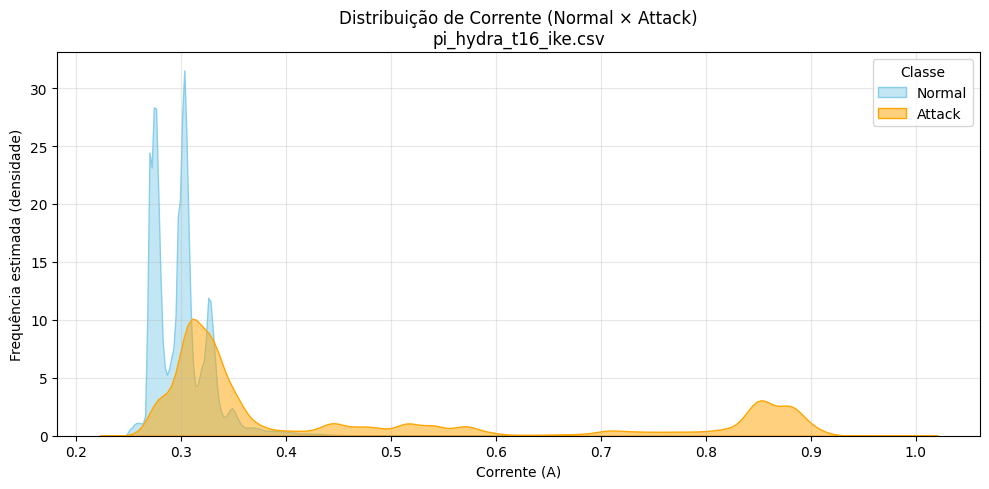

Processando pi_hydra_t1_cke.csv...


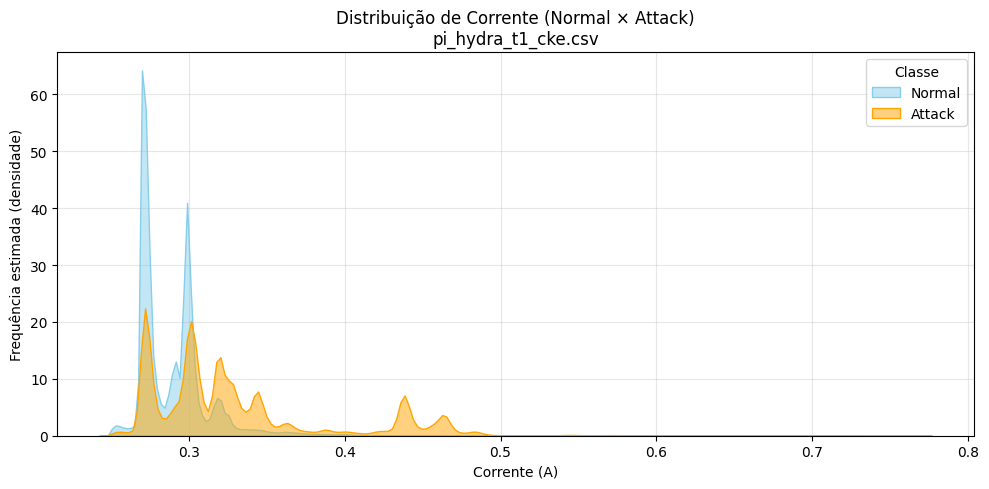

Processando pi_hydra_t1_ike.csv...


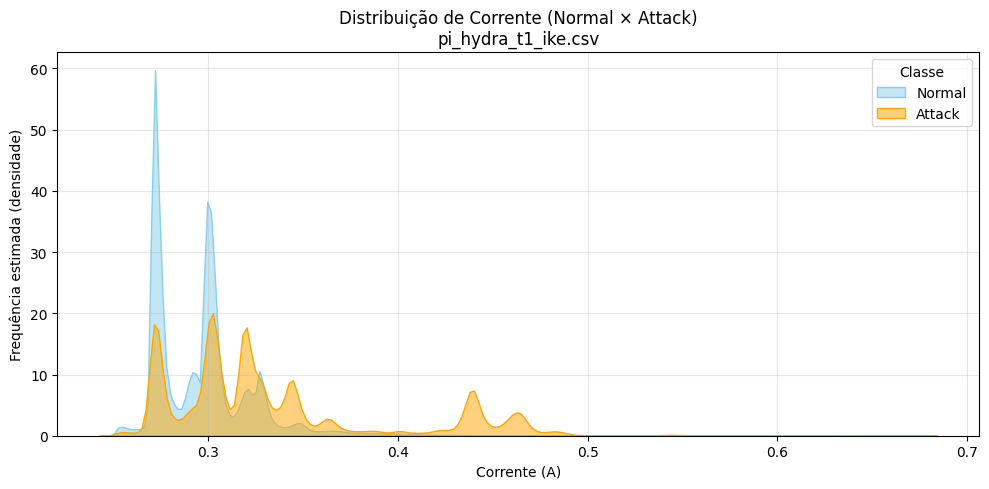

Processando pi_hydra_t32_cke.csv...


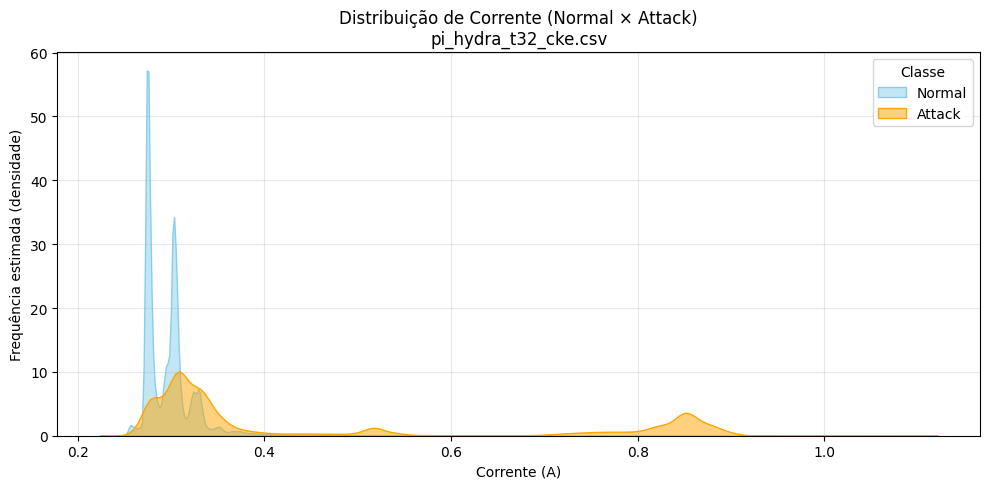

Processando pi_hydra_t32_ike.csv...


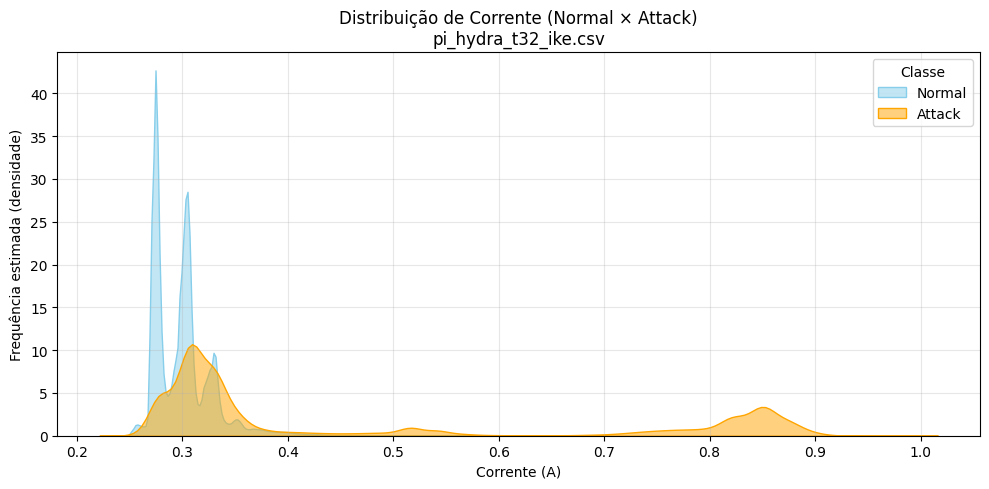

Processando pi_hydra_t4_cke.csv...


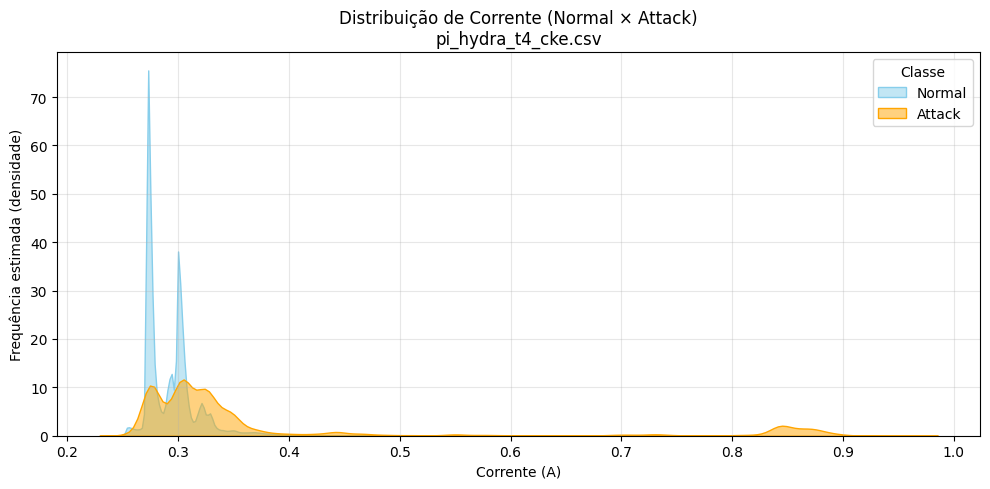

Processando pi_hydra_t4_ike.csv...


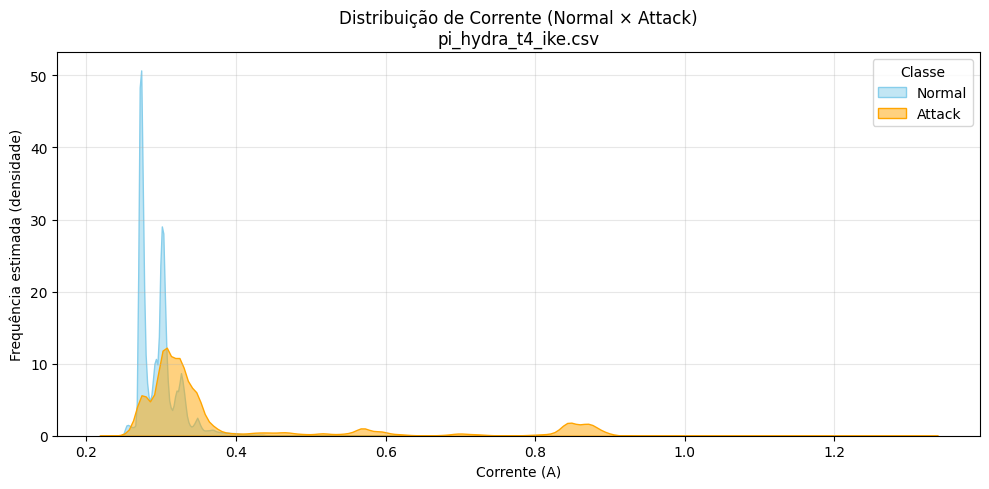

In [50]:
START_DATE = pd.to_datetime("2012-02-29 00:00:00")

for csv_file in sorted(PI_BRUTEFORCE_PATH.glob("*.csv")):
    if "_legend" in csv_file.name.lower():
        continue

    print(f"Processando {csv_file.name}...")

    df = pd.read_csv(csv_file, index_col=0)
    df["Datetime"] = pd.to_timedelta(df["Time"], unit="s") + START_DATE
    df = df.set_index("Datetime")

    for col in ["anno_string", "anno_type", "anno_specific"]:
        if col not in df.columns:
            df[col] = "Normal"

    df["is_attack"] = ~(
        (df["anno_string"].astype(str).str.lower() == "normal")
        & (df["anno_type"].astype(str).str.lower() == "normal")
        & (df["anno_specific"].astype(str).str.lower() == "normal")
    )
    df["classe"] = df["is_attack"].map({False: "Normal", True: "Attack"})

    plt.figure(figsize=(10, 5))
    sns.kdeplot(
        data=df[df["classe"] == "Normal"],
        x="Current",
        fill=True, color="skyblue", alpha=0.5, label="Normal"
    )
    sns.kdeplot(
        data=df[df["classe"] == "Attack"],
        x="Current",
        fill=True, color="orange", alpha=0.5, label="Attack"
    )

    plt.title(f"Distribuição de Corrente (Normal × Attack)\n{csv_file.name}")
    plt.xlabel("Corrente (A)")
    plt.ylabel("Frequência estimada (densidade)")
    plt.legend(title="Classe")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


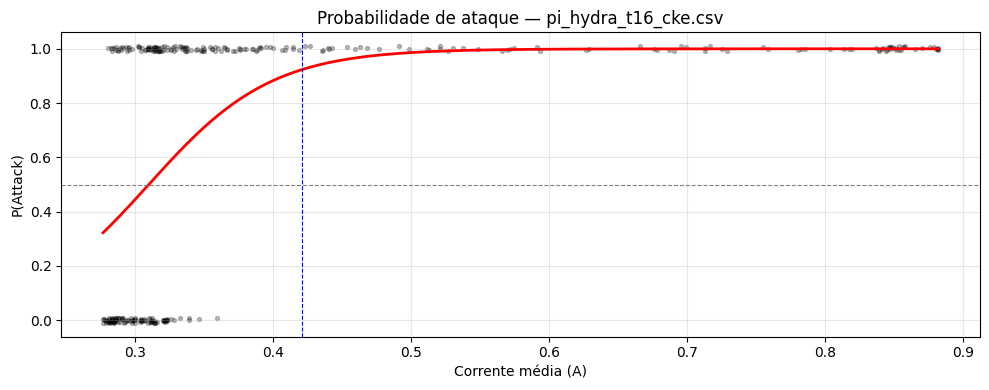

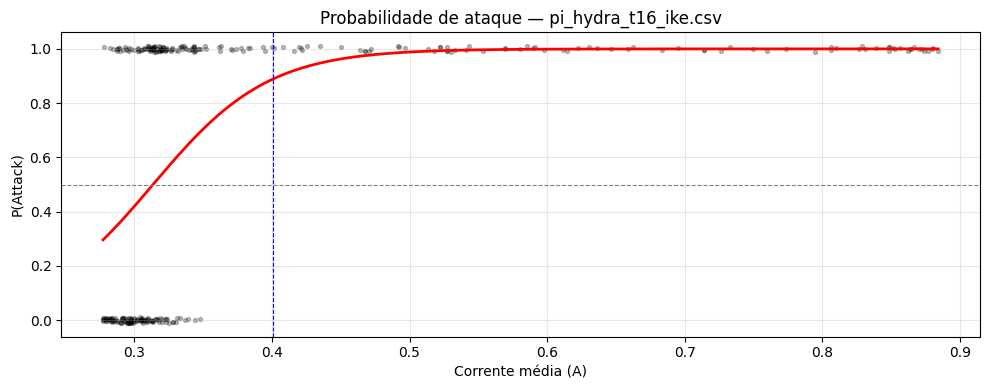

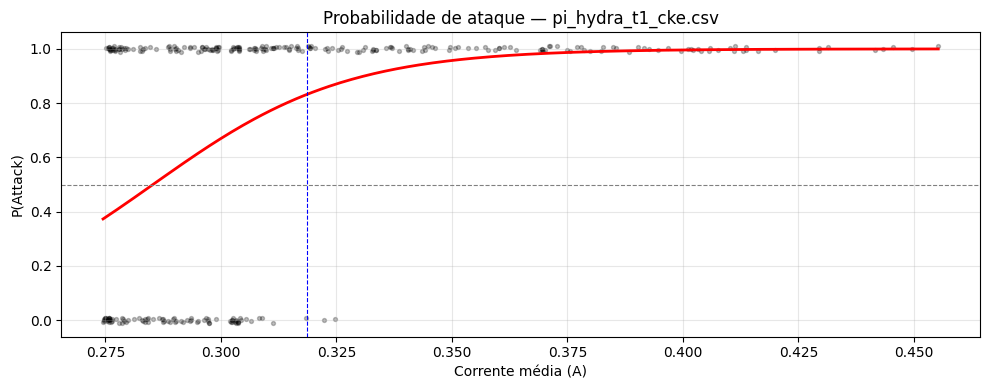

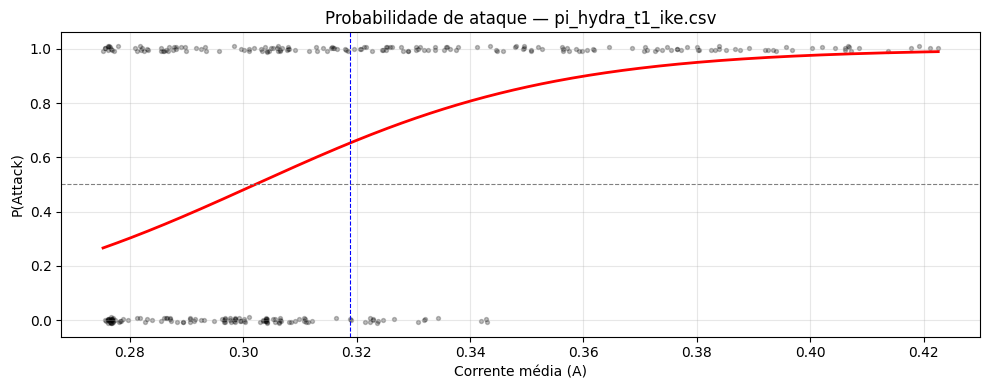

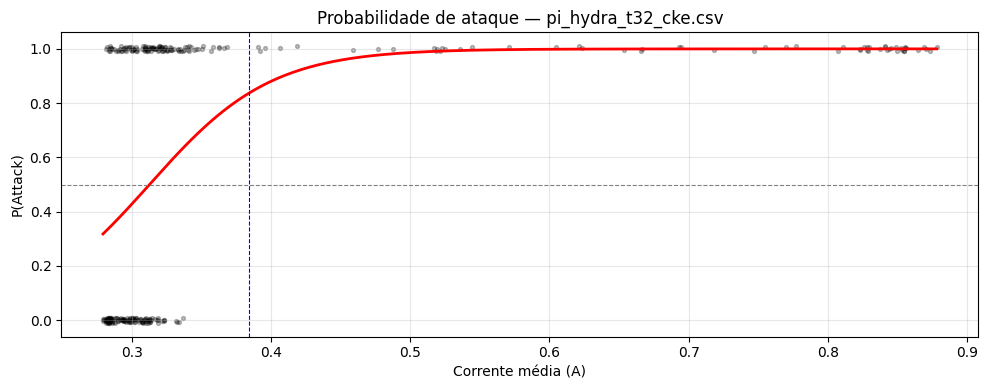

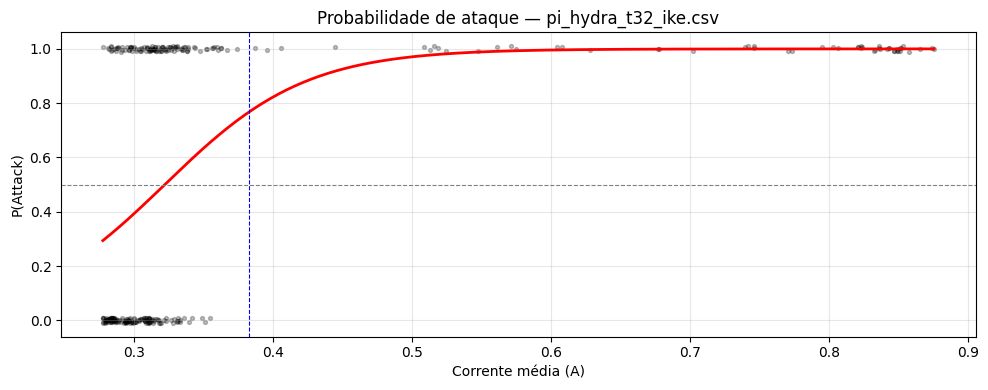

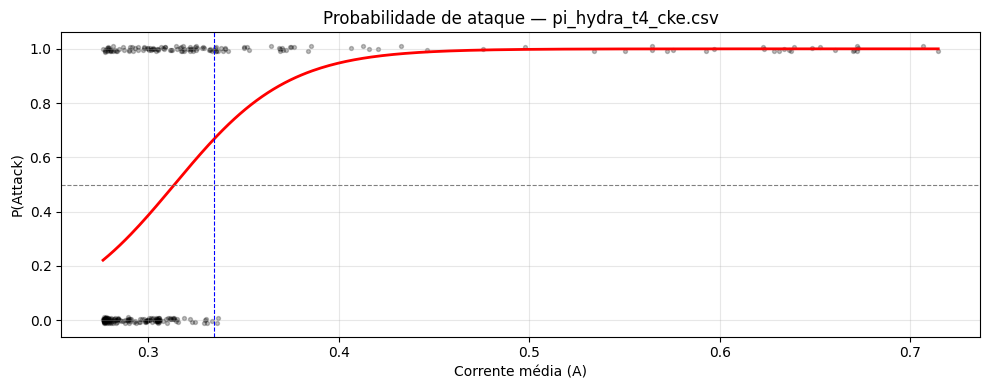

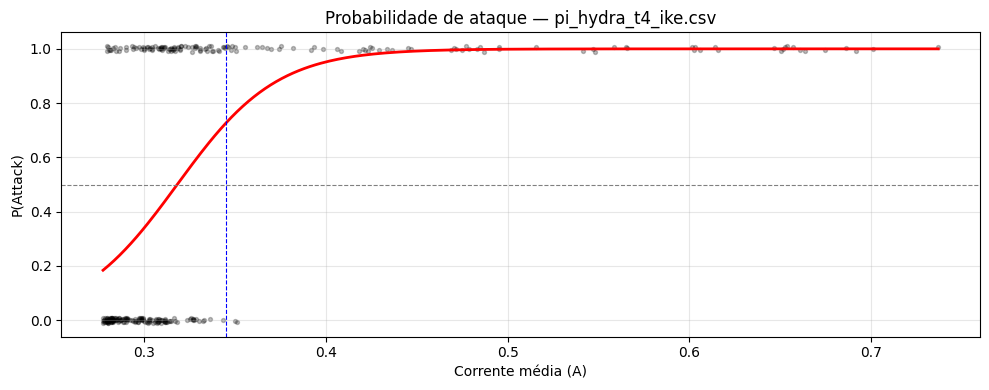

In [ ]:
START_DATE = pd.to_datetime("2012-02-29 00:00:00")

for csv_file in sorted(PI_BRUTEFORCE_PATH.glob("*.csv")):
    if "_legend" in csv_file.name.lower():
        continue

    df = pd.read_csv(csv_file)
    if "Time" not in df.columns or "Current" not in df.columns:
        continue

    for col in ["anno_string", "anno_type", "anno_specific"]:
        if col not in df.columns:
            df[col] = "Normal"

    df["is_attack"] = ~(
        (df["anno_string"].astype(str).str.lower() == "normal") &
        (df["anno_type"].astype(str).str.lower() == "normal") &
        (df["anno_specific"].astype(str).str.lower() == "normal")
    )

    df["Time"] = pd.to_numeric(df["Time"], errors="coerce")
    df = df.dropna(subset=["Time", "Current"])
    df["Datetime"] = START_DATE + pd.to_timedelta(df["Time"], unit="s")
    df = df.set_index("Datetime")

    df_sec = (
        df[["Current", "is_attack"]]
        .resample("1s")
        .agg({"Current": "mean", "is_attack": lambda s: s.astype(int).max()})
        .rename(columns={"Current": "Corrente (A)"})
    ).dropna()

    if len(df_sec["is_attack"].unique()) < 2:
        continue

    X = df_sec[["Corrente (A)"]].values
    y = df_sec["is_attack"].astype(int).values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_scaled, y)

    x_vals = np.linspace(X_scaled.min(), X_scaled.max(), 300).reshape(-1, 1)
    y_probs = clf.predict_proba(x_vals)[:, 1]
    x_real = scaler.inverse_transform(x_vals)

    plt.figure(figsize=(10, 4))
    plt.plot(x_real.ravel(), y_probs, color="red", linewidth=2)
    plt.scatter(df_sec["Corrente (A)"], y + (np.random.rand(len(y)) - 0.5) * 0.02, alpha=0.25, color="black", s=8)
    plt.axhline(0.5, color="gray", linestyle="--", linewidth=0.8)
    plt.axvline(df_sec["Corrente (A)"].mean(), color="blue", linestyle="--", linewidth=0.8)
    plt.xlabel("Corrente média (A)")
    plt.ylabel("P(Attack)")
    plt.title(f"Probabilidade de ataque — {csv_file.name}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# ============================================================
# DRAGON_BRUTEFORCE_LARGE
# ============================================================


In [13]:
DRAGON_BRUTEFORCE_PATH = Path("dragon_pi/dragon/dragon_bruteforce_large")

results = []

for csv_file in sorted(DRAGON_BRUTEFORCE_PATH.glob("*.csv")):
    if "_legend" in csv_file.name.lower():
        continue

    try:
        df = pd.read_csv(csv_file)
        if "Time" not in df.columns:
            continue

        start = pd.to_timedelta(df["Time"].min(), unit="s")
        end = pd.to_timedelta(df["Time"].max(), unit="s")
        duration = (end - start)

        results.append({
            "Arquivo": csv_file.name,
            "Tamanho (MB)": round(csv_file.stat().st_size / (1024 ** 2), 2),
            "Início": str(start),
            "Fim": str(end),
            "Duração (h)": round(duration.total_seconds() / 3600, 2)
        })
    except Exception as e:
        print(f"Erro ao processar {csv_file.name}: {e}")

df_summary = pd.DataFrame(results)
print(df_summary)


                       Arquivo  Tamanho (MB)           Início  \
0       dragon_hydra_t16_0.csv        881.89  0 days 00:00:00   
1   dragon_hydra_t16_1_cke.csv        693.55  0 days 00:00:00   
2   dragon_hydra_t16_1_ike.csv        699.85  0 days 00:00:00   
3   dragon_hydra_t16_2_cke.csv        697.40  0 days 00:00:00   
4   dragon_hydra_t16_2_ike.csv        690.87  0 days 00:00:00   
5   dragon_hydra_t16_3_cke.csv        698.15  0 days 00:00:00   
6   dragon_hydra_t16_3_ike.csv        883.24  0 days 00:00:00   
7   dragon_hydra_t16_4_cke.csv        705.60  0 days 00:00:00   
8   dragon_hydra_t16_4_ike.csv        702.34  0 days 00:00:00   
9   dragon_hydra_t16_5_cke.csv        697.84  0 days 00:00:00   
10  dragon_hydra_t16_5_ike.csv        702.67  0 days 00:00:00   
11  dragon_hydra_t16_6_cke.csv        701.86  0 days 00:00:00   
12  dragon_hydra_t16_6_ike.csv        721.95  0 days 00:00:00   
13  dragon_hydra_t16_7_cke.csv        714.61  0 days 00:00:00   
14  dragon_hydra_t16_7_ik

In [16]:
def rms(x: pd.Series) -> float:
    """Calcula o valor RMS (Root Mean Square)."""
    return float(np.sqrt(np.mean(np.square(x)))) if len(x) > 0 else np.nan

def stats_from_series(s: pd.Series) -> dict:
    """Calcula estatísticas básicas sobre uma série de corrente."""
    return {
        "mean_current": float(s.mean()),
        "std_current": float(s.std(ddof=0)),  
        "rms_current": rms(s),
        "max_current": float(s.max()),
        "min_current": float(s.min()),
        "amp_current": float(s.max() - s.min())
    }

all_stats = []

for csv_path in tqdm(sorted(DRAGON_BRUTEFORCE_PATH.glob("*.csv"))):
    if "_legend" in csv_path.name.lower():
        continue

    try:
        df = pd.read_csv(csv_path, usecols=["Time", "Current"])
    except Exception as e:
        print(f"[ERRO] Falha ao ler {csv_path.name}: {e}")
        continue

    s = df["Current"].dropna()
    stats = stats_from_series(s)
    stats["std_current"] = float(np.std(s, ddof=0))  
    stats["source_file"] = csv_path.name
    all_stats.append(stats)

df_all = pd.DataFrame(all_stats)
print(f"Arquivos processados: {len(df_all)}\n")
display(df_all.head(34))


100%|██████████| 66/66 [04:37<00:00,  4.21s/it]

Arquivos processados: 33



mean_current  std_current  rms_current  max_current  min_current  \
0       0.114665     0.047858     0.124251     0.383204     0.078890   
1       0.114557     0.040796     0.121604     0.380324     0.080658   
2       0.116346     0.046567     0.125319     0.380092     0.054687   
3       0.116665     0.046361     0.125539     0.386768     0.080248   
4       0.114245     0.041212     0.121451     0.360955     0.080763   
5       0.114776     0.041586     0.122078     0.372248     0.080378   
6       0.111301     0.037735     0.117523     0.373196     0.081061   
7       0.116518     0.047498     0.125827     0.378882     0.079717   
8       0.109277     0.049573     0.119996     0.363982     0.054020   
9       0.117257     0.047168     0.126388     0.373352     0.080305   
10      0.116473     0.047264     0.125697     0.384399     0.080027   
11      0.114622     0.047244     0.123977     0.369997     0.080539   
12      0.125215     0.060153     0.138914     0.374960     0.080531   
13      0.122612     0.055731     0.134683     0.372040     0.080758   
14      0.123741     0.058876     0.137033     0.367730     0.079890   
15      0.123686     0.058014     0.136616     0.386008     0.055132   
16      0.102447     0.022897     0.104975     0.306037     0.050290   
17      0.096913     0.013064     0.097790     0.225716     0.076398   
18      0.099218     0.017977     0.100834     0.269312     0.076340   
19      0.096900     0.013487     0.097835     0.235882     0.076357   
20      0.097337     0.014438     0.098402     0.241052     0.076055   
21      0.123176     0.065826     0.139662     0.378802     0.076842   
22      0.116382     0.058729     0.130361     0.379231     0.076653   
23      0.123780     0.066503     0.140513     0.368521     0.076651   
24      0.117085     0.059192     0.131197     0.388703     0.076359   
25      0.106663     0.025216     0.109603     0.350392     0.079084   
26      0.112424     0.034518     0.117604     0.372989     0.080177   
27      0.110979     0.040106     0.118003     0.359969     0.080101   
28      0.111838     0.034449     0.117023     0.363819     0.079892   
29      0.113718     0.037837     0.119848     0.356685     0.079759   
30      0.110662     0.035327     0.116164     0.353605     0.080738   
31      0.117736     0.046723     0.126668     0.382680     0.080632   
32      0.113644     0.044484     0.122040     0.386219     0.080671   

    amp_current                 source_file  
0      0.304313      dragon_hydra_t16_0.csv  
1      0.299665  dragon_hydra_t16_1_cke.csv  
2      0.325405  dragon_hydra_t16_1_ike.csv  
3      0.306520  dragon_hydra_t16_2_cke.csv  
4      0.280192  dragon_hydra_t16_2_ike.csv  
5      0.291870  dragon_hydra_t16_3_cke.csv  
6      0.292135  dragon_hydra_t16_3_ike.csv  
7      0.299165  dragon_hydra_t16_4_cke.csv  
8      0.309961  dragon_hydra_t16_4_ike.csv  
9      0.293047  dragon_hydra_t16_5_cke.csv  
10     0.304372  dragon_hydra_t16_5_ike.csv  
11     0.289458  dragon_hydra_t16_6_cke.csv  
12     0.294429  dragon_hydra_t16_6_ike.csv  
13     0.291282  dragon_hydra_t16_7_cke.csv  
14     0.287840  dragon_hydra_t16_7_ike.csv  
15     0.330876  dragon_hydra_t16_8_cke.csv  
16     0.255747   dragon_hydra_t1_1_cke.csv  
17     0.149318   dragon_hydra_t1_1_ike.csv  
18     0.192972   dragon_hydra_t1_2_cke.csv  
19     0.159525   dragon_hydra_t1_2_ike.csv  
20     0.164997   dragon_hydra_t1_3_ike.csv  
21     0.301960  dragon_hydra_t32_1_cke.csv  
22     0.302578  dragon_hydra_t32_1_ike.csv  
23     0.291870  dragon_hydra_t32_2_cke.csv  
24     0.312344  dragon_hydra_t32_2_ike.csv  
25     0.271308   dragon_hydra_t4_0_ike.csv  
26     0.292811   dragon_hydra_t4_1_cke.csv  
27     0.279868   dragon_hydra_t4_1_ike.csv  
28     0.283928   dragon_hydra_t4_2_cke.csv  
29     0.276927   dragon_hydra_t4_2_ike.csv  
30     0.272867   dragon_hydra_t4_3_cke.csv  
31     0.302048   dragon_hydra_t4_4_cke.csv  
32     0.305549   dragon_hydra_t4_5_c

dragon_hydra_t16_0.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:04:59.999989760 (duration: 0 days 00:04:59.999989760)


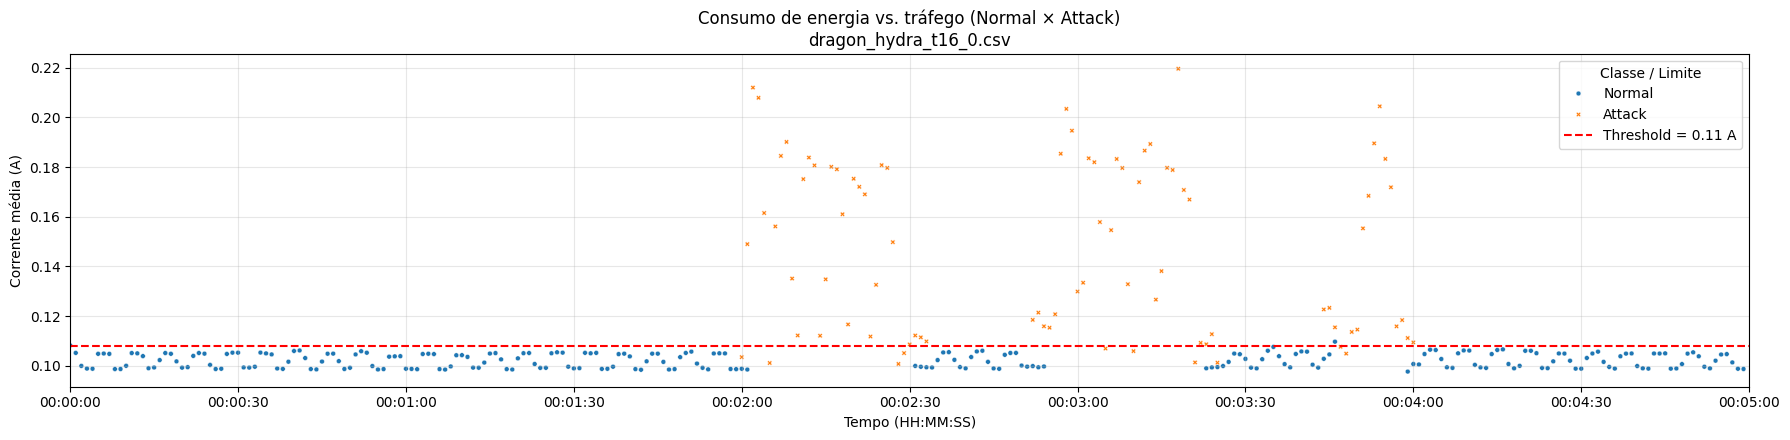

dragon_hydra_t16_1_cke.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:03:59.999979520 (duration: 0 days 00:03:59.999979520)


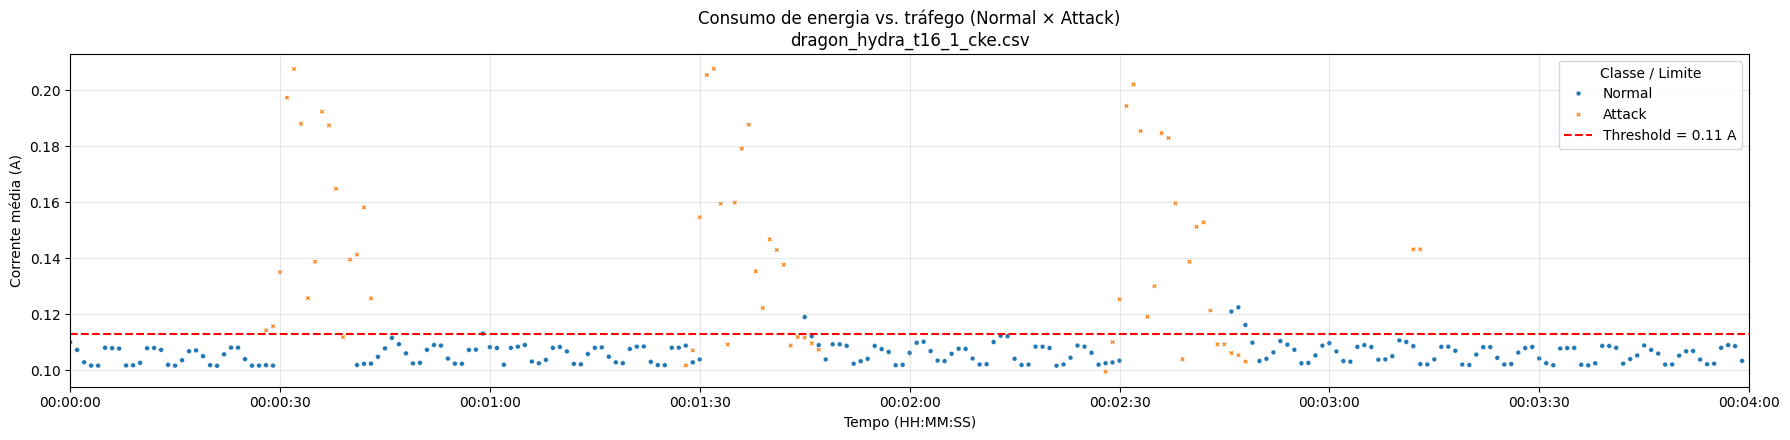

dragon_hydra_t16_1_ike.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:03:59.999979520 (duration: 0 days 00:03:59.999979520)


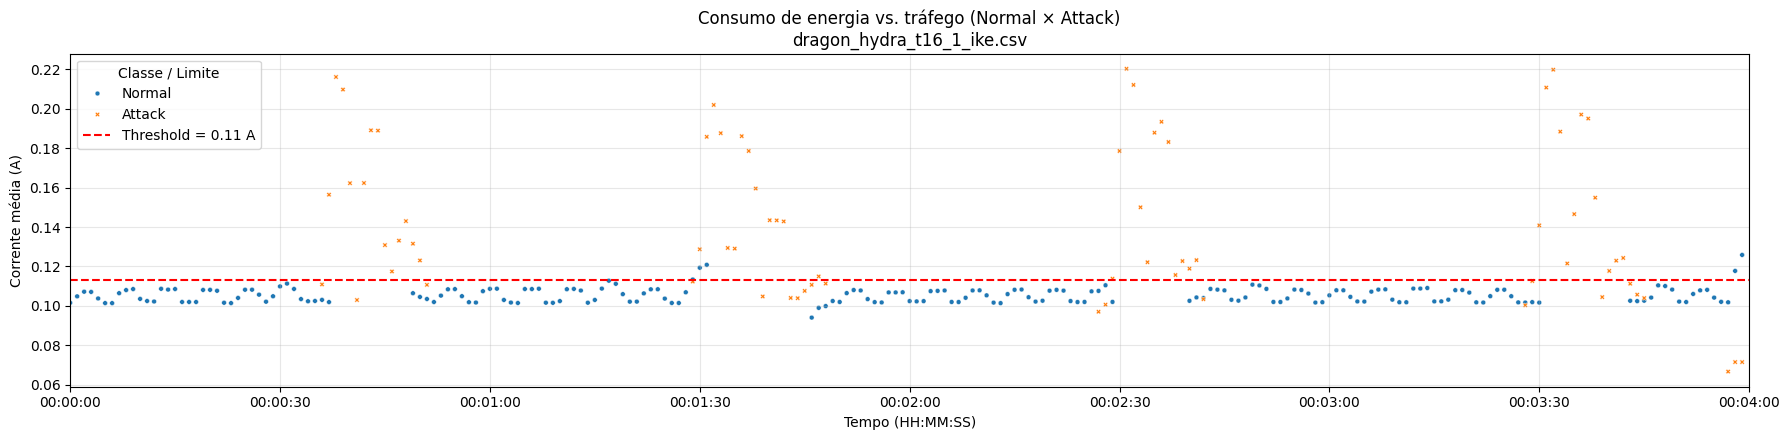

dragon_hydra_t16_2_cke.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:03:59.999979520 (duration: 0 days 00:03:59.999979520)


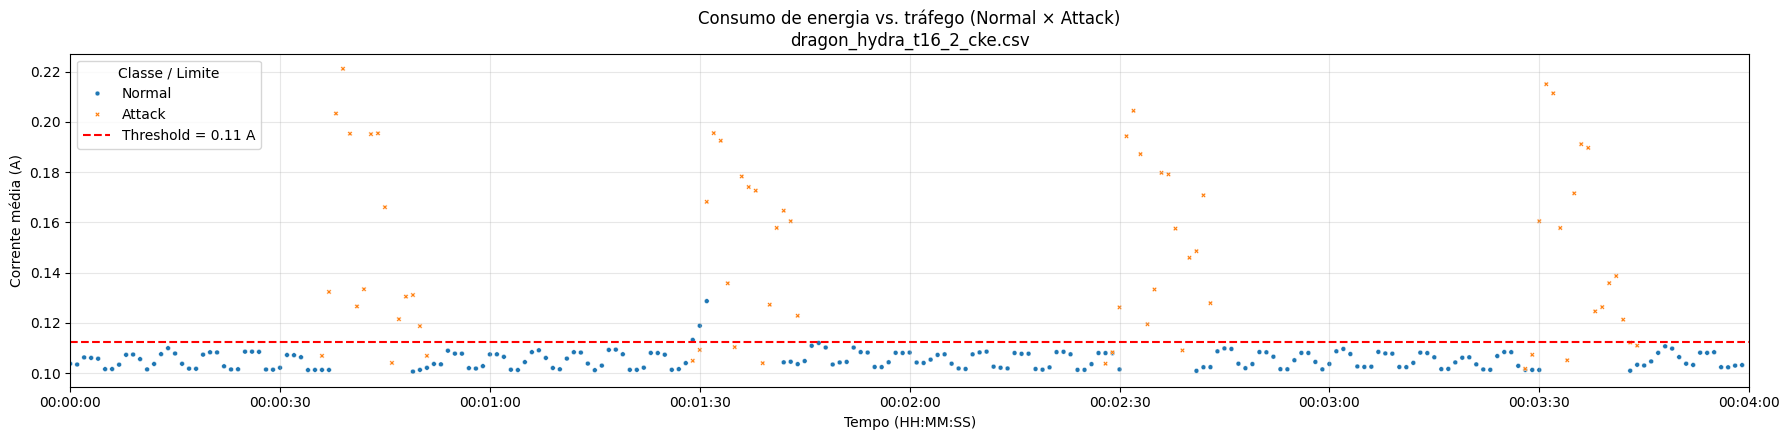

dragon_hydra_t16_2_ike.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:03:59.999979520 (duration: 0 days 00:03:59.999979520)


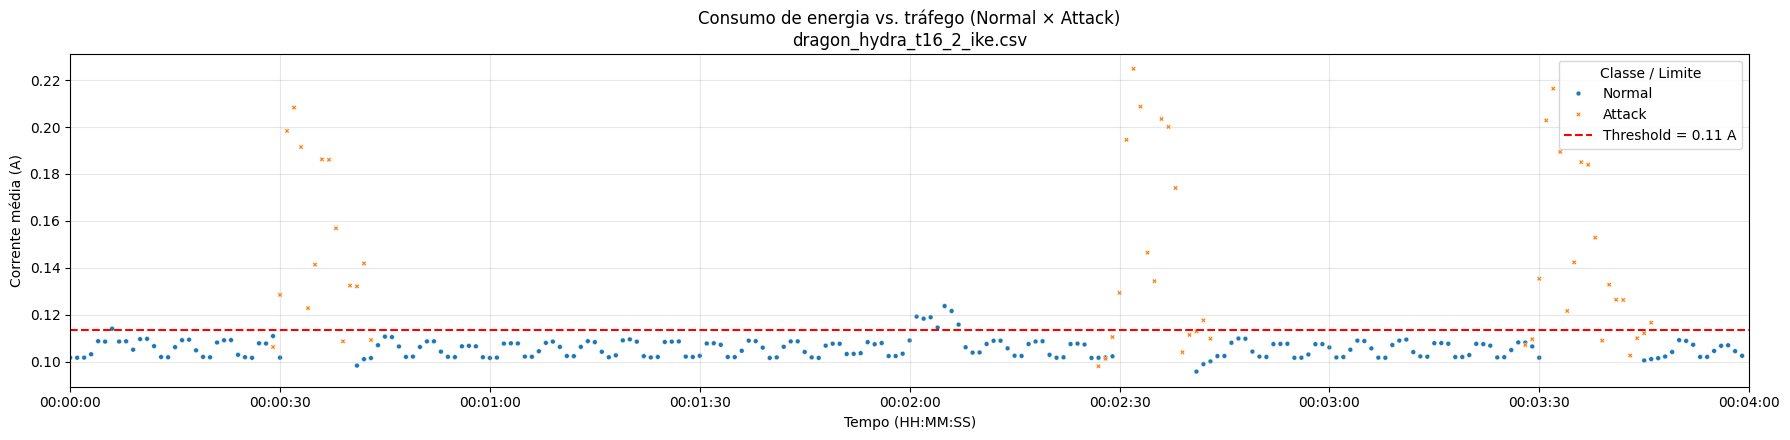

dragon_hydra_t16_3_cke.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:03:59.999979520 (duration: 0 days 00:03:59.999979520)


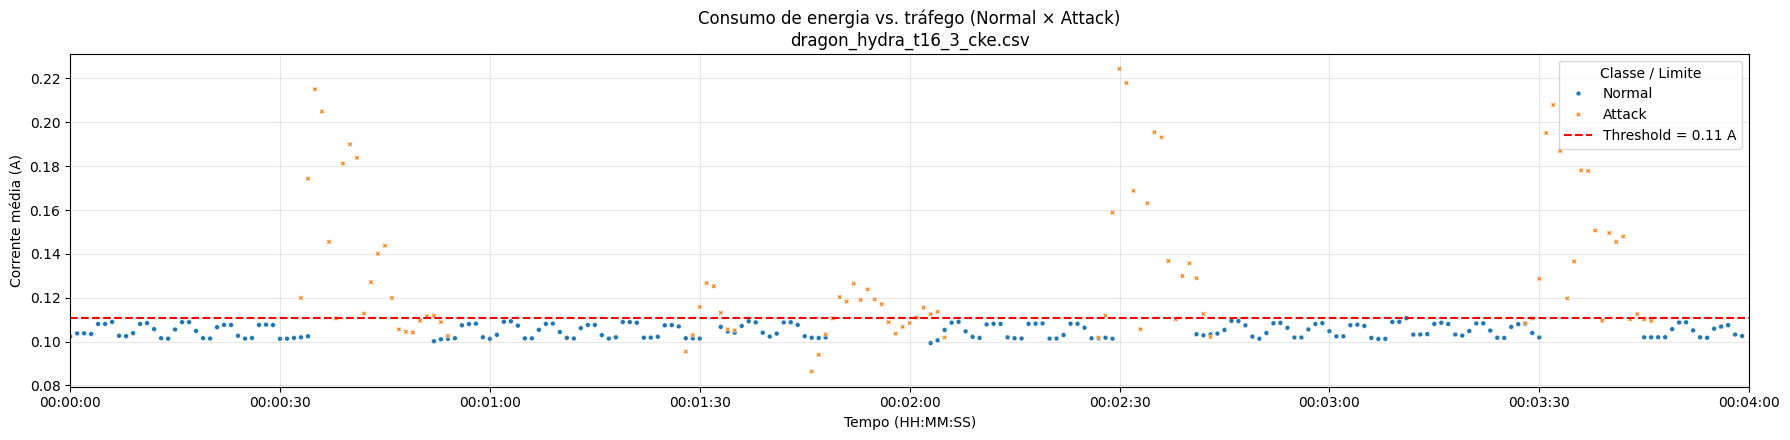

dragon_hydra_t16_3_ike.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:04:59.999989760 (duration: 0 days 00:04:59.999989760)


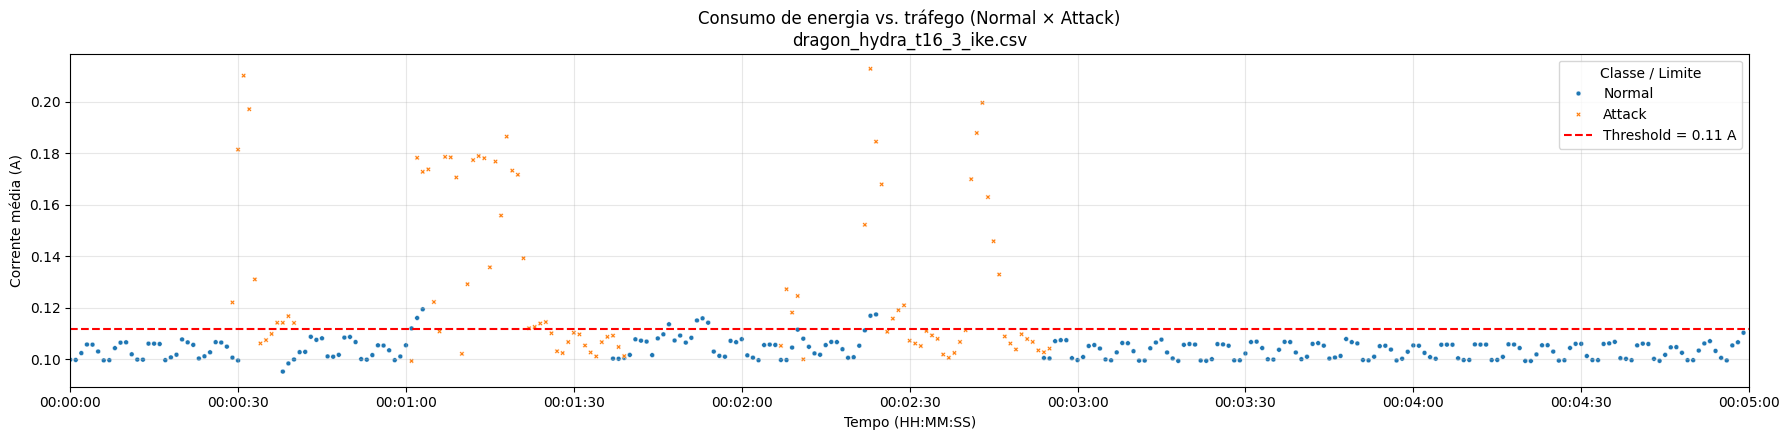

dragon_hydra_t16_4_cke.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:03:59.999979520 (duration: 0 days 00:03:59.999979520)


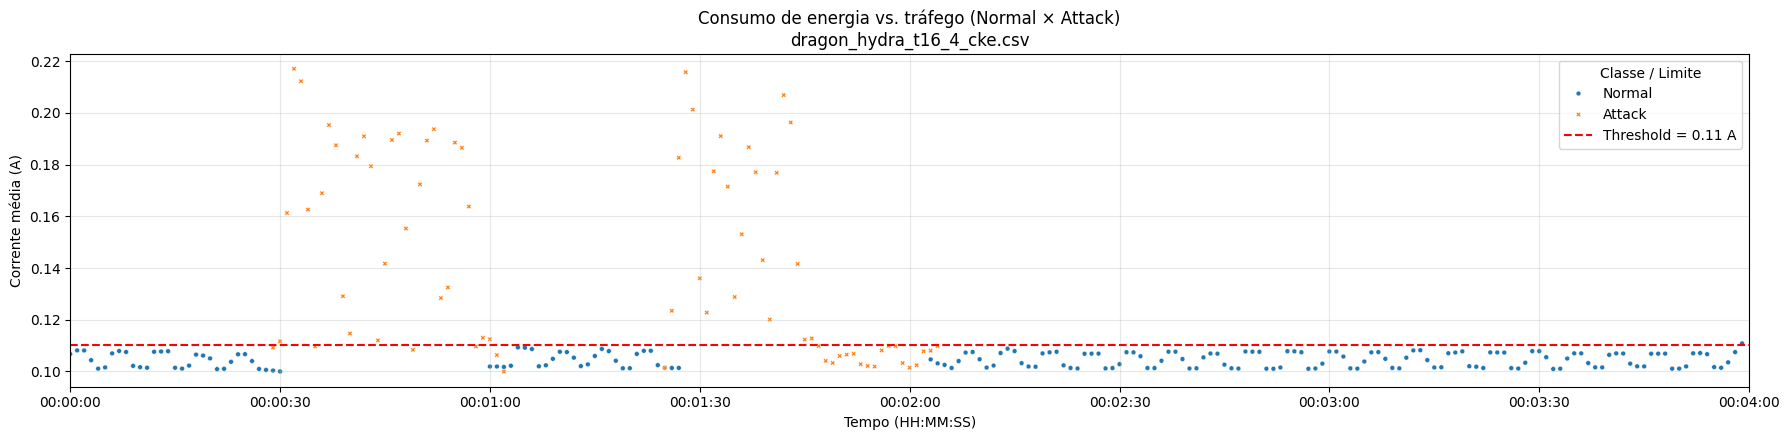

dragon_hydra_t16_4_ike.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:03:59.999979520 (duration: 0 days 00:03:59.999979520)


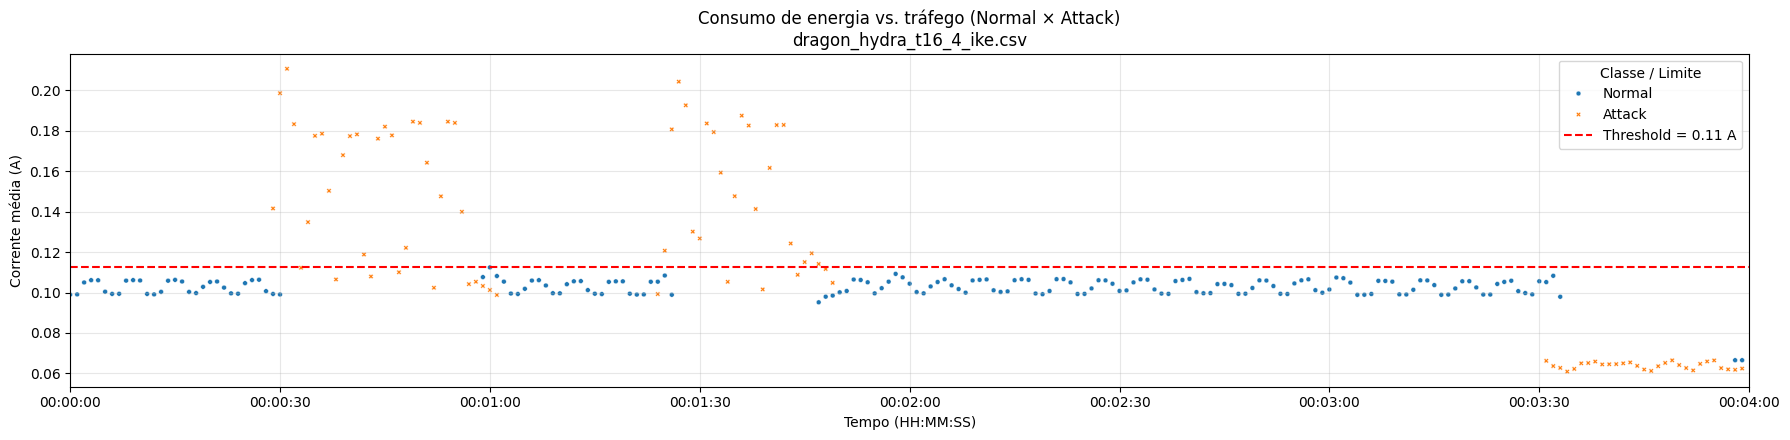

dragon_hydra_t16_5_cke.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:03:59.999979520 (duration: 0 days 00:03:59.999979520)


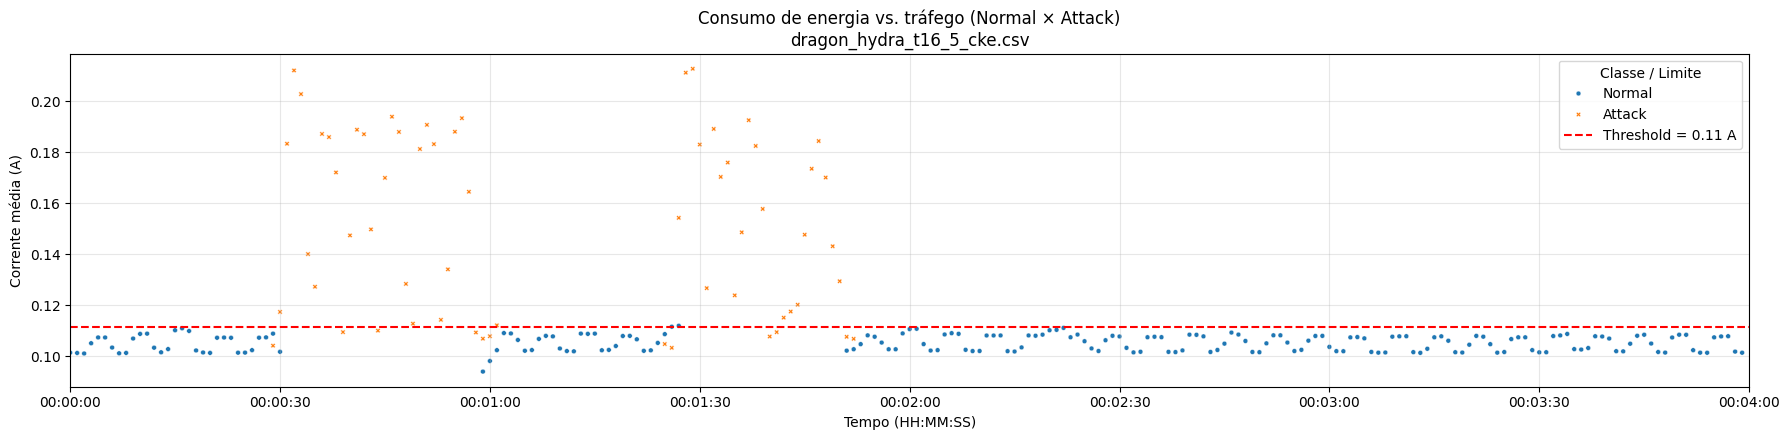

dragon_hydra_t16_5_ike.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:03:59.999979520 (duration: 0 days 00:03:59.999979520)


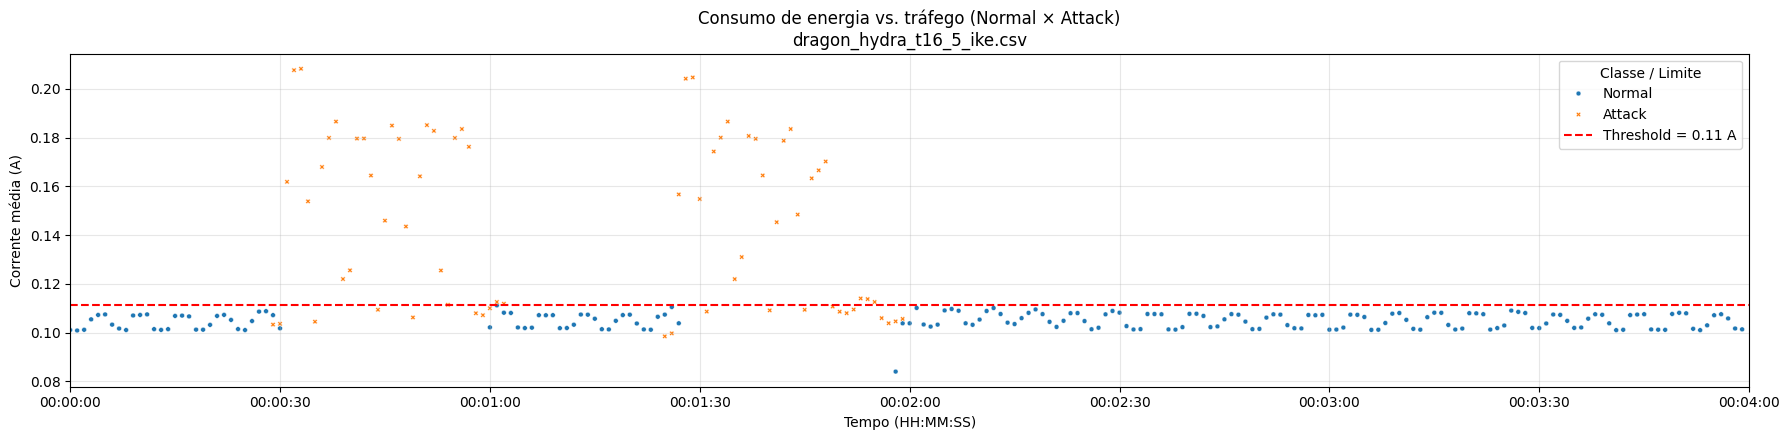

dragon_hydra_t16_6_cke.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:03:59.999979520 (duration: 0 days 00:03:59.999979520)


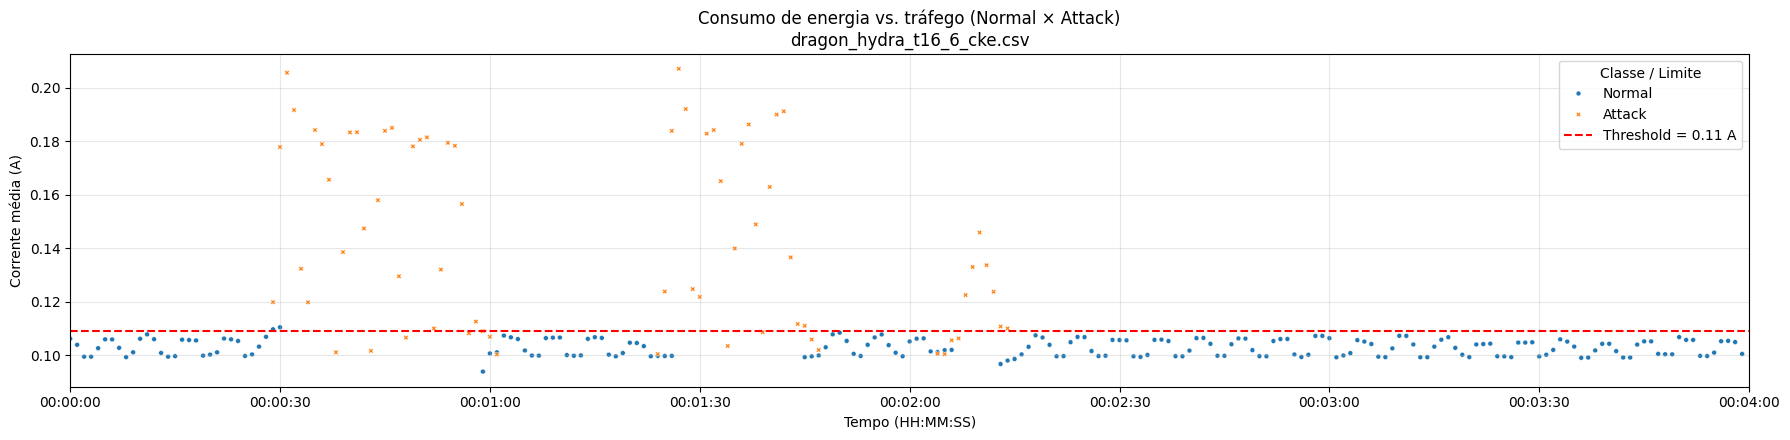

dragon_hydra_t16_6_ike.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:03:59.999979520 (duration: 0 days 00:03:59.999979520)


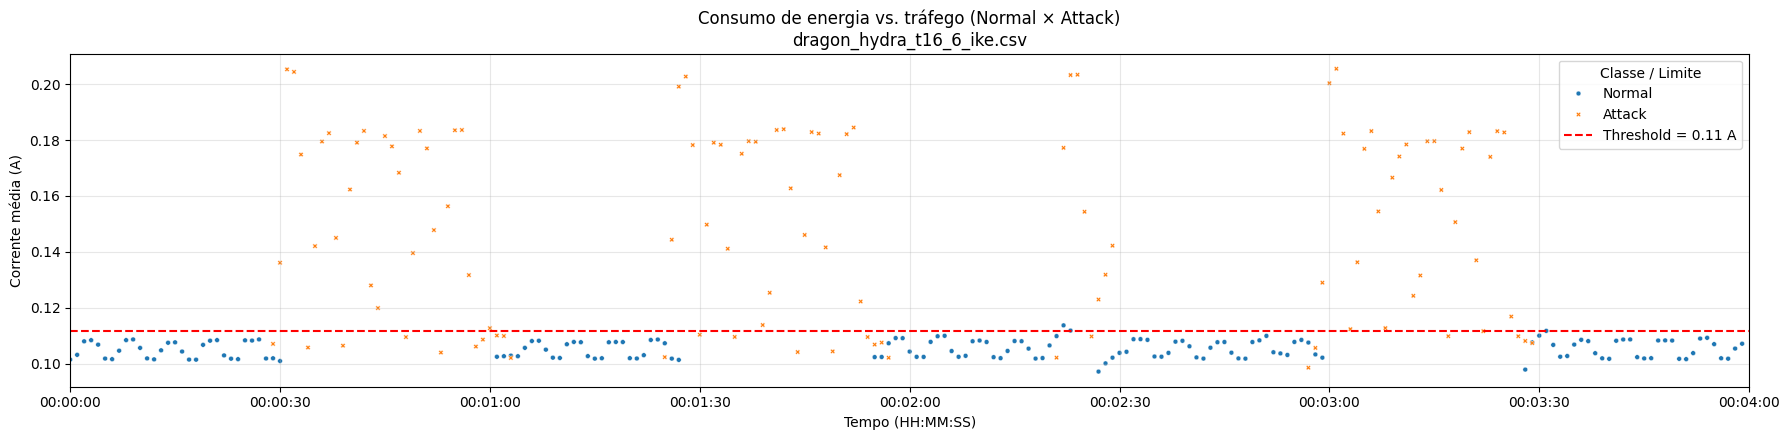

dragon_hydra_t16_7_cke.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:03:59.999979520 (duration: 0 days 00:03:59.999979520)


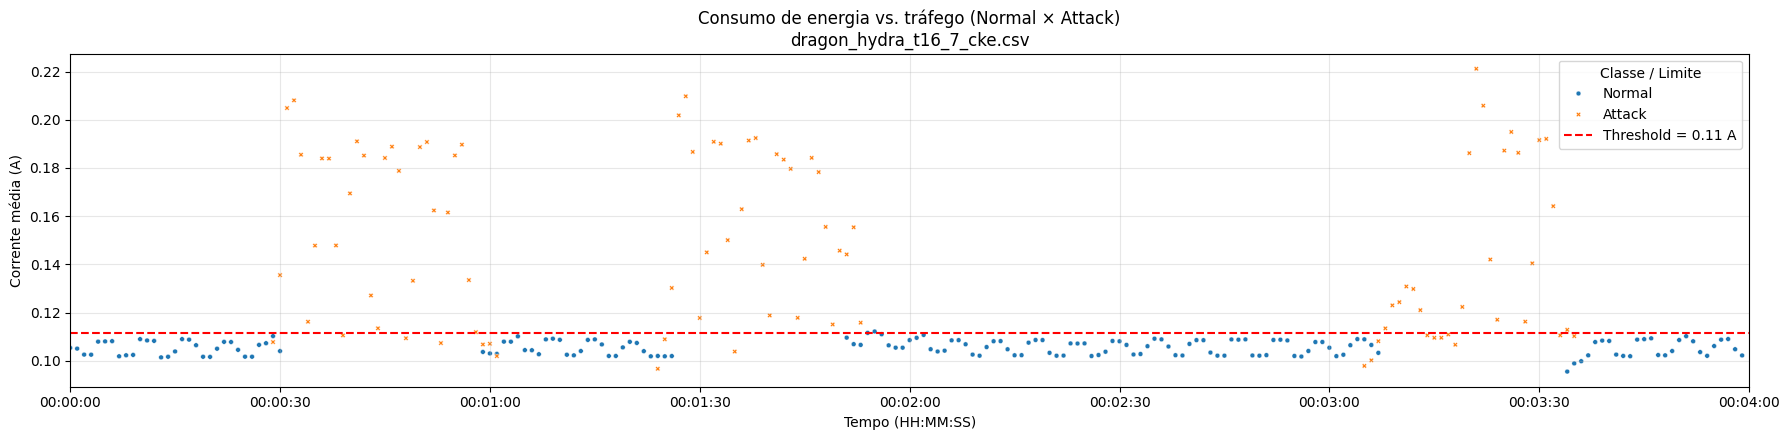

dragon_hydra_t16_7_ike.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:03:59.999979520 (duration: 0 days 00:03:59.999979520)


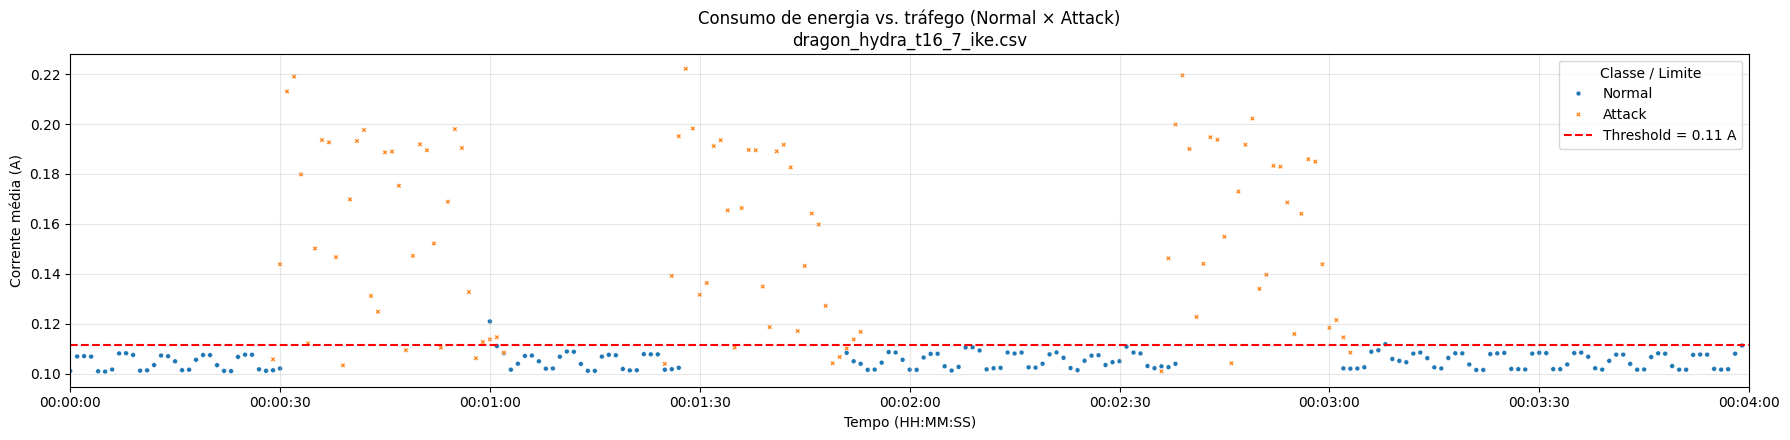

dragon_hydra_t16_8_cke.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:03:59.999979520 (duration: 0 days 00:03:59.999979520)


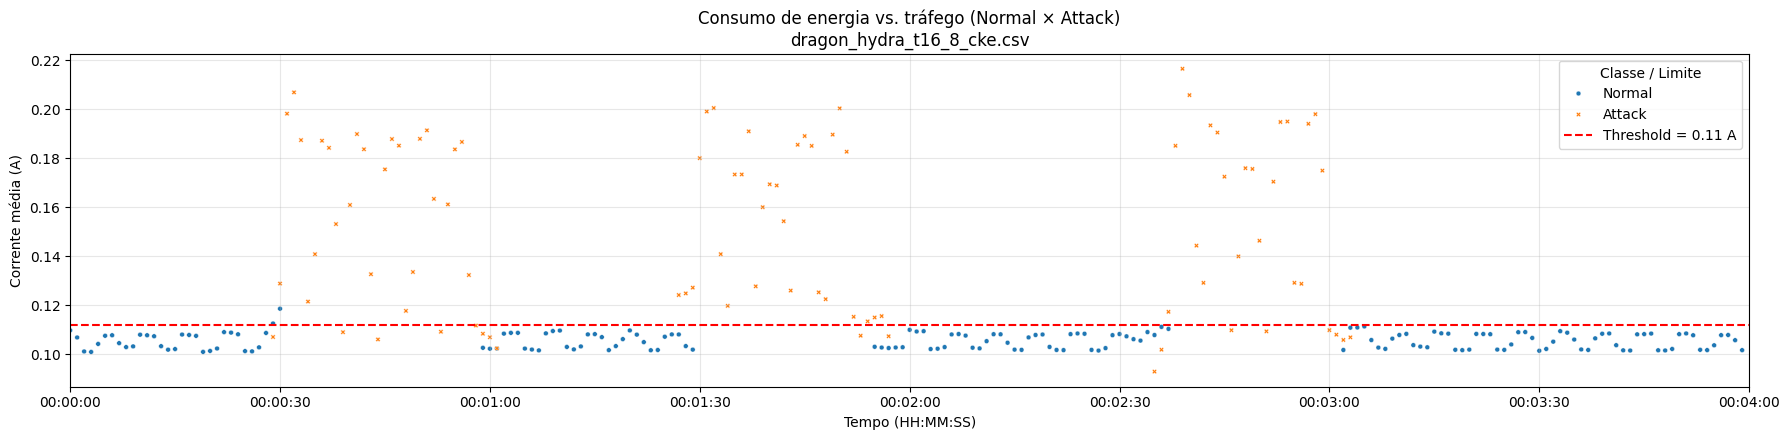

dragon_hydra_t1_1_cke.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:04:59.999989760 (duration: 0 days 00:04:59.999989760)


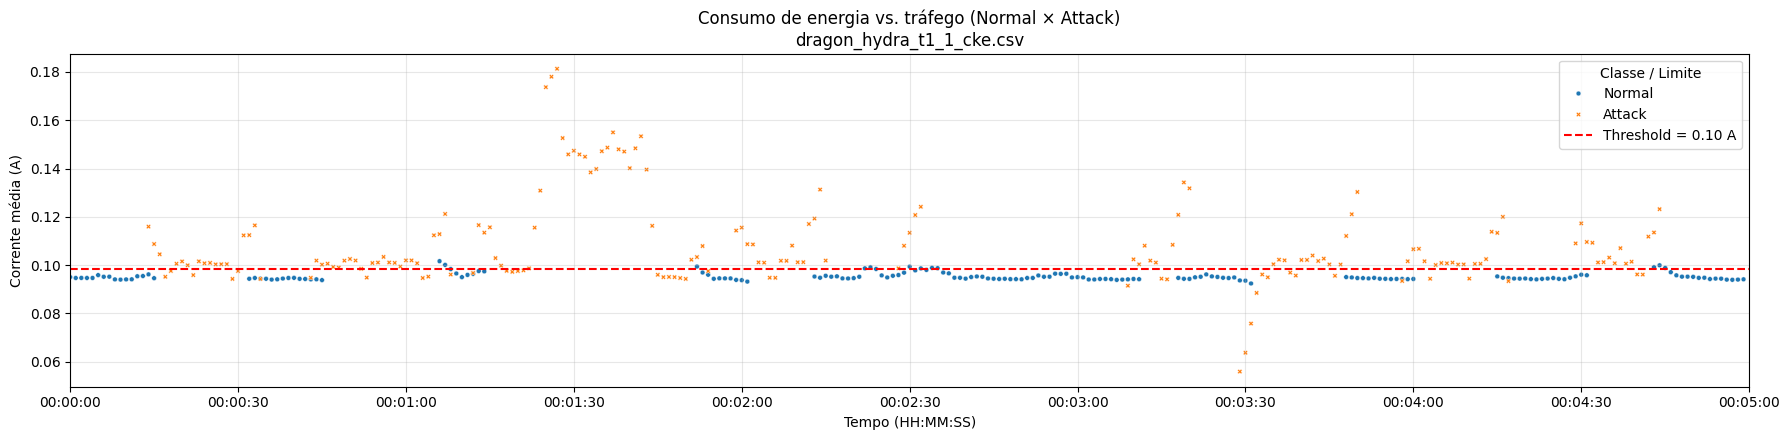

dragon_hydra_t1_1_ike.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:04:59.999989760 (duration: 0 days 00:04:59.999989760)


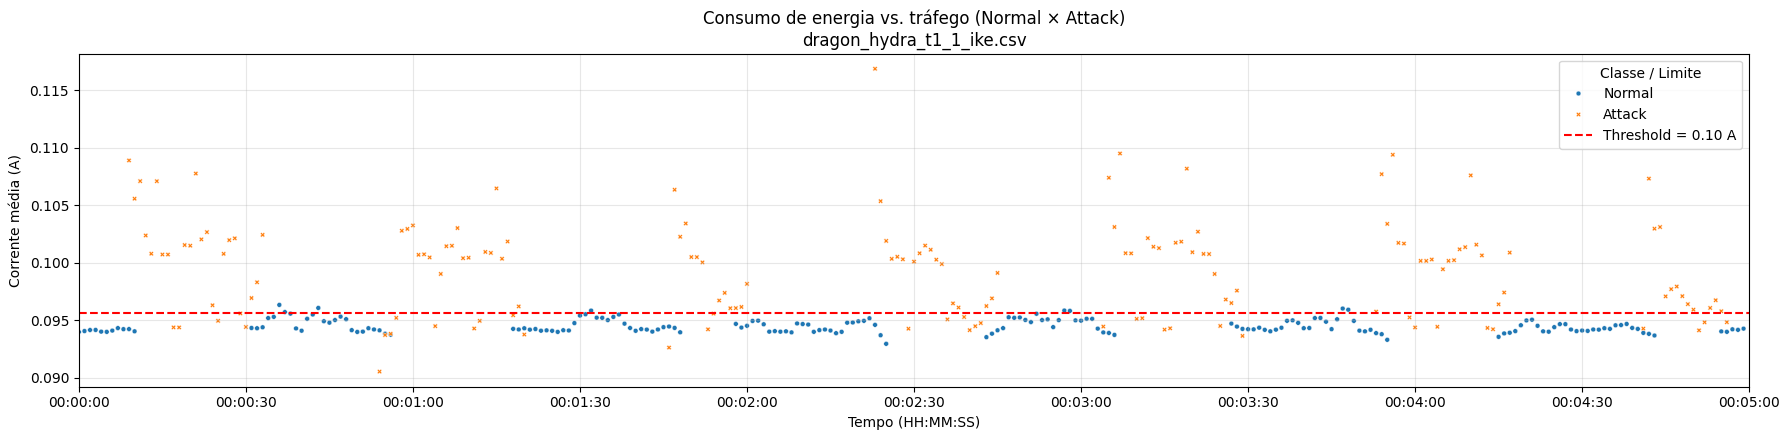

dragon_hydra_t1_2_cke.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:04:59.999989760 (duration: 0 days 00:04:59.999989760)


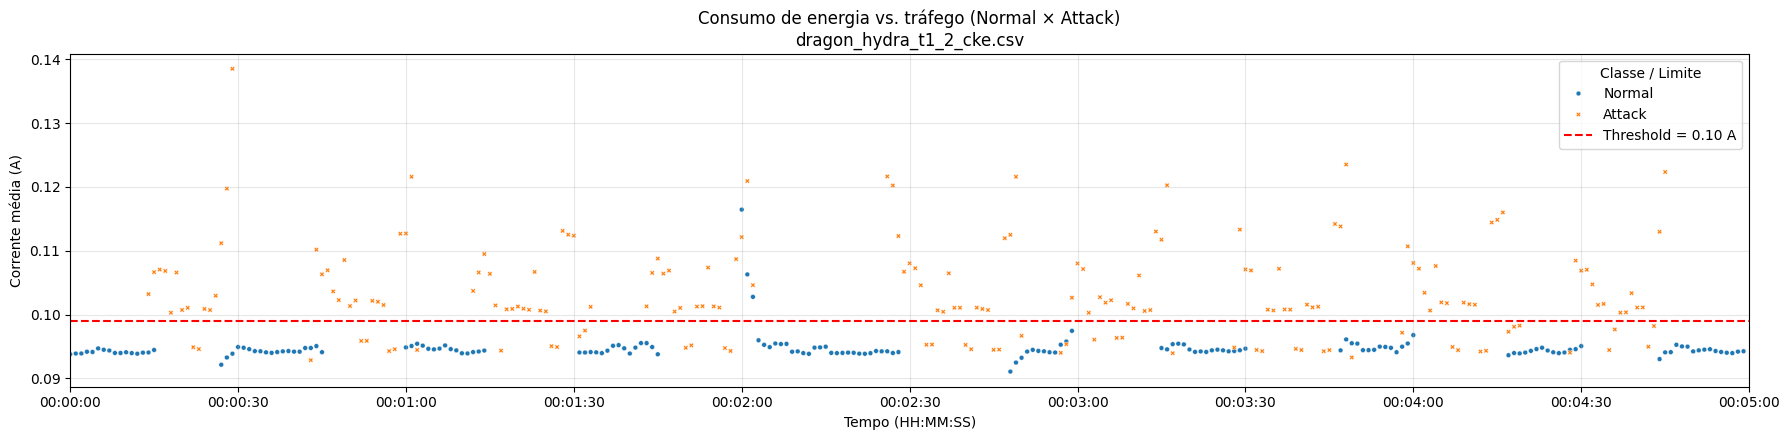

dragon_hydra_t1_2_ike.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:04:59.999989760 (duration: 0 days 00:04:59.999989760)


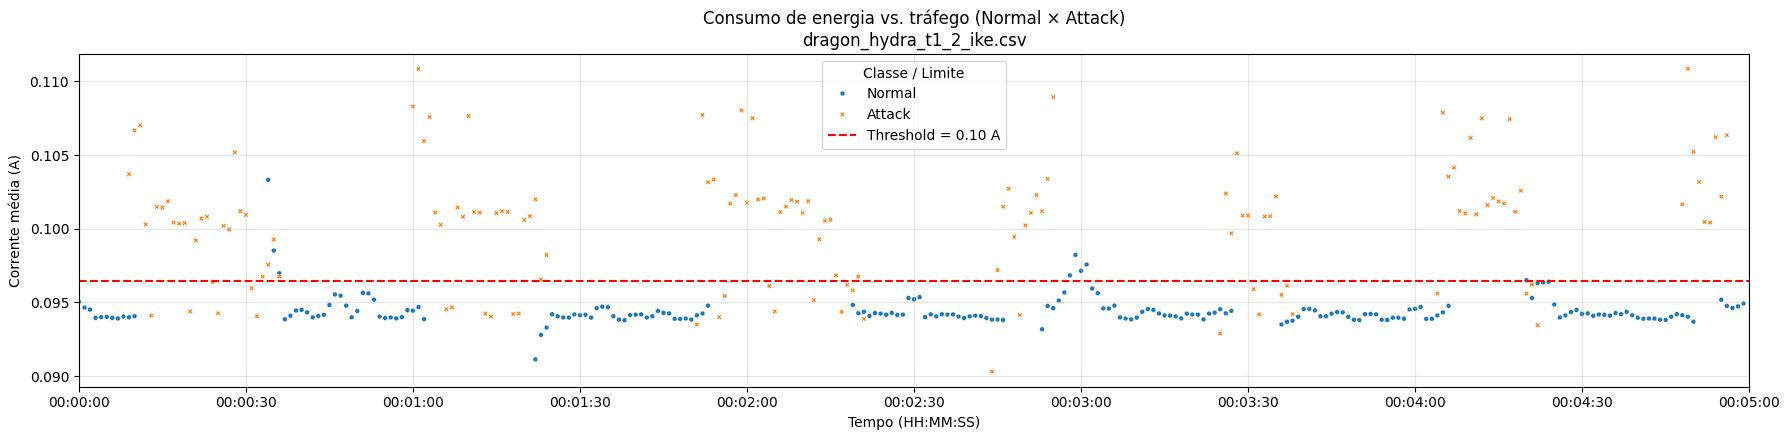

dragon_hydra_t1_3_ike.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:04:59.999989760 (duration: 0 days 00:04:59.999989760)


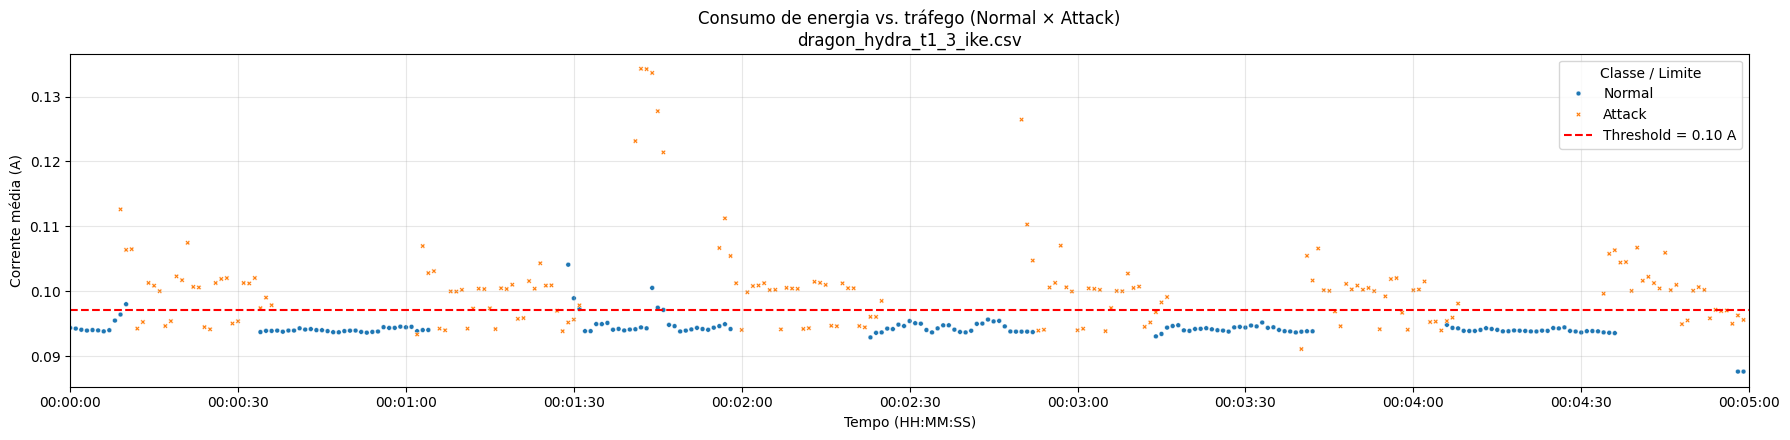

dragon_hydra_t32_1_cke.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:04:59.999989760 (duration: 0 days 00:04:59.999989760)


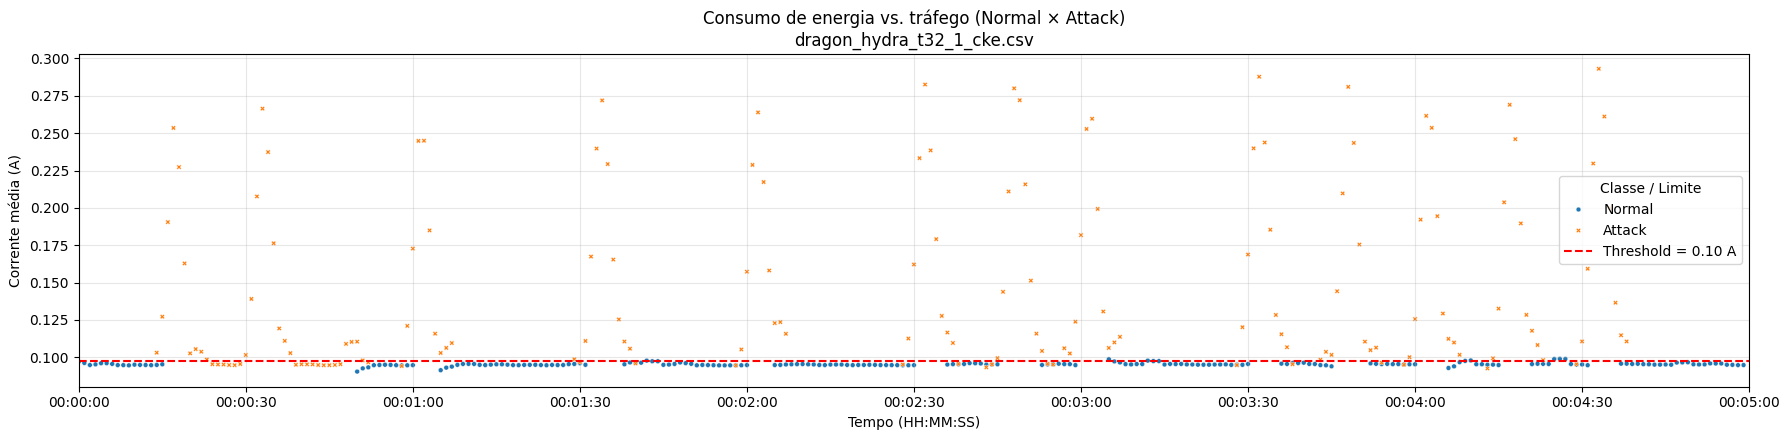

dragon_hydra_t32_1_ike.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:04:59.999989760 (duration: 0 days 00:04:59.999989760)


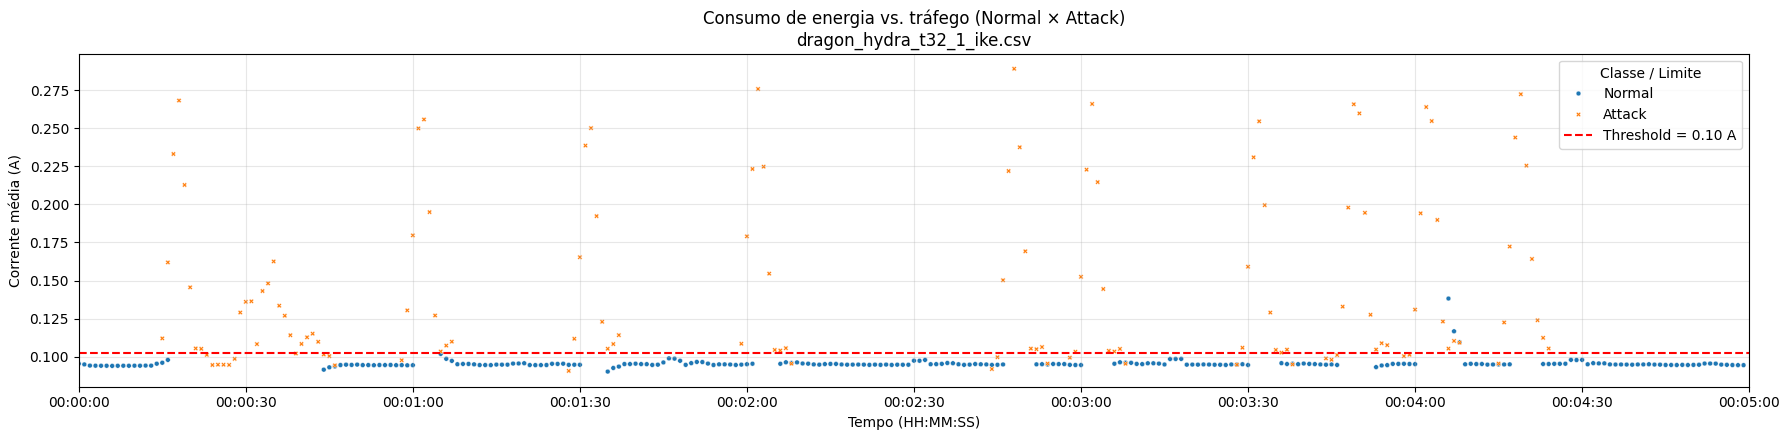

dragon_hydra_t32_2_cke.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:04:59.999989760 (duration: 0 days 00:04:59.999989760)


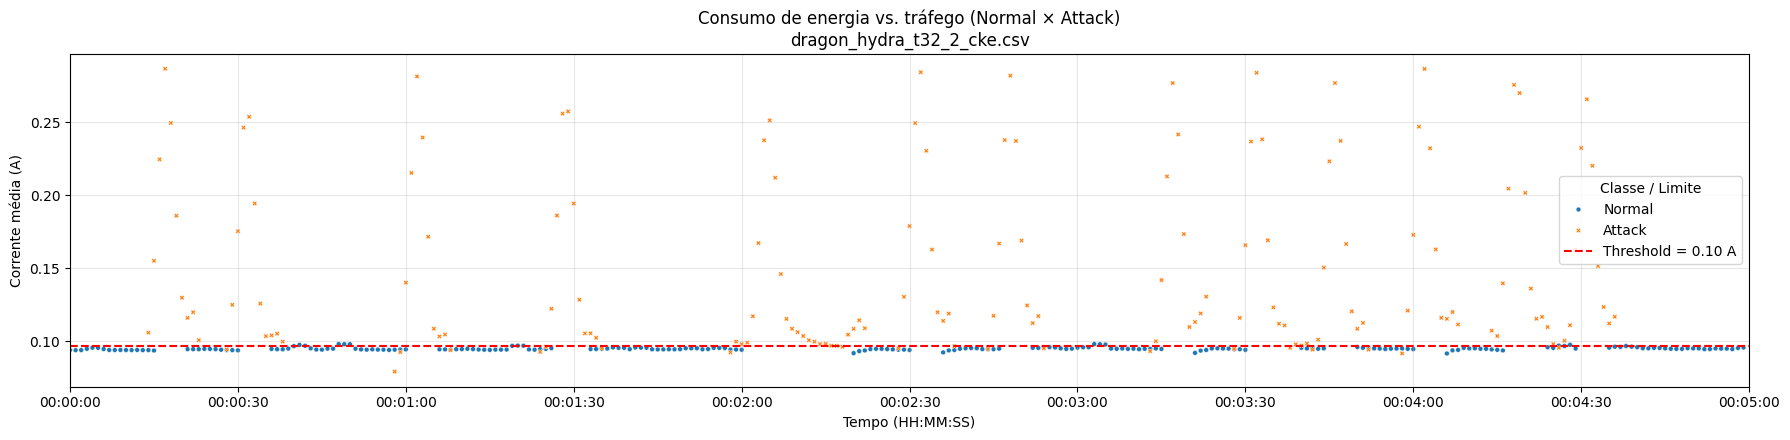

dragon_hydra_t32_2_ike.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:04:59.999989760 (duration: 0 days 00:04:59.999989760)


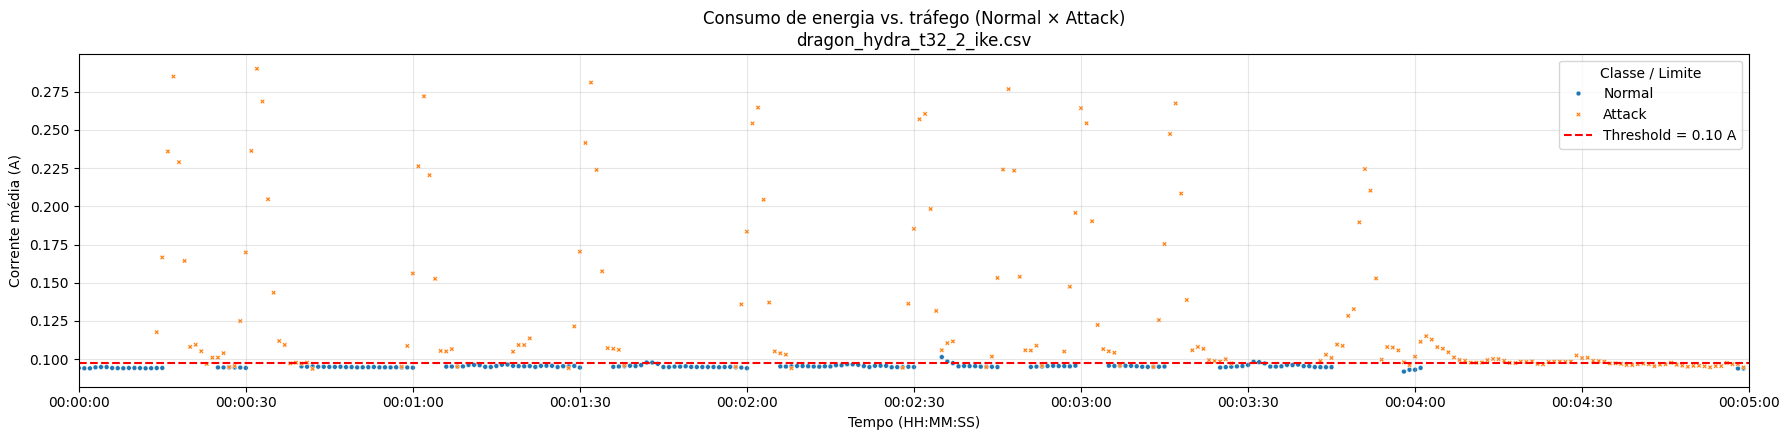

dragon_hydra_t4_0_ike.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:04:59.999989760 (duration: 0 days 00:04:59.999989760)


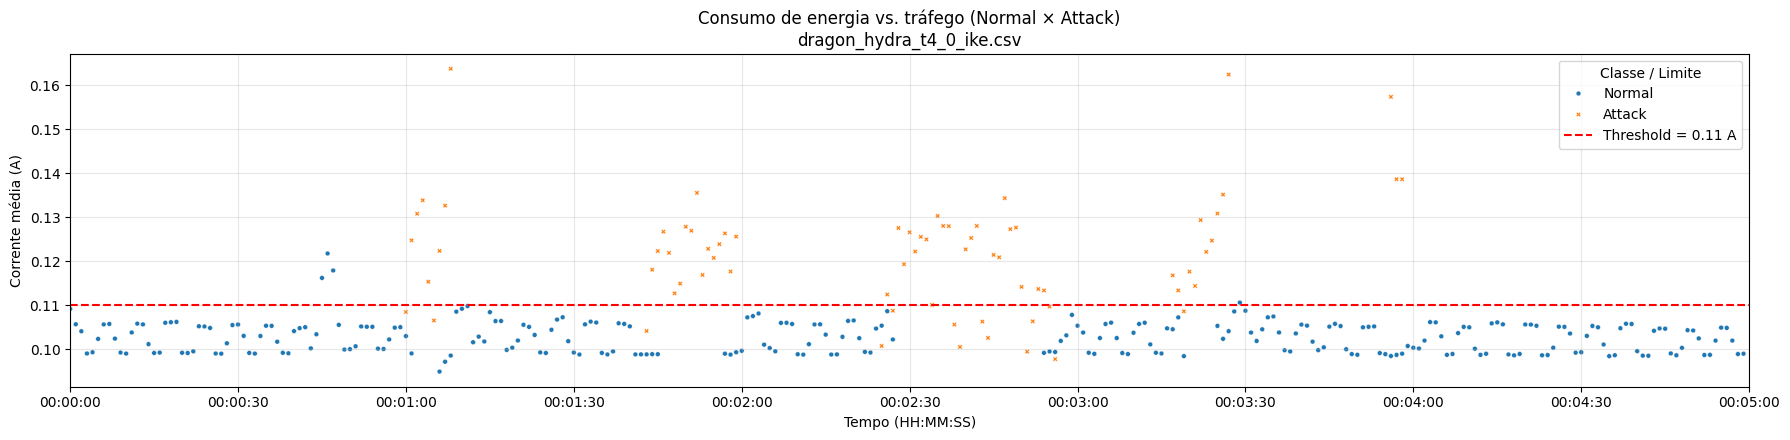

dragon_hydra_t4_1_cke.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:04:59.999989760 (duration: 0 days 00:04:59.999989760)


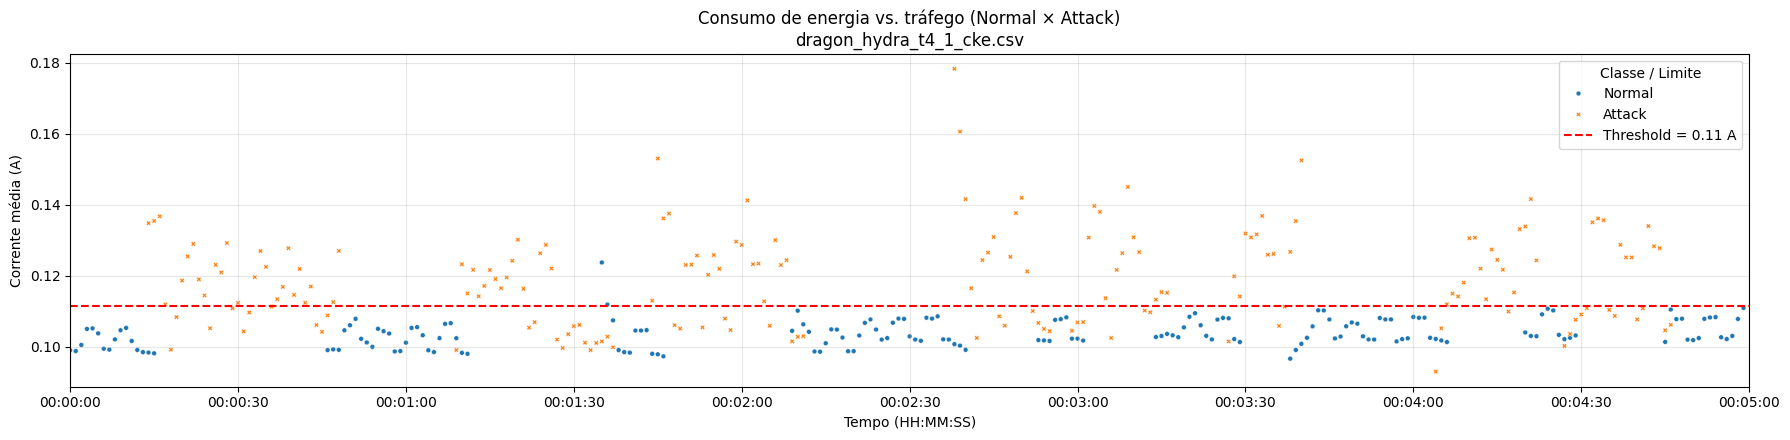

dragon_hydra_t4_1_ike.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:04:59.999989760 (duration: 0 days 00:04:59.999989760)


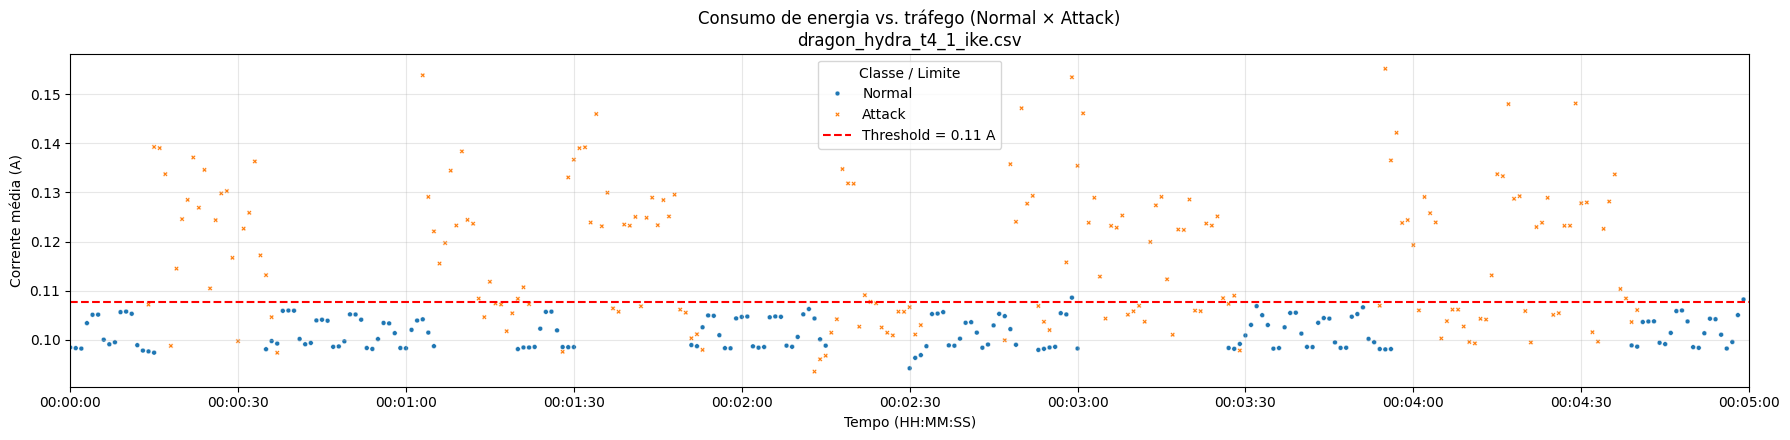

dragon_hydra_t4_2_cke.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:04:59.999989760 (duration: 0 days 00:04:59.999989760)


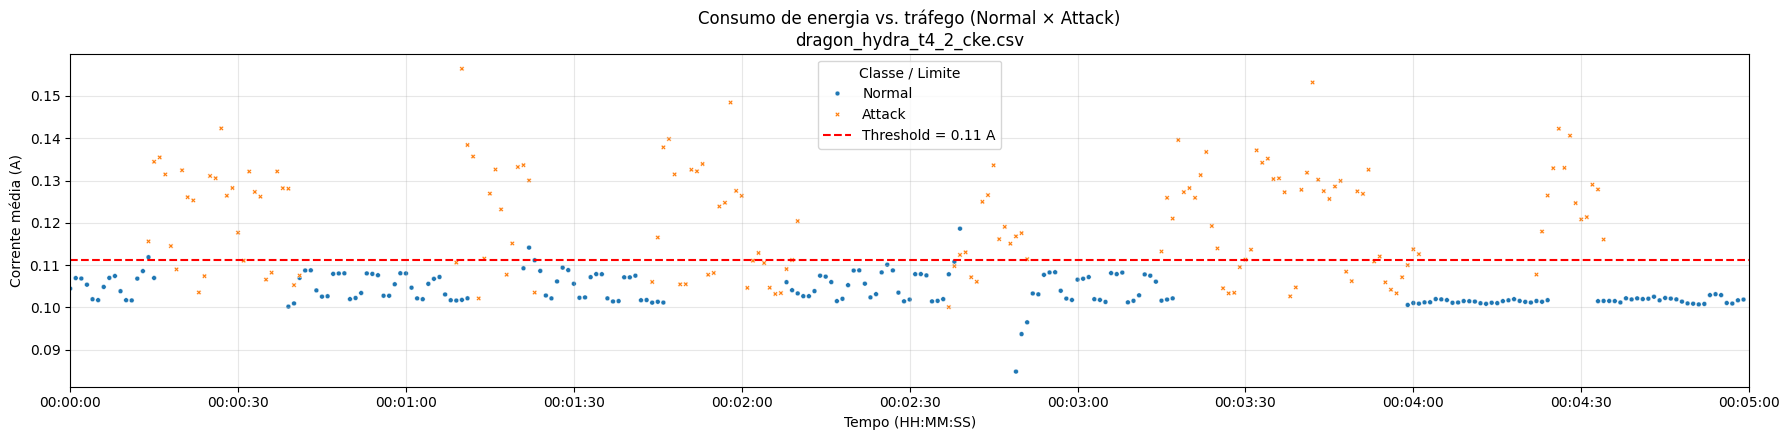

dragon_hydra_t4_2_ike.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:04:59.999989760 (duration: 0 days 00:04:59.999989760)


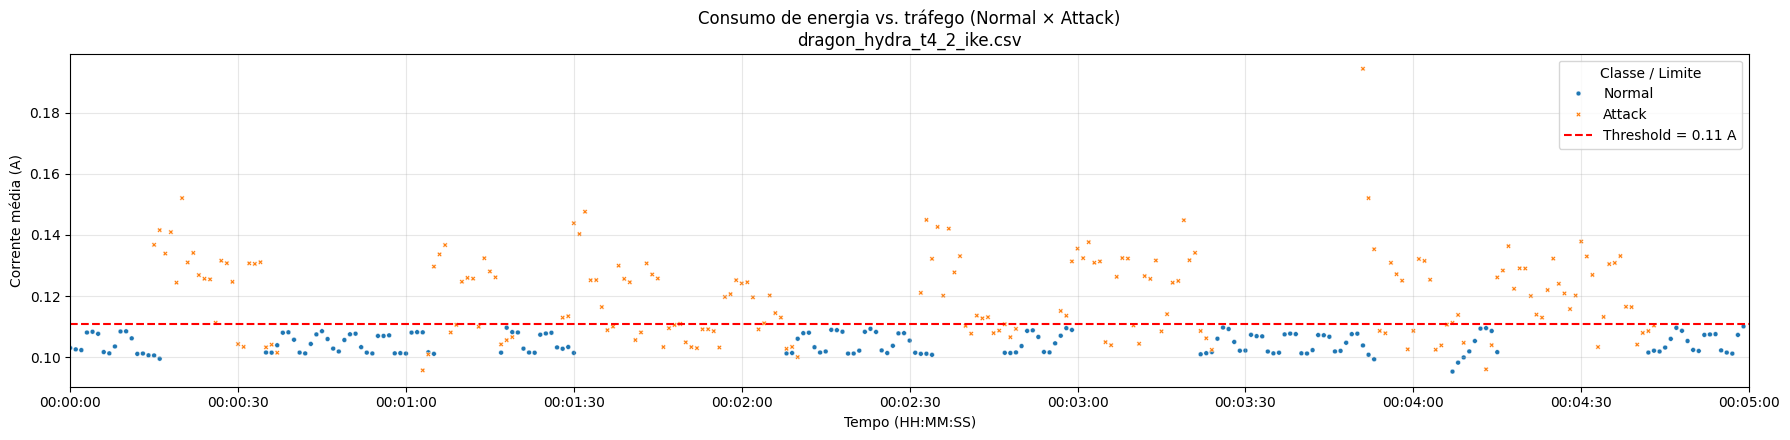

dragon_hydra_t4_3_cke.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:04:59.999989760 (duration: 0 days 00:04:59.999989760)


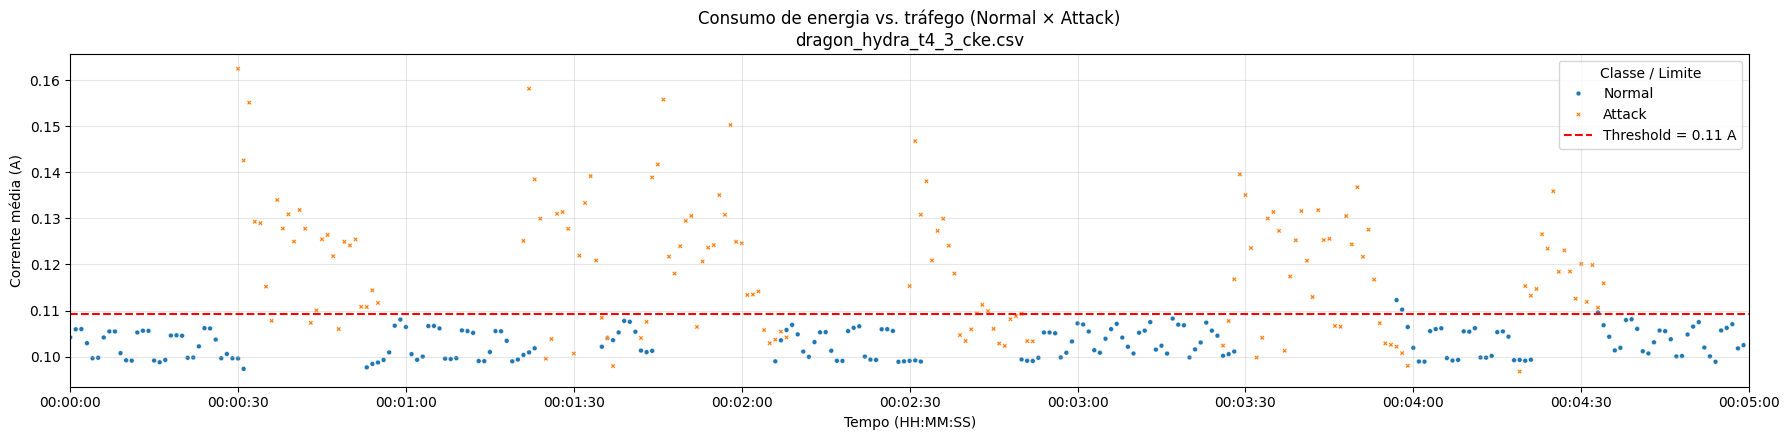

dragon_hydra_t4_4_cke.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:04:59.999989760 (duration: 0 days 00:04:59.999989760)


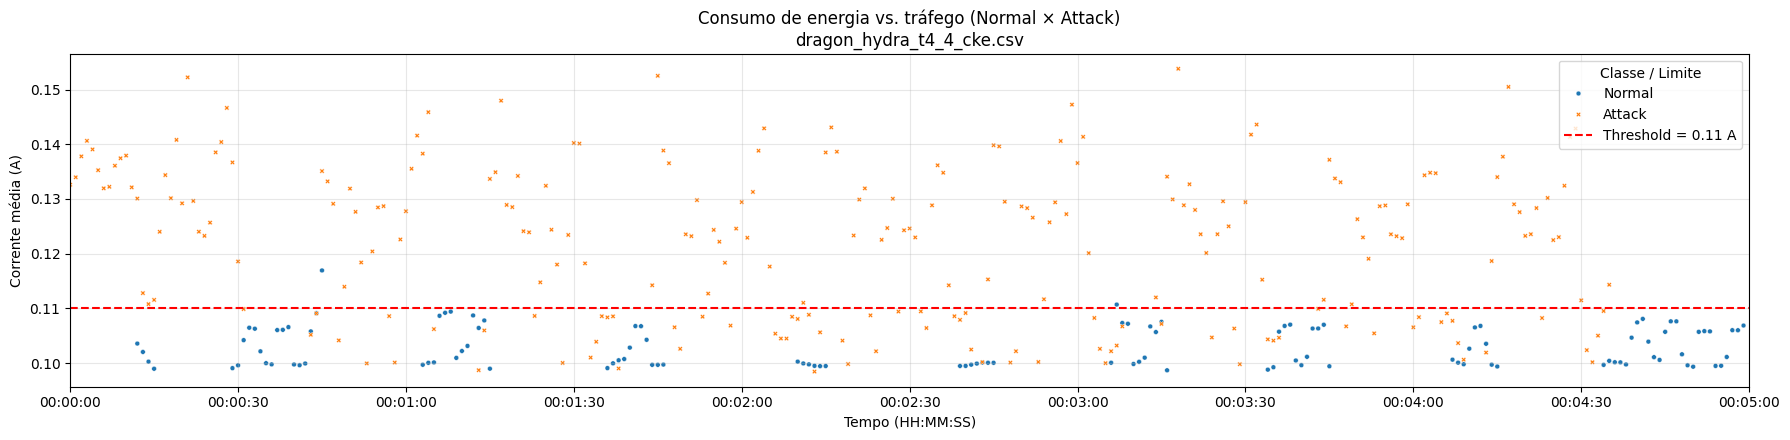

dragon_hydra_t4_5_cke.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:04:59.999989760 (duration: 0 days 00:04:59.999989760)


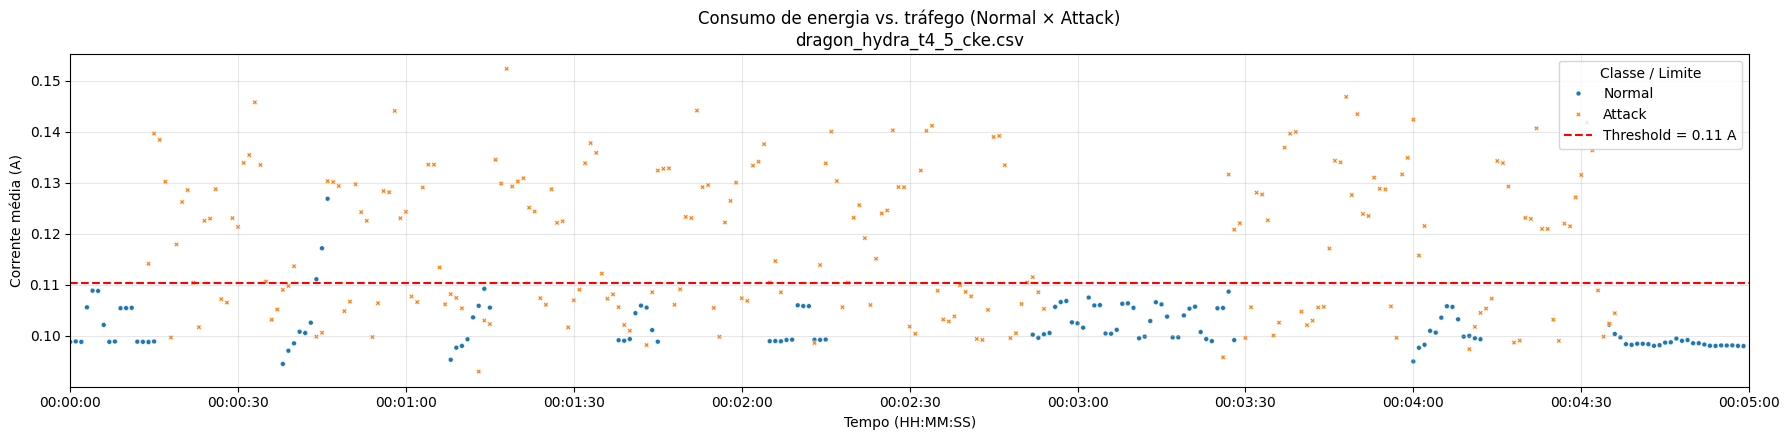

In [ ]:
START_DATE = pd.to_datetime("2012-02-29 00:00:00")

for csv_file in sorted(DRAGON_BRUTEFORCE_PATH.glob("*.csv")):
    if "_legend" in csv_file.name.lower():
        continue

    df = pd.read_csv(csv_file)

    if "Time" not in df.columns:
        continue

    start_td = pd.to_timedelta(df["Time"].min(), unit="s")
    end_td = pd.to_timedelta(df["Time"].max(), unit="s")
    duration_td = end_td - start_td

    print(f"{csv_file.name} — Starts at {start_td} and ends at {end_td} (duration: {duration_td})")

    df = df.set_index("Time")
    df["Datetime"] = pd.to_timedelta(df.index, unit="s") + START_DATE
    df = df.set_index("Datetime")

    for col in ["anno_string", "anno_type", "anno_specific"]:
        if col not in df.columns:
            df[col] = "Normal"

    df["is_attack"] = ~(
        (df["anno_string"].astype(str).str.lower() == "normal")
        & (df["anno_type"].astype(str).str.lower() == "normal")
        & (df["anno_specific"].astype(str).str.lower() == "normal")
    )

    df_sec = (
        df[["Current", "is_attack"]]
        .groupby("is_attack")["Current"]
        .resample("1s")
        .mean()
        .rename("Corrente (A)")
        .reset_index()
    )

    df_sec["Corrente (A)"] = (
        df_sec.groupby("is_attack")["Corrente (A)"]
        .transform(lambda s: s.rolling(3, min_periods=1, center=True).mean())
    )
    df_sec["classe"] = df_sec["is_attack"].map({False: "Normal", True: "Attack"})

    fig, ax = plt.subplots(figsize=(18, 4.5))
    sns.scatterplot(
        data=df_sec,
        x="Datetime",
        y="Corrente (A)",
        hue="classe",
        style="classe",
        s=12,
        ax=ax
    )

    xmin = df.index.min().floor("s")
    xmax = df.index.max().ceil("s")
    ax.set_xlim(xmin, xmax)

    ax.xaxis.set_major_locator(mdates.SecondLocator(interval=30))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))

    ax.set_title(f"Consumo de energia vs. tráfego (Normal × Attack)\n{csv_file.name}")
    ax.set_xlabel("Tempo (HH:MM:SS)")
    ax.set_ylabel("Corrente média (A)")
    ax.grid(True, alpha=0.3)

    threshold = df_sec.loc[df_sec["classe"] == "Normal", "Corrente (A)"].mean() \
             + 2 * df_sec.loc[df_sec["classe"] == "Normal", "Corrente (A)"].std()

    ax.axhline(y=threshold, color="red", linestyle="--", label=f"Threshold = {threshold:.2f} A")
    ax.legend(title="Classe / Limite")

    plt.tight_layout()
    plt.show()


# ============================================================
# DRAGON_NORM_LARGE e PI_NORM_LARGE
# ============================================================



--- Normal data (GB) ---
dragon_norm_large    7.49
pi_norm_large        3.28

--- Quantidade de arquivos ---
dragon_norm_large    3
pi_norm_large        2

--- Tamanhos reais dos subarquivos ---
DRAGON  | dragon_norm_1.csv         |      2.495 GB
DRAGON  | dragon_norm_2.csv         |      2.496 GB
DRAGON  | dragon_norm_3.csv         |      2.495 GB
PI      | pi_norm_1.csv             |      1.639 GB
PI      | pi_norm_2.csv             |      1.639 GB


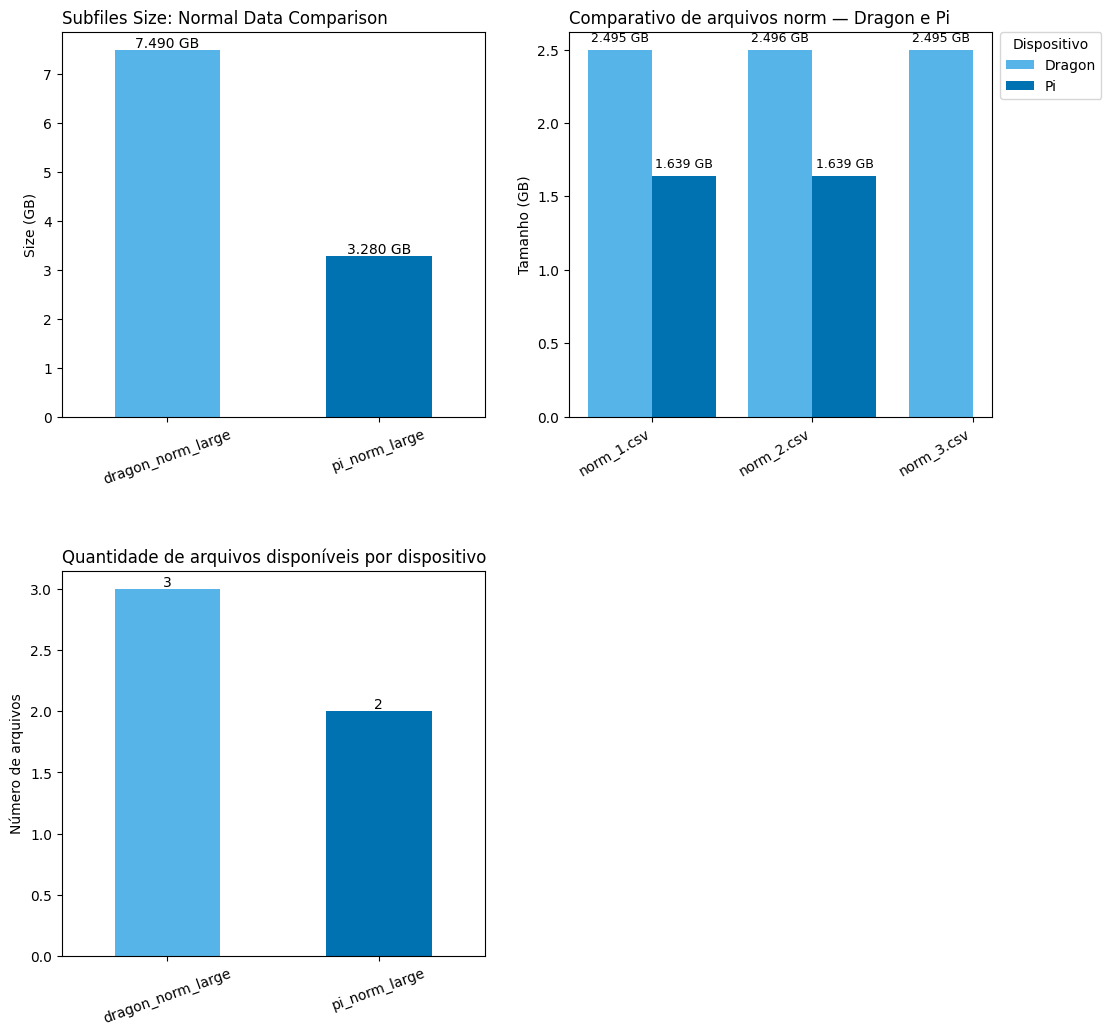

In [ ]:
data_structure_text = """
📁 dragon
  📂 dragon_norm_large
  └── subtotal dragon_norm_large: 7.49 GB
📁 pi
  📂 pi_norm_large
  └── subtotal pi_norm_large: 3.28 GB
"""

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
fig.delaxes(axes[1, 1])
plt.subplots_adjust( hspace=0.4)
ax00 = axes[0, 0]  # Normal
ax01 = axes[0, 1]  # Comparativo Normal (dragon(3 arquivos) x pi(2 arquivos))
ax10 = axes[1, 0]  # Quantidade de arquivos disponíveis por dispositivo

# --- 1. Comparativo dados normais (dragon_norm_large | pi_norm_large) ---
pattern_bf = re.compile(r"subtotal\s+(dragon_norm_large|pi_norm_large):\s+([\d.]+)\s+(GB|MB)", re.IGNORECASE)
sizes_bf = {}
for line in data_structure_text.splitlines():
    m = pattern_bf.search(line)
    if m:
        name, size_str, unit = m.groups()
        size = float(size_str)
        if unit.upper() == "MB":
            size = size / 1024.0
        sizes_bf[name] = size

if sizes_bf:
    df2 = pd.Series(sizes_bf, name="Size (GB)")
    print("\n--- Normal data (GB) ---")
    print(df2.round(3).to_string())
    df2.plot(kind="bar", ax=ax00, color=["#56B4E9", "#0072B2"])
    ax00.set_title("Subfiles Size: Normal Data Comparison", loc="left")
    ax00.set_ylabel("Size (GB)")
    ax00.tick_params(axis="x", rotation=20)
    for c in ax00.containers:
        ax00.bar_label(c, fmt="%.3f GB")
else:
    ax00.text(0.5, 0.5, "No data to plot", ha="center", va="center", fontsize=12)
    ax00.set_title("Subfiles Size: Normal Data Comparison", loc="left")

# --- 2. Quantidade de arquivos disponíveis por dispositivo ---
counts = pd.Series({"dragon_norm_large": 3, "pi_norm_large": 2})
print("\n--- Quantidade de arquivos ---")
print(counts.to_string())

counts.plot(kind="bar", color=["#56B4E9", "#0072B2"], ax=ax10)
ax10.set_title("Quantidade de arquivos disponíveis por dispositivo", loc="left")
ax10.set_ylabel("Número de arquivos")
ax10.tick_params(axis='x', rotation=20)
for c in ax10.containers:
    ax10.bar_label(c)

# --- 3. Comparativo arquivos norm — Dragon vs Pi (em GB) ---
BASE_DIR = Path("./dragon_pi").expanduser()
EXCLUDE_SUBSTR = "_legend"
DEVICE_KEYS = ["dragon", "pi"]

entries = []
if BASE_DIR.exists():
    for norm_dir in BASE_DIR.rglob("*norm*"):
        if not norm_dir.is_dir():
            continue
        for f in norm_dir.rglob("*.csv"):
            if not f.is_file():
                continue
            nlow = f.stem.lower()
            if EXCLUDE_SUBSTR in nlow:
                continue
            dev = "dragon" if "dragon" in nlow else ("pi" if nlow.startswith("pi_") or "pi" in nlow else None)
            if dev not in DEVICE_KEYS:
                continue
            m = re.search(r"norm_(\d+)", nlow)
            file_id = int(m.group(1)) if m else None
            try:
                size_gb = f.stat().st_size / (1024 ** 3)  
            except OSError:
                continue
            if file_id is not None:
                entries.append((file_id, dev, f.name, size_gb))

print("\n--- Tamanhos reais dos subarquivos ---")
for e in sorted(entries, key=lambda x: (x[1], x[0])):
    print(f"{e[1].upper():7s} | {e[2]:25s} | {e[3]:10.3f} GB")

df = pd.DataFrame(entries, columns=["id", "device", "file", "size_GB"])
df = df.sort_values("id")

pv = df.pivot_table(index="id", columns="device", values="size_GB", aggfunc="sum")

if not pv.empty:
    labels = [f"norm_{i}.csv" for i in pv.index.tolist()]
    x = np.arange(len(labels))
    width = 0.4

    y_dragon = pv.get("dragon", pd.Series([0]*len(labels), index=pv.index)).values
    y_pi     = pv.get("pi",     pd.Series([0]*len(labels), index=pv.index)).values

    ax01.clear()
    b1 = ax01.bar(x - width/2, y_dragon, width, label="Dragon", color="#56B4E9")
    b2 = ax01.bar(x + width/2, y_pi,     width, label="Pi", color="#0072B2")

    ax01.set_ylabel("Tamanho (GB)")
    ax01.set_title("Comparativo de arquivos norm — Dragon e Pi", loc="left")
    ax01.set_xticks(x)
    ax01.set_xticklabels(labels, rotation=30, ha="right")
    ax01.legend(
    title="Dispositivo",
    loc="upper left",
    bbox_to_anchor=(1.02, 1),
    borderaxespad=0,
)

    for bar in list(b1) + list(b2):
        h = bar.get_height()
        if h and h > 0:
            ax01.annotate(f"{h:.3f} GB",
                          xy=(bar.get_x() + bar.get_width()/2, h),
                          xytext=(0, 4), textcoords="offset points",
                          ha="center", va="bottom", fontsize=9)


In [5]:
DATASETS = {
    "Dragon": Path("dragon_pi/dragon/dragon_norm_large"),
    "Pi": Path("dragon_pi/pi/pi_norm_large")
}
for name, path in DATASETS.items():
    print(f"\n### {name.upper()} ###")
    for csv_file in sorted(path.glob("*.csv")):
        if "_legend" in csv_file.name.lower():
            continue

        print(f"\n=== {csv_file.name} ===")
        dataset = pd.read_csv(csv_file, index_col=0)

        if not all(col in dataset.columns for col in ["anno_string", "anno_type", "anno_specific"]):
            print("Colunas de anotação ausentes.")
            continue

        not_normal = dataset[
            (dataset["anno_string"] != "Normal") |
            (dataset["anno_type"] != "Normal") |
            (dataset["anno_specific"] != "Normal")
        ]

        print("Dimensões do conjunto original:", dataset.shape)
        print("Linhas com anomalias:", not_normal.shape)

        print("\nTipos de valores diferentes de 'Normal':")
        print(not_normal[["anno_string", "anno_type", "anno_specific"]].drop_duplicates())

        print("\nAmostra de ataques/anomalias:")
        display(not_normal.head(10))



### DRAGON ###

=== dragon_norm_1.csv ===
Dimensões do conjunto original: (43945312, 5)
Linhas com anomalias: (0, 5)

Tipos de valores diferentes de 'Normal':
Empty DataFrame
Columns: [anno_string, anno_type, anno_specific]
Index: []

Amostra de ataques/anomalias:


Empty DataFrame
Columns: [Time, Current, anno_string, anno_type, anno_specific]
Index: []


=== dragon_norm_2.csv ===
Dimensões do conjunto original: (43945312, 5)
Linhas com anomalias: (0, 5)

Tipos de valores diferentes de 'Normal':
Empty DataFrame
Columns: [anno_string, anno_type, anno_specific]
Index: []

Amostra de ataques/anomalias:


Empty DataFrame
Columns: [Time, Current, anno_string, anno_type, anno_specific]
Index: []


=== dragon_norm_3.csv ===
Dimensões do conjunto original: (43945312, 5)
Linhas com anomalias: (0, 5)

Tipos de valores diferentes de 'Normal':
Empty DataFrame
Columns: [anno_string, anno_type, anno_specific]
Index: []

Amostra de ataques/anomalias:


Empty DataFrame
Columns: [Time, Current, anno_string, anno_type, anno_specific]
Index: []


### PI ###

=== pi_norm_1.csv ===
Dimensões do conjunto original: (29296876, 5)
Linhas com anomalias: (0, 5)

Tipos de valores diferentes de 'Normal':
Empty DataFrame
Columns: [anno_string, anno_type, anno_specific]
Index: []

Amostra de ataques/anomalias:


Empty DataFrame
Columns: [Time, Current, anno_string, anno_type, anno_specific]
Index: []


=== pi_norm_2.csv ===
Dimensões do conjunto original: (29296876, 5)
Linhas com anomalias: (0, 5)

Tipos de valores diferentes de 'Normal':
Empty DataFrame
Columns: [anno_string, anno_type, anno_specific]
Index: []

Amostra de ataques/anomalias:


Empty DataFrame
Columns: [Time, Current, anno_string, anno_type, anno_specific]
Index: []

Processando pi_norm_1.csv...
pi_norm_1.csv — start: 2012-02-29 00:00:00 | end: 2012-02-29 00:10:00 | duration: 0 days 00:10:00


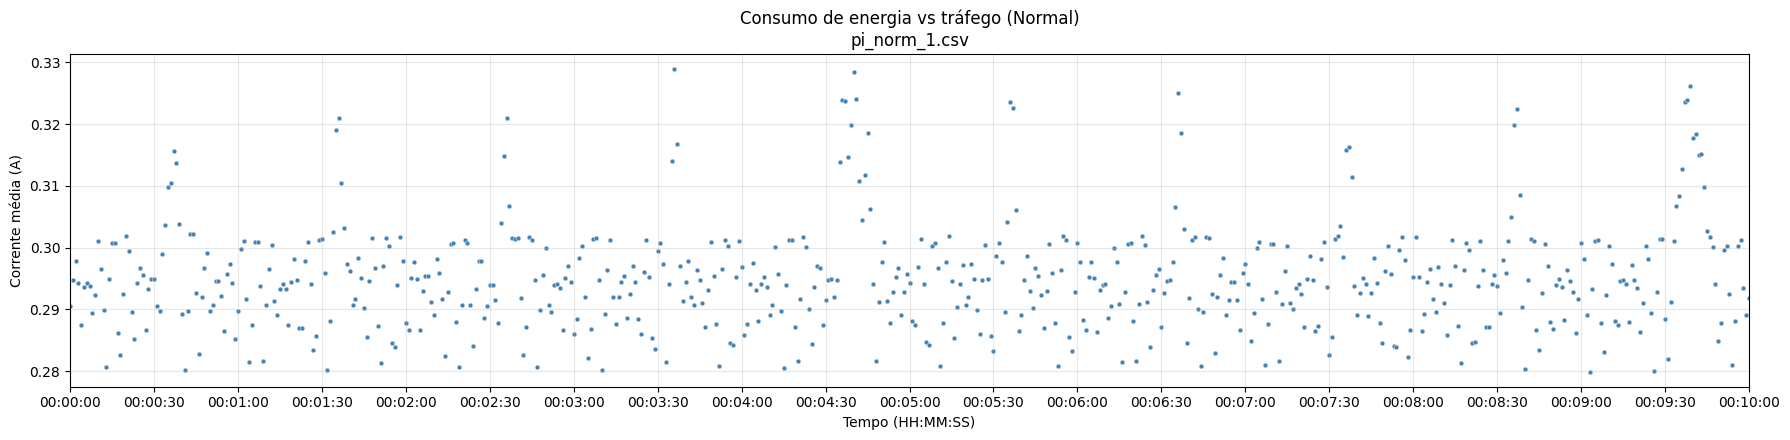

Processando pi_norm_2.csv...
pi_norm_2.csv — start: 2012-02-29 00:00:00 | end: 2012-02-29 00:10:00 | duration: 0 days 00:10:00


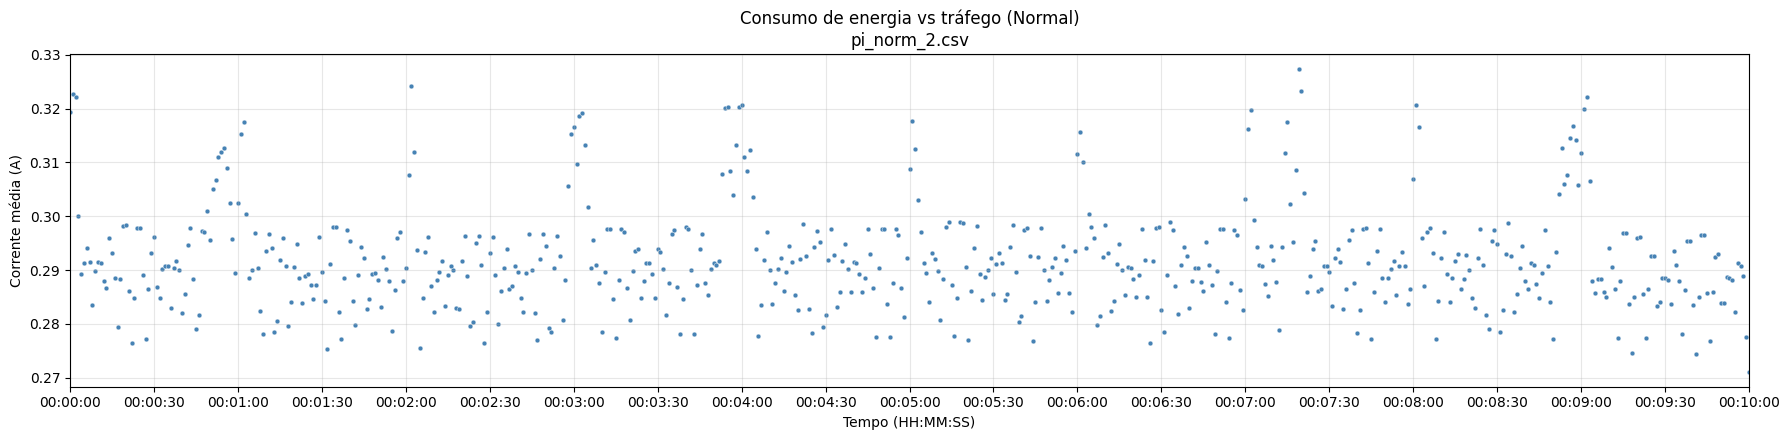

In [9]:
%matplotlib inline

PI_NORM_PATH = Path("dragon_pi/pi/pi_norm_large")
START_DATE = pd.to_datetime("2012-02-29 00:00:00")

for csv_file in sorted(PI_NORM_PATH.glob("*.csv")):
    if "_legend" in csv_file.name.lower():
        continue

    print(f"Processando {csv_file.name}...")

    df = pd.read_csv(csv_file, index_col=0)
    if "Time" not in df.columns or "Current" not in df.columns:
        continue

    start_sec = float(df["Time"].min())
    end_sec = float(df["Time"].max())
    start_dt = START_DATE + pd.to_timedelta(start_sec, unit="s")
    end_dt = START_DATE + pd.to_timedelta(end_sec, unit="s")
    duration_td = end_dt - start_dt
    print(f"{csv_file.name} — start: {start_dt} | end: {end_dt} | duration: {duration_td}")

    df["Datetime"] = pd.to_timedelta(df["Time"], unit="s") + START_DATE
    df = df.set_index("Datetime")

    df_sec = (
        df["Current"]
        .resample("1s").mean()
        .rolling(3, min_periods=1, center=True).mean()
        .rename("Corrente (A)")
        .reset_index()
    )

    fig, ax = plt.subplots(figsize=(18, 4.5))
    sns.scatterplot(
        data=df_sec,
        x="Datetime",
        y="Corrente (A)",
        color="steelblue",
        s=12,
        ax=ax
    )

    ax.xaxis.set_major_locator(mdates.SecondLocator(interval=30))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))

    xmin = start_dt.floor("s")
    xmax = xmin + pd.Timedelta(minutes=10)  
    ax.set_xlim(xmin, xmax)

    ax.set_title(f"Consumo de energia vs tráfego (Normal)\n{csv_file.name}")
    ax.set_xlabel("Tempo (HH:MM:SS)")
    ax.set_ylabel("Corrente média (A)")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


Processando dragon_norm_1.csv...
dragon_norm_1.csv — start: 2012-02-29 00:00:00 | end: 2012-02-29 00:14:59.999969280 | duration: 0 days 00:14:59.999969280


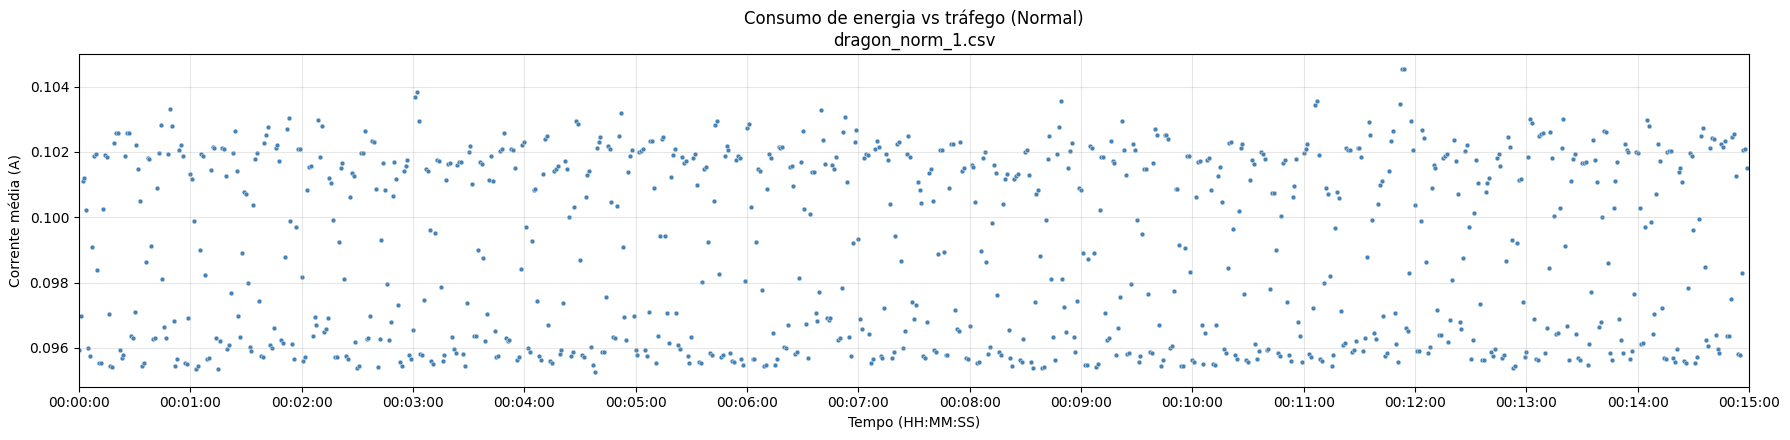

Processando dragon_norm_2.csv...
dragon_norm_2.csv — start: 2012-02-29 00:00:00 | end: 2012-02-29 00:14:59.999969280 | duration: 0 days 00:14:59.999969280


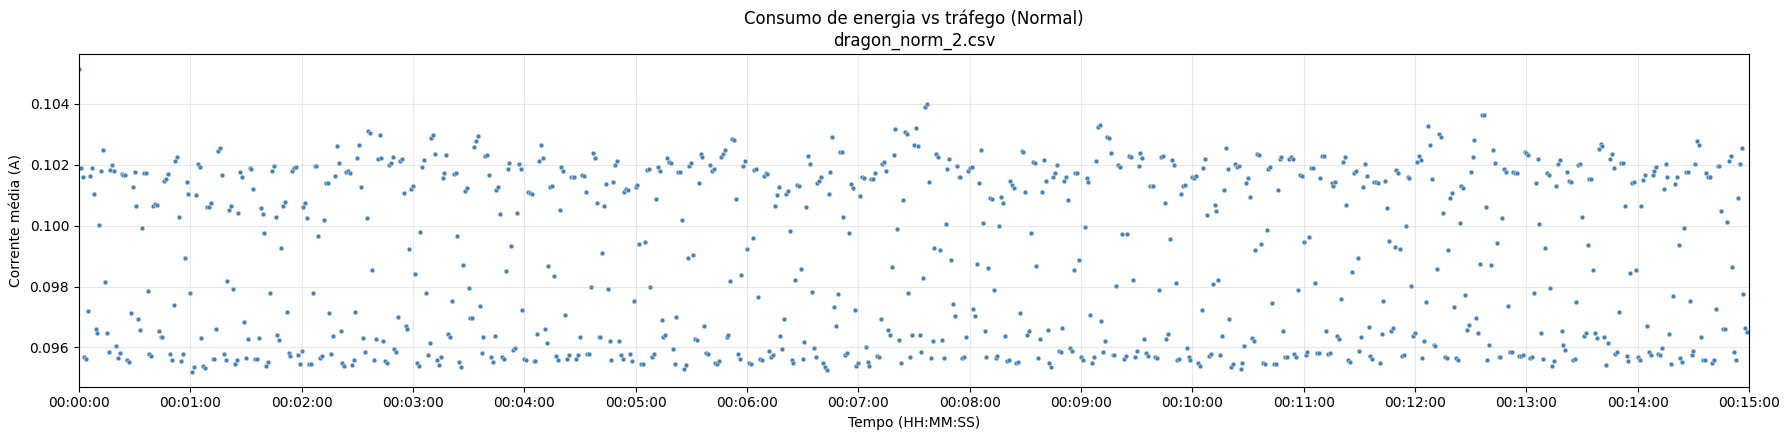

Processando dragon_norm_3.csv...
dragon_norm_3.csv — start: 2012-02-29 00:00:00 | end: 2012-02-29 00:14:59.999969280 | duration: 0 days 00:14:59.999969280


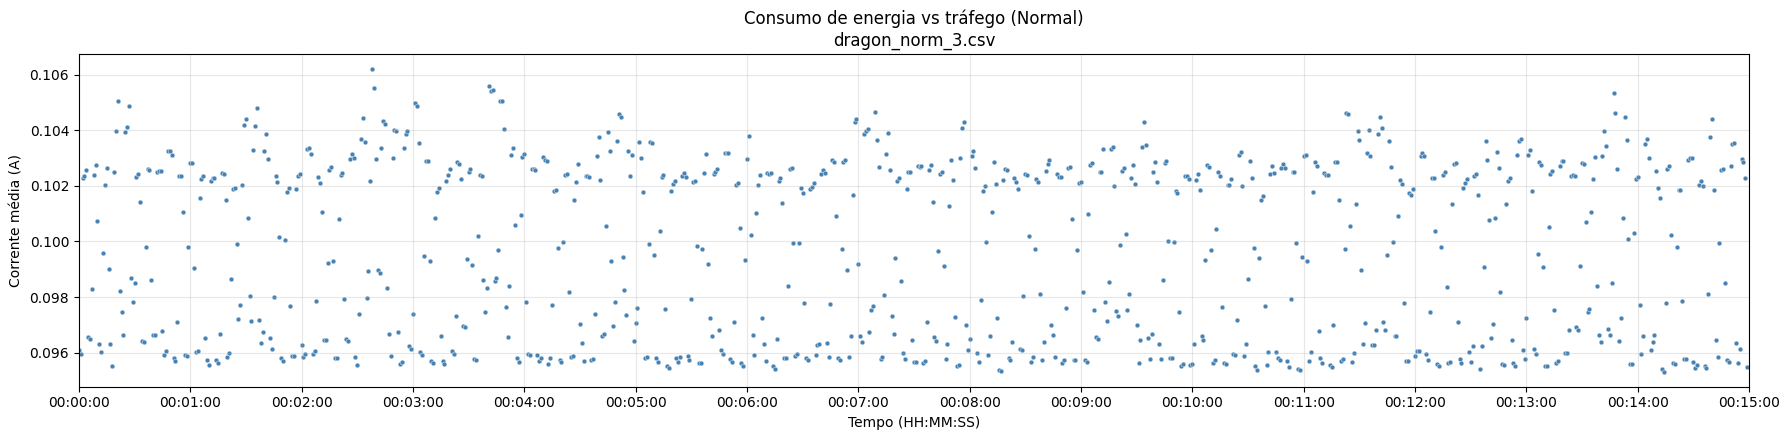

In [10]:
%matplotlib inline

DRAGON_NORM_PATH = Path("dragon_pi/dragon/dragon_norm_large")
START_DATE = pd.to_datetime("2012-02-29 00:00:00")

for csv_file in sorted(DRAGON_NORM_PATH.glob("*.csv")):
    if "_legend" in csv_file.name.lower():
        continue

    print(f"Processando {csv_file.name}...")

    df = pd.read_csv(csv_file, index_col=0)
    if "Time" not in df.columns or "Current" not in df.columns:
        continue

    start_sec = float(df["Time"].min())
    end_sec = float(df["Time"].max())
    start_dt = START_DATE + pd.to_timedelta(start_sec, unit="s")
    end_dt = START_DATE + pd.to_timedelta(end_sec, unit="s")
    duration_td = end_dt - start_dt
    print(f"{csv_file.name} — start: {start_dt} | end: {end_dt} | duration: {duration_td}")

    df["Datetime"] = pd.to_timedelta(df["Time"], unit="s") + START_DATE
    df = df.set_index("Datetime")

    df_sec = (
        df["Current"]
        .resample("1s").mean()
        .rolling(3, min_periods=1, center=True).mean()
        .rename("Corrente (A)")
        .reset_index()
    )

    fig, ax = plt.subplots(figsize=(18, 4.5))
    sns.scatterplot(
        data=df_sec,
        x="Datetime",
        y="Corrente (A)",
        color="steelblue",
        s=12,
        ax=ax
    )

    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))

    xmin = start_dt.floor("s")
    xmax = xmin + pd.Timedelta(minutes=15)  
    ax.set_xlim(xmin, xmax)

    ax.set_title(f"Consumo de energia vs tráfego (Normal)\n{csv_file.name}")
    ax.set_xlabel("Tempo (HH:MM:SS)")
    ax.set_ylabel("Corrente média (A)")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# ============================================================
# DRAGON_PORTSCAN_LARGE e PI_PORTSCAN_LARGE
# ============================================================



--- Port Scan Attack data (GB) ---
dragon_portscan_large    3.33
pi_portscan_large        5.27

--- Quantidade de arquivos ---
dragon_portscan_large    6
pi_portscan_large        9

--- Tamanhos reais dos subarquivos (Nmap / PortScan) ---
DRAGON  | dragon_nmap_t1.csv             |      0.518 GB
DRAGON  | dragon_nmap_t2.csv             |      0.518 GB
DRAGON  | dragon_nmap_t3_0.csv           |      0.823 GB
DRAGON  | dragon_nmap_t4.csv             |      0.490 GB
DRAGON  | dragon_nmap_t5_1.csv           |      0.489 GB
DRAGON  | dragon_nmap_t5_2.csv           |      0.489 GB
PI      | pi_nmap_t0_2.csv               |      0.605 GB
PI      | pi_nmap_t0_3.csv               |      0.605 GB
PI      | pi_nmap_t0_4.csv               |      0.580 GB
PI      | pi_nmap_t0_1.csv               |      0.580 GB
PI      | pi_nmap_t1.csv                 |      0.580 GB
PI      | pi_nmap_t2.csv                 |      0.509 GB
PI      | pi_nmap_t3.csv                 |      0.832 GB
PI      | pi_nmap_t

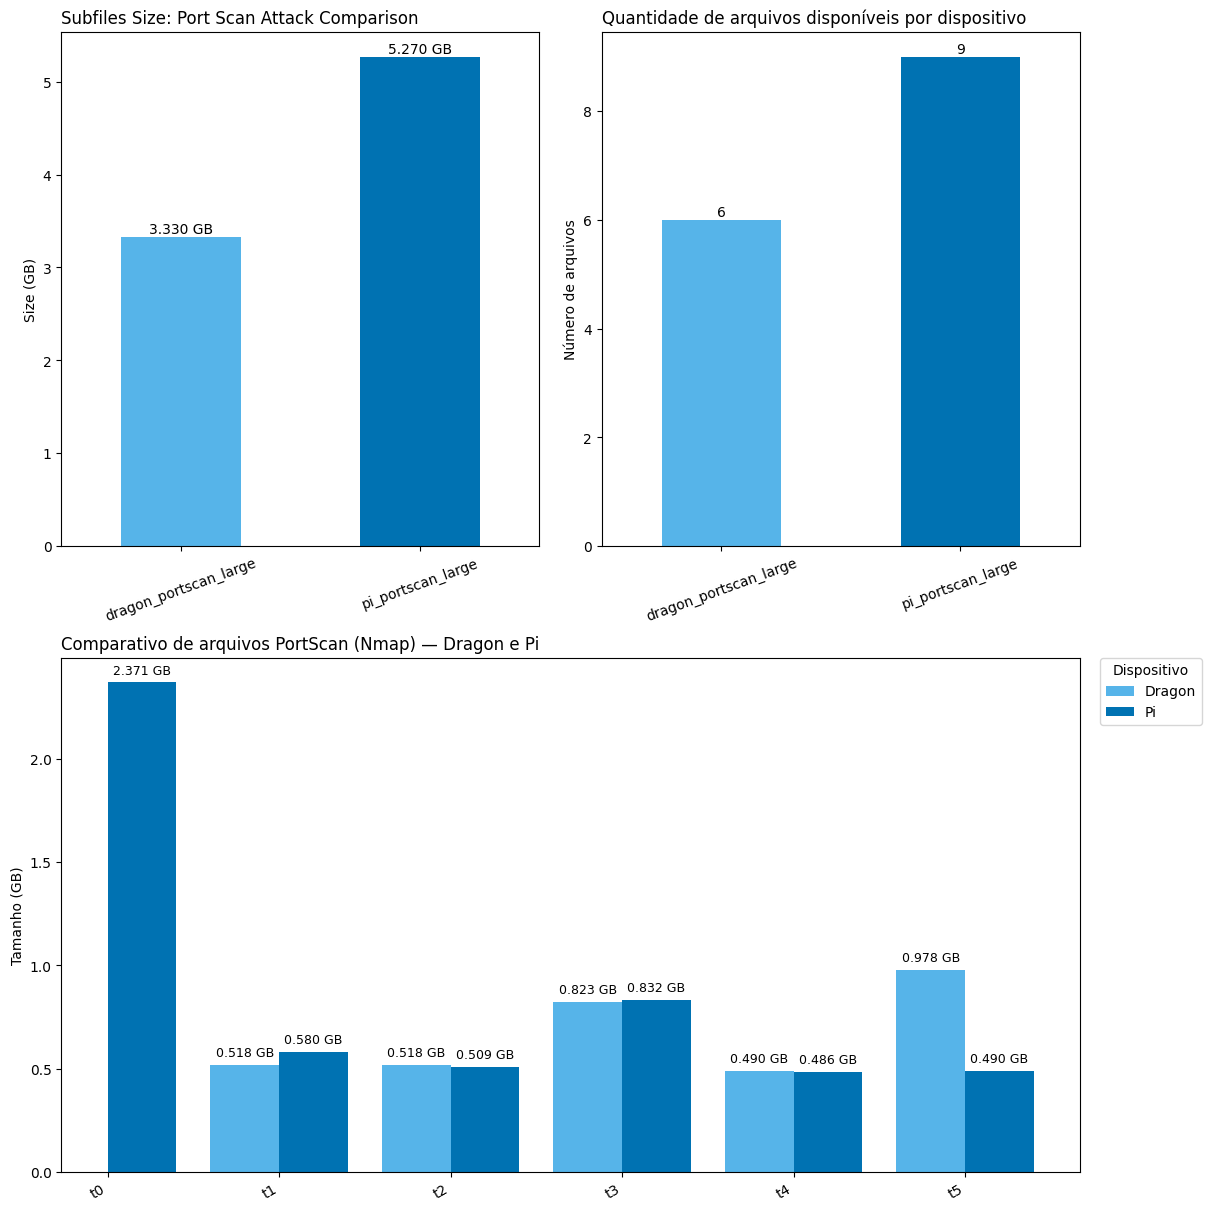

In [4]:
data_structure_text = """
📁 dragon
  📂 dragon_portscan_large
  └── subtotal dragon_portscan_large: 3.33 GB
📁 pi
  📂 pi_portscan_large
  └── subtotal pi_portscan_large: 5.27 GB
"""

fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])
ax00 = fig.add_subplot(gs[0, 0])   # Port Scan subtotal
ax01 = fig.add_subplot(gs[0, 1])   # Quantidade de arquivos
ax10 = fig.add_subplot(gs[1, :])   # Comparativo detalhado (ocupa as duas colunas)

# --- 1. Comparativo de tamanho total (subtotais) ---
pattern_bf = re.compile(r"subtotal\s+(dragon_portscan_large|pi_portscan_large):\s+([\d.]+)\s+(GB|MB)", re.IGNORECASE)
sizes_bf = {}
for line in data_structure_text.splitlines():
    m = pattern_bf.search(line)
    if m:
        name, size_str, unit = m.groups()
        size = float(size_str)
        if unit.upper() == "MB":
            size /= 1024.0
        sizes_bf[name] = size

if sizes_bf:
    df2 = pd.Series(sizes_bf, name="Size (GB)")
    print("\n--- Port Scan Attack data (GB) ---")
    print(df2.round(3).to_string())
    df2.plot(kind="bar", ax=ax00, color=["#56B4E9", "#0072B2"])
    ax00.set_title("Subfiles Size: Port Scan Attack Comparison", loc="left")
    ax00.set_ylabel("Size (GB)")
    ax00.tick_params(axis="x", rotation=20)
    for c in ax00.containers:
        ax00.bar_label(c, fmt="%.3f GB")
else:
    ax00.text(0.5, 0.5, "No data to plot", ha="center", va="center", fontsize=12)
    ax00.set_title("Subfiles Size: Port Scan Attack Comparison", loc="left")

# --- 2. Quantidade de arquivos ---
counts = pd.Series({"dragon_portscan_large": 6, "pi_portscan_large": 9})
print("\n--- Quantidade de arquivos ---")
print(counts.to_string())

counts.plot(kind="bar", color=["#56B4E9", "#0072B2"], ax=ax01)
ax01.set_title("Quantidade de arquivos disponíveis por dispositivo", loc="left")
ax01.set_ylabel("Número de arquivos")
ax01.tick_params(axis='x', rotation=20)
for c in ax01.containers:
    ax01.bar_label(c)

# --- 3. Comparativo arquivos PortScan (Nmap) — Dragon vs Pi (em GB) ---
BASE_DIR = Path("./dragon_pi").expanduser()
EXCLUDE_SUBSTR = "_legend"
DEVICE_KEYS = ["dragon", "pi"]

entries = []
if BASE_DIR.exists():
    for portscan_dir in BASE_DIR.rglob("*portscan*"):
        if portscan_dir.is_dir():
            for f in portscan_dir.rglob("*.csv"):
                if EXCLUDE_SUBSTR in f.stem.lower():
                    continue
                entries.append(f)
    for nmap_dir in BASE_DIR.rglob("*nmap*"):
        if nmap_dir.is_dir():
            for f in nmap_dir.rglob("*.csv"):
                if EXCLUDE_SUBSTR in f.stem.lower():
                    continue
                entries.append(f)

rows = []
for f in entries:
    nlow = f.stem.lower()
    dev = "dragon" if "dragon" in nlow else ("pi" if "pi" in nlow else None)
    if dev not in DEVICE_KEYS:
        continue
    m = re.search(r"_t(\d+)", nlow)
    file_id = int(m.group(1)) if m else None
    if file_id is None:
        continue
    try:
        size_gb = f.stat().st_size / (1024 ** 3)
    except OSError:
        continue
    rows.append((file_id, dev, f.name, size_gb))

print("\n--- Tamanhos reais dos subarquivos (Nmap / PortScan) ---")
for e in sorted(rows, key=lambda x: (x[1], x[0])):
    print(f"{e[1].upper():7s} | {e[2]:30s} | {e[3]:10.3f} GB")

df = pd.DataFrame(rows, columns=["id", "device", "file", "size_GB"])
df = df.sort_values("id")

pv = df.pivot_table(index="id", columns="device", values="size_GB", aggfunc="sum")

if not pv.empty:
    labels = [f"t{i}" for i in pv.index.tolist()]
    x = np.arange(len(labels))
    width = 0.4

    y_dragon = pv.get("dragon", pd.Series([0]*len(labels), index=pv.index)).values
    y_pi     = pv.get("pi",     pd.Series([0]*len(labels), index=pv.index)).values

    b1 = ax10.bar(x - width/2, y_dragon, width, label="Dragon", color="#56B4E9")
    b2 = ax10.bar(x + width/2, y_pi,     width, label="Pi", color="#0072B2")

    ax10.set_ylabel("Tamanho (GB)")
    ax10.set_title("Comparativo de arquivos PortScan (Nmap) — Dragon e Pi", loc="left")
    ax10.set_xticks(x)
    ax10.set_xticklabels(labels, rotation=30, ha="right")
    ax10.legend(title="Dispositivo", loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0)

    for bar in list(b1) + list(b2):
        h = bar.get_height()
        if h > 0:
            ax10.annotate(f"{h:.3f} GB",
                          xy=(bar.get_x() + bar.get_width()/2, h),
                          xytext=(0, 4), textcoords="offset points",
                          ha="center", va="bottom", fontsize=9)
else:
    ax10.text(0.5, 0.5, "Nenhum arquivo válido encontrado para PortScan (Nmap).", ha="center", va="center")

plt.show()

In [17]:

PI_PORTSCAN_PATH = Path("dragon_pi/pi/pi_portscan_large")

for csv_file in sorted(PI_PORTSCAN_PATH.glob("pi_nmap_*.csv")):
    if "_legend" in csv_file.name.lower():
        continue

    print(f"\n=== {csv_file.name} ===")
    dataset = pd.read_csv(csv_file, index_col=0)

    not_normal = dataset[
        (dataset["anno_string"] != "Normal") |
        (dataset["anno_type"] != "Normal") |
        (dataset["anno_specific"] != "Normal")
    ]

    print("Dimensões do conjunto original:", dataset.shape)
    print("Linhas com anomalias:", not_normal.shape)

    print("\nTipos de valores diferentes de 'Normal':")
    print(not_normal[["anno_string", "anno_type", "anno_specific"]].drop_duplicates())

    print("\nAmostra de ataques/anomalias:")
    display(not_normal.head(10))


=== pi_nmap_t0_1.csv ===
Dimensões do conjunto original: (8789063, 5)
Linhas com anomalias: (5859360, 5)

Tipos de valores diferentes de 'Normal':
        anno_string               anno_type anno_specific
1464840     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T0

Amostra de ataques/anomalias:


Time   Current anno_string               anno_type anno_specific
1464840  29.999923  0.267420     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T0
1464841  29.999944  0.267332     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T0
1464842  29.999964  0.267303     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T0
1464843  29.999985  0.267332     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T0
1464844  30.000005  0.267450     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T0
1464845  30.000026  0.267685     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T0
1464846  30.000046  0.267979     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T0
1464847  30.000067  0.268508     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T0
1464848  30.000087  0.269362     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T0
1464849  30.000108  0.270715     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T0


=== pi_nmap_t0_2.csv ===
Dimensões do conjunto original: (8789063, 5)
Linhas com anomalias: (7324200, 5)

Tipos de valores diferentes de 'Normal':
        anno_string               anno_type anno_specific
1464840     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T0

Amostra de ataques/anomalias:


Time   Current anno_string               anno_type anno_specific
1464840  29.999923  0.264346     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T0
1464841  29.999944  0.264229     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T0
1464842  29.999964  0.264111     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T0
1464843  29.999985  0.264023     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T0
1464844  30.000005  0.264023     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T0
1464845  30.000026  0.264052     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T0
1464846  30.000046  0.264081     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T0
1464847  30.000067  0.264140     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T0
1464848  30.000087  0.264140     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T0
1464849  30.000108  0.264111     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T0


=== pi_nmap_t0_3.csv ===
Dimensões do conjunto original: (8789063, 5)
Linhas com anomalias: (7324200, 5)

Tipos de valores diferentes de 'Normal':
  anno_string               anno_type anno_specific
0     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T0

Amostra de ataques/anomalias:


Time   Current anno_string               anno_type anno_specific
0  0.000000  0.326246     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T0
1  0.000020  0.326216     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T0
2  0.000041  0.326275     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T0
3  0.000061  0.326334     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T0
4  0.000082  0.326363     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T0
5  0.000102  0.326452     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T0
6  0.000123  0.326569     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T0
7  0.000143  0.326628     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T0
8  0.000164  0.326804     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T0
9  0.000184  0.327040     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T0


=== pi_nmap_t0_4.csv ===
Dimensões do conjunto original: (8789063, 5)
Linhas com anomalias: (5859360, 5)

Tipos de valores diferentes de 'Normal':
        anno_string               anno_type anno_specific
1464840     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T0

Amostra de ataques/anomalias:


Time   Current anno_string               anno_type anno_specific
1464840  29.999923  0.285883     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T0
1464841  29.999944  0.285412     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T0
1464842  29.999964  0.284677     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T0
1464843  29.999985  0.283735     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T0
1464844  30.000005  0.282765     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T0
1464845  30.000026  0.281912     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T0
1464846  30.000046  0.281470     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T0
1464847  30.000067  0.281470     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T0
1464848  30.000087  0.281912     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T0
1464849  30.000108  0.282765     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T0


=== pi_nmap_t1.csv ===
Dimensões do conjunto original: (8789063, 5)
Linhas com anomalias: (5859360, 5)

Tipos de valores diferentes de 'Normal':
        anno_string               anno_type anno_specific
1464840     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T1

Amostra de ataques/anomalias:


Time   Current anno_string               anno_type anno_specific
1464840  29.999923  0.317712     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T1
1464841  29.999944  0.317094     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T1
1464842  29.999964  0.316624     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T1
1464843  29.999985  0.316388     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T1
1464844  30.000005  0.316506     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T1
1464845  30.000026  0.317065     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T1
1464846  30.000046  0.317977     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T1
1464847  30.000067  0.319183     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T1
1464848  30.000087  0.320330     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T1
1464849  30.000108  0.321213     Anomaly  Port_Scan(IDS_Evasion)       Nmap_T1


=== pi_nmap_t2.csv ===
Dimensões do conjunto original: (8789063, 5)
Linhas com anomalias: (5839829, 5)

Tipos de valores diferentes de 'Normal':
        anno_string  anno_type anno_specific
1582027     Anomaly  Port_Scan       Nmap_T2

Amostra de ataques/anomalias:


Time   Current anno_string  anno_type anno_specific
1582027  32.399913  0.267802     Anomaly  Port_Scan       Nmap_T2
1582028  32.399933  0.267508     Anomaly  Port_Scan       Nmap_T2
1582029  32.399954  0.267125     Anomaly  Port_Scan       Nmap_T2
1582030  32.399974  0.266713     Anomaly  Port_Scan       Nmap_T2
1582031  32.399995  0.266390     Anomaly  Port_Scan       Nmap_T2
1582032  32.400015  0.266007     Anomaly  Port_Scan       Nmap_T2
1582033  32.400036  0.265625     Anomaly  Port_Scan       Nmap_T2
1582034  32.400056  0.265360     Anomaly  Port_Scan       Nmap_T2
1582035  32.400077  0.265301     Anomaly  Port_Scan       Nmap_T2
1582036  32.400097  0.265242     Anomaly  Port_Scan       Nmap_T2


=== pi_nmap_t3.csv ===
Dimensões do conjunto original: (14648438, 5)
Linhas com anomalias: (4316394, 5)

Tipos de valores diferentes de 'Normal':
        anno_string  anno_type anno_specific
1489254     Anomaly  Port_Scan       Nmap_T3

Amostra de ataques/anomalias:


Time   Current anno_string  anno_type anno_specific
1489254  30.499922  0.269426     Anomaly  Port_Scan       Nmap_T3
1489255  30.499942  0.269661     Anomaly  Port_Scan       Nmap_T3
1489256  30.499963  0.269867     Anomaly  Port_Scan       Nmap_T3
1489257  30.499983  0.270103     Anomaly  Port_Scan       Nmap_T3
1489258  30.500004  0.270279     Anomaly  Port_Scan       Nmap_T3
1489259  30.500024  0.270250     Anomaly  Port_Scan       Nmap_T3
1489260  30.500045  0.270191     Anomaly  Port_Scan       Nmap_T3
1489261  30.500065  0.270073     Anomaly  Port_Scan       Nmap_T3
1489262  30.500086  0.269956     Anomaly  Port_Scan       Nmap_T3
1489263  30.500106  0.269897     Anomaly  Port_Scan       Nmap_T3


=== pi_nmap_t4.csv ===
Dimensões do conjunto original: (8789063, 5)
Linhas com anomalias: (820311, 5)

Tipos de valores diferentes de 'Normal':
        anno_string  anno_type anno_specific
1508785     Anomaly  Port_Scan       Nmap_T4

Amostra de ataques/anomalias:


Time   Current anno_string  anno_type anno_specific
1508785  30.899917  0.264755     Anomaly  Port_Scan       Nmap_T4
1508786  30.899937  0.264608     Anomaly  Port_Scan       Nmap_T4
1508787  30.899958  0.264579     Anomaly  Port_Scan       Nmap_T4
1508788  30.899978  0.264550     Anomaly  Port_Scan       Nmap_T4
1508789  30.899999  0.264461     Anomaly  Port_Scan       Nmap_T4
1508790  30.900019  0.264344     Anomaly  Port_Scan       Nmap_T4
1508791  30.900040  0.264373     Anomaly  Port_Scan       Nmap_T4
1508792  30.900060  0.264403     Anomaly  Port_Scan       Nmap_T4
1508793  30.900081  0.264432     Anomaly  Port_Scan       Nmap_T4
1508794  30.900101  0.264520     Anomaly  Port_Scan       Nmap_T4


=== pi_nmap_t5.csv ===
Dimensões do conjunto original: (8789063, 5)
Linhas com anomalias: (1005857, 5)

Tipos de valores diferentes de 'Normal':
        anno_string  anno_type anno_specific
1513668     Anomaly  Port_Scan       Nmap_T5

Amostra de ataques/anomalias:


Time   Current anno_string  anno_type anno_specific
1513668  30.999921  0.261254     Anomaly  Port_Scan       Nmap_T5
1513669  30.999941  0.261224     Anomaly  Port_Scan       Nmap_T5
1513670  30.999962  0.261195     Anomaly  Port_Scan       Nmap_T5
1513671  30.999982  0.261077     Anomaly  Port_Scan       Nmap_T5
1513672  31.000003  0.260989     Anomaly  Port_Scan       Nmap_T5
1513673  31.000023  0.261018     Anomaly  Port_Scan       Nmap_T5
1513674  31.000044  0.261165     Anomaly  Port_Scan       Nmap_T5
1513675  31.000064  0.261254     Anomaly  Port_Scan       Nmap_T5
1513676  31.000084  0.261254     Anomaly  Port_Scan       Nmap_T5
1513677  31.000105  0.261195     Anomaly  Port_Scan       Nmap_T5

In [20]:
pd.set_option("display.float_format", lambda x: f"{x:.6f}")

def rms(x: pd.Series) -> float:
    return float(np.sqrt(np.mean(np.square(x)))) if len(x) > 0 else np.nan

def stats_from_series(s: pd.Series) -> dict:
    return {
        "mean_current": float(s.mean()),
        "std_current": float(s.std(ddof=0)),
        "rms_current": rms(s),
        "max_current": float(s.max()),
        "min_current": float(s.min()),
        "amp_current": float(s.max() - s.min())
    }

all_stats = []

for csv_path in tqdm(sorted(PI_PORTSCAN_PATH.glob("*.csv"))):
    if "_legend" in csv_path.name.lower():
        continue

    try:
        df = pd.read_csv(csv_path, usecols=["Time", "Current"])
    except Exception as e:
        print(f"[ERRO] Falha ao ler {csv_path.name}: {e}")
        continue

    df["Current"] = pd.to_numeric(df["Current"], errors="coerce")
    df = df.dropna(subset=["Current"])
    df = df[np.isfinite(df["Current"])]
    df = df[df["Current"].between(0, 5)]

    if df.empty:
        print(f"[AVISO] {csv_path.name} ficou vazio após limpeza.")
        continue

    s = df["Current"]
    stats = stats_from_series(s)
    stats["std_current"] = float(np.std(s, ddof=0))
    stats["source_file"] = csv_path.name
    all_stats.append(stats)

df_all = pd.DataFrame(all_stats)

print(f"Arquivos processados: {len(df_all)}\n")
display(df_all)


100%|██████████| 18/18 [00:56<00:00,  3.15s/it]

Arquivos processados: 9



mean_current  std_current  rms_current  max_current  min_current  \
0      0.288287     0.026229     0.289478     0.600120     0.244063   
1      0.287078     0.025976     0.288251     0.620697     0.243637   
2      0.290157     0.026606     0.291375     0.618204     0.244380   
3      0.288776     0.025850     0.289931     0.589549     0.244170   
4      0.290797     0.026840     0.292033     0.567958     0.244053   
5      0.304161     0.026819     0.305341     0.651804     0.244416   
6      0.300787     0.035741     0.302903     0.808777     0.248570   
7      0.295891     0.030731     0.297482     0.678174     0.243958   
8      0.294950     0.031320     0.296608     0.669613     0.000000   

   amp_current       source_file  
0     0.356057  pi_nmap_t0_1.csv  
1     0.377060  pi_nmap_t0_2.csv  
2     0.373824  pi_nmap_t0_3.csv  
3     0.345379  pi_nmap_t0_4.csv  
4     0.323905    pi_nmap_t1.csv  
5     0.407389    pi_nmap_t2.csv  
6     0.560207    pi_nmap_t3.csv  
7     0.434216    pi_nmap_t4.csv  
8     0.669613    pi_nmap_t5.csv

In [ ]:
results = []

for csv_file in sorted(PI_PORTSCAN_PATH.glob("*.csv")):
    if "_legend" in csv_file.name.lower():
        continue

    try:
        df = pd.read_csv(csv_file)
        if "Time" not in df.columns:
            continue

        start = pd.to_timedelta(df["Time"].min(), unit="s")
        end = pd.to_timedelta(df["Time"].max(), unit="s")
        duration = (end - start)

        results.append({
            "Arquivo": csv_file.name,
            "Tamanho (MB)": round(csv_file.stat().st_size / (1024 ** 2), 2),
            "Início": str(start),
            "Fim": str(end),
            "Duração (h)": round(duration.total_seconds() / 3600, 2)
        })
    except Exception as e:
        print(f"Erro ao processar {csv_file.name}: {e}")

df_summary = pd.DataFrame(results)
print(df_summary)


            Arquivo  Tamanho (MB)           Início                        Fim  \
0  pi_nmap_t0_1.csv        594.32  0 days 00:00:00  0 days 00:02:59.999989760   
1  pi_nmap_t0_2.csv        619.46  0 days 00:00:00  0 days 00:02:59.999989760   
2  pi_nmap_t0_3.csv        619.45  0 days 00:00:00  0 days 00:02:59.999989760   
3  pi_nmap_t0_4.csv        594.34  0 days 00:00:00  0 days 00:02:59.999989760   
4    pi_nmap_t1.csv        594.30  0 days 00:00:00  0 days 00:02:59.999989760   
5    pi_nmap_t2.csv        521.56  0 days 00:00:00  0 days 00:02:59.999989760   
6    pi_nmap_t3.csv        852.04  0 days 00:00:00  0 days 00:04:59.999989760   
7    pi_nmap_t4.csv        497.60  0 days 00:00:00  0 days 00:02:59.999989760   
8    pi_nmap_t5.csv        501.95  0 days 00:00:00  0 days 00:02:59.999989760   

   Duração (h)  
0         0.05  
1         0.05  
2         0.05  
3         0.05  
4         0.05  
5         0.05  
6         0.08  
7         0.05  
8         0.05  


pi_nmap_t0_1.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:02:59.999989760 (duration: 0 days 00:02:59.999989760)


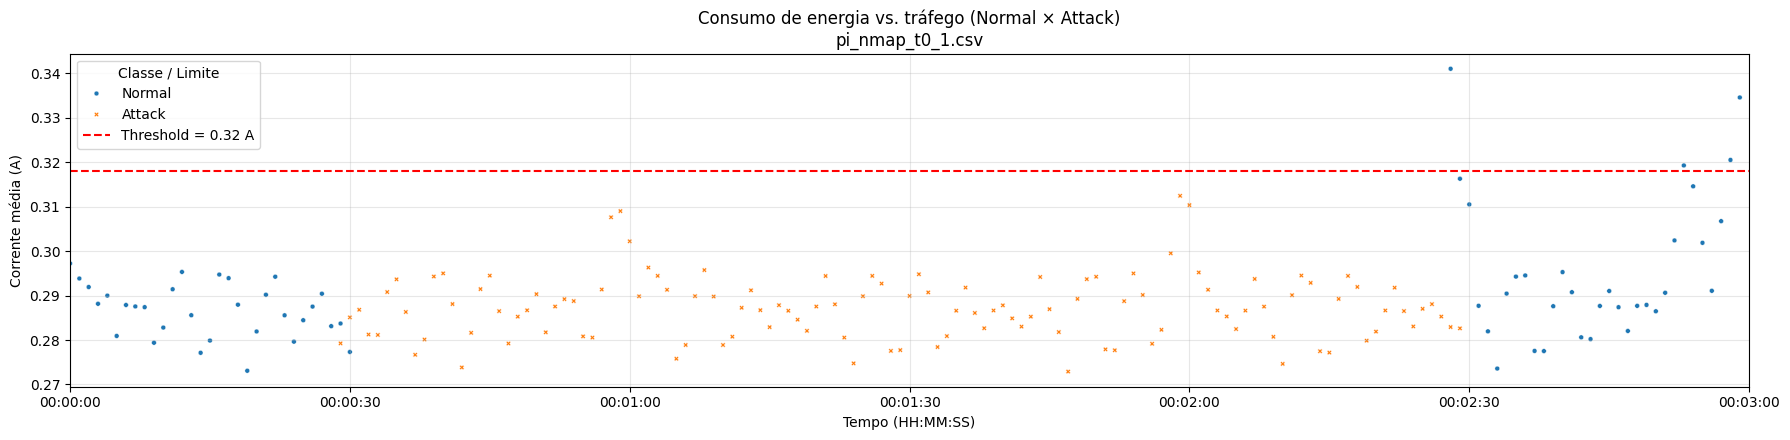

pi_nmap_t0_2.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:02:59.999989760 (duration: 0 days 00:02:59.999989760)


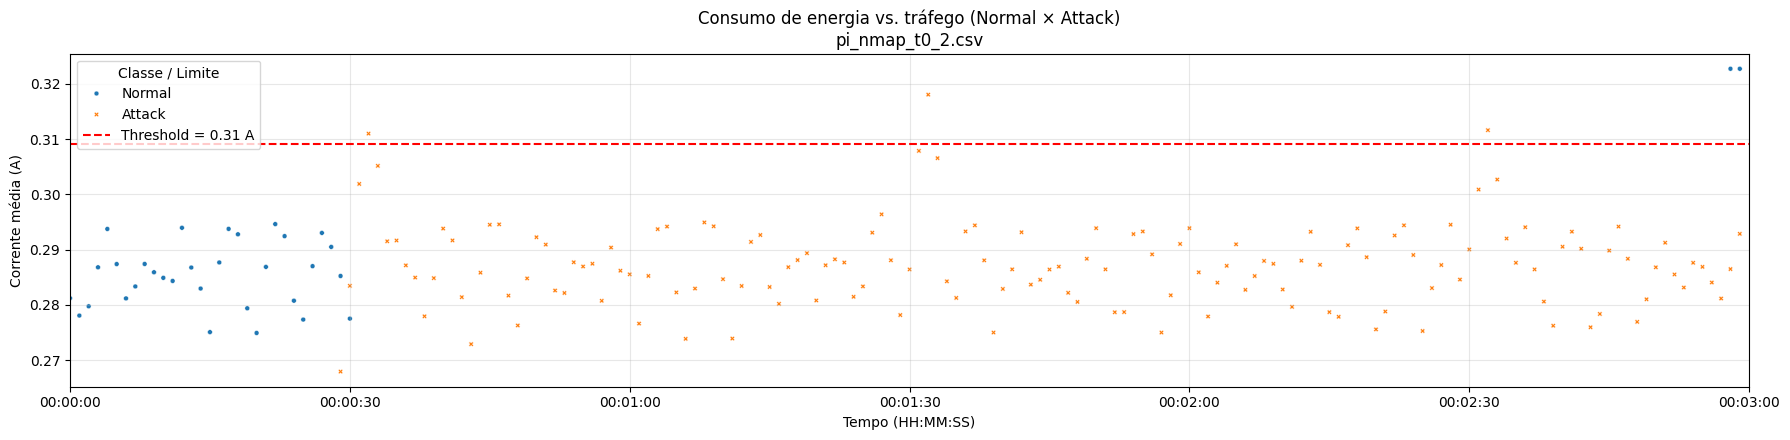

pi_nmap_t0_3.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:02:59.999989760 (duration: 0 days 00:02:59.999989760)


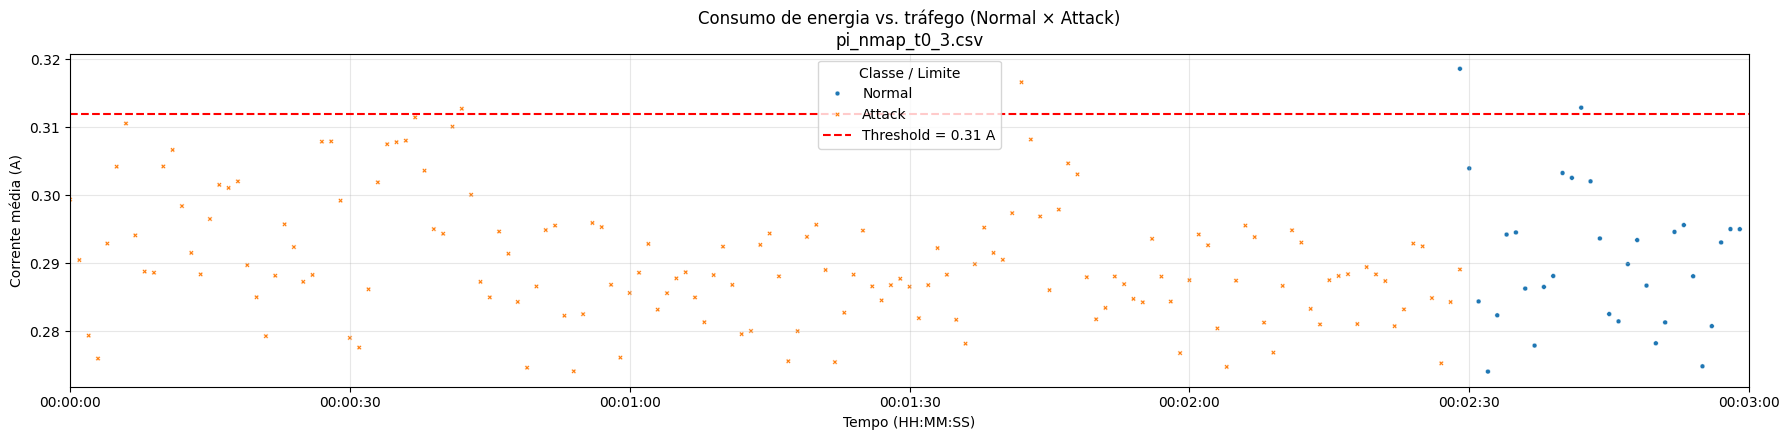

pi_nmap_t0_4.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:02:59.999989760 (duration: 0 days 00:02:59.999989760)


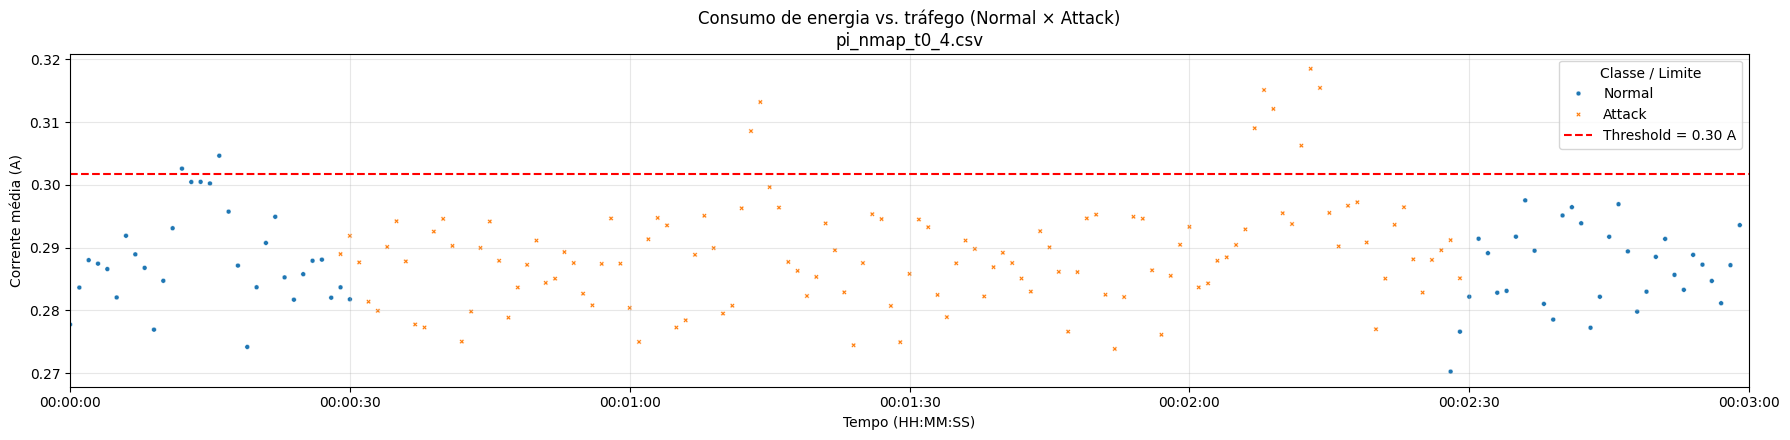

pi_nmap_t1.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:02:59.999989760 (duration: 0 days 00:02:59.999989760)


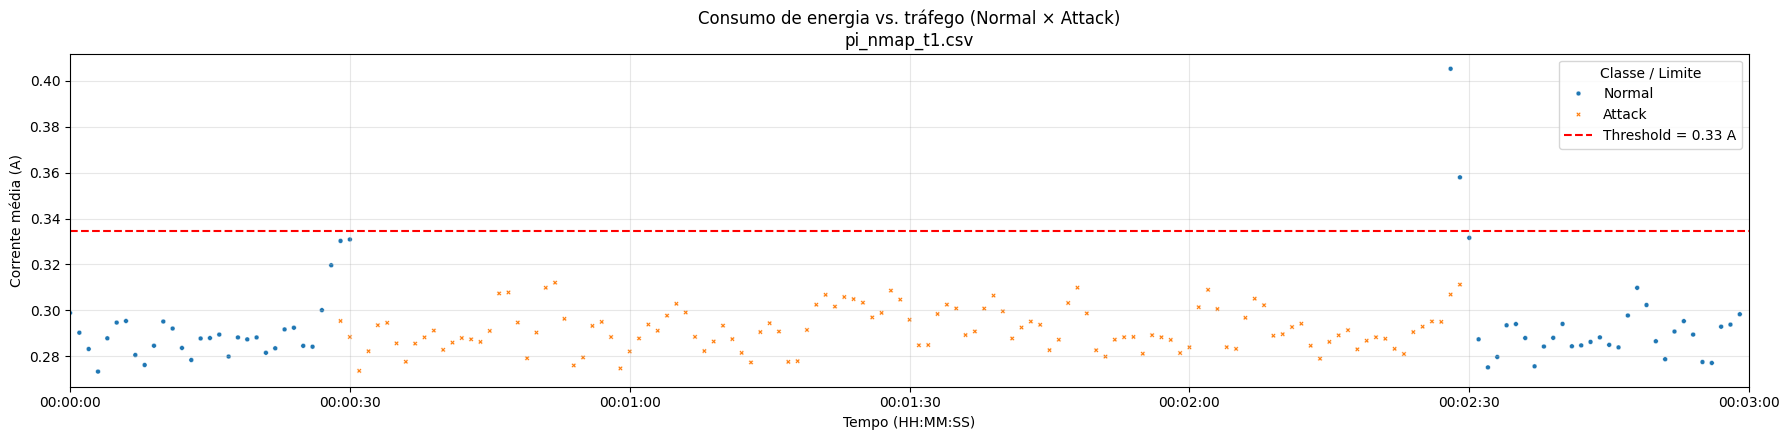

pi_nmap_t2.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:02:59.999989760 (duration: 0 days 00:02:59.999989760)


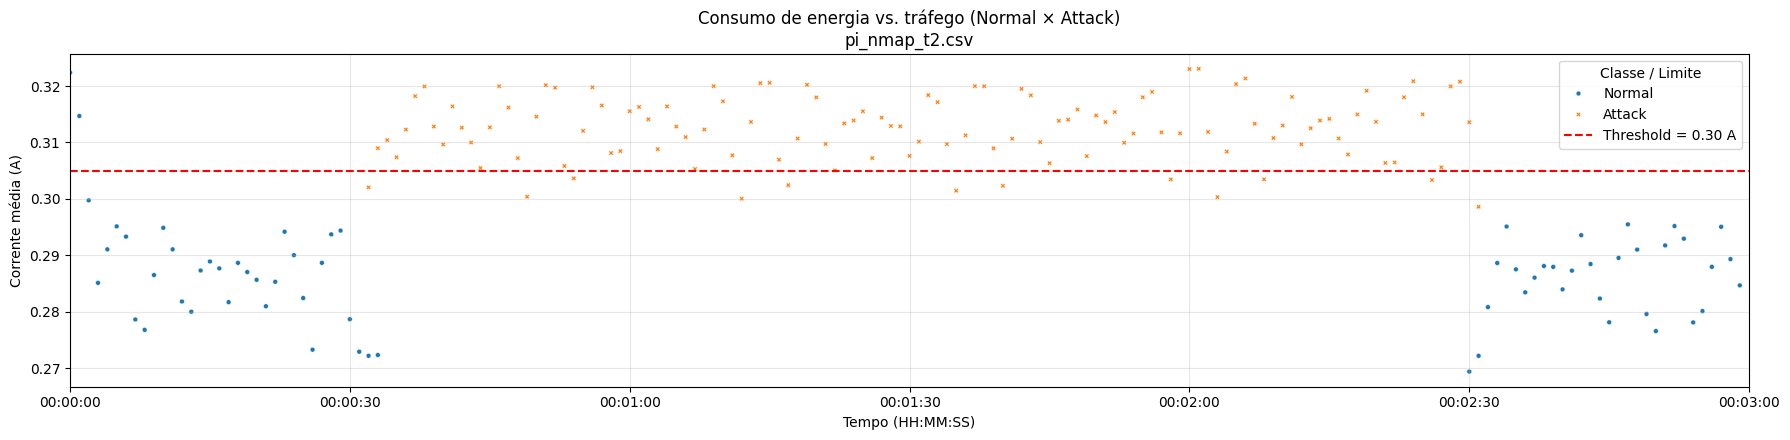

pi_nmap_t3.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:04:59.999989760 (duration: 0 days 00:04:59.999989760)


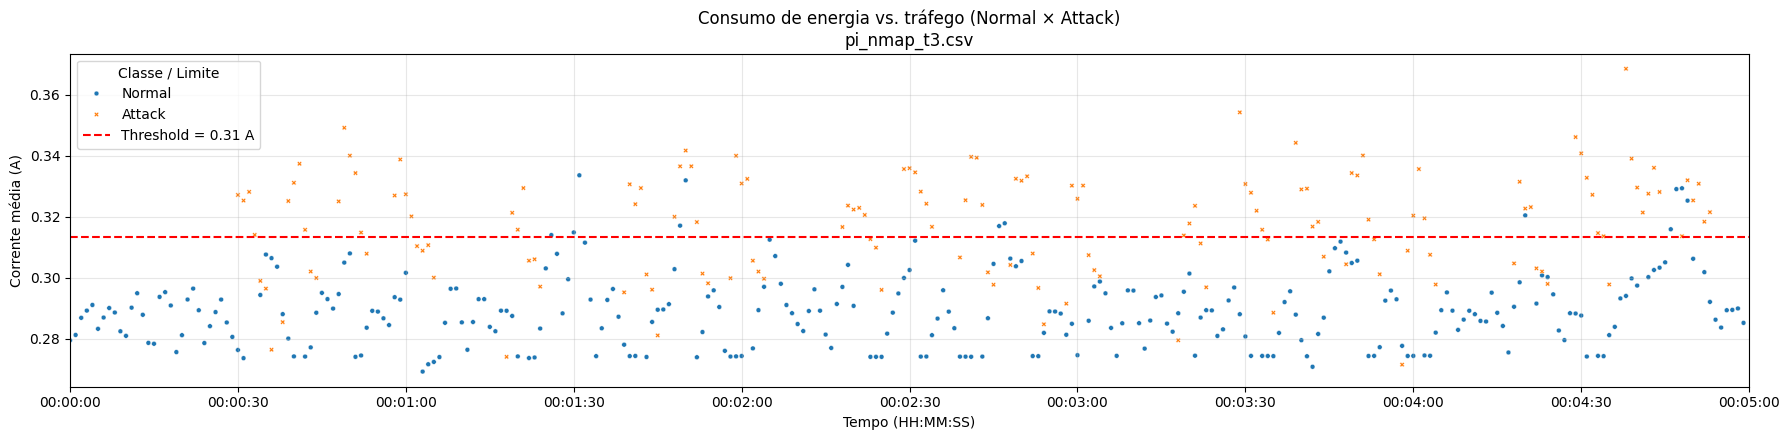

pi_nmap_t4.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:02:59.999989760 (duration: 0 days 00:02:59.999989760)


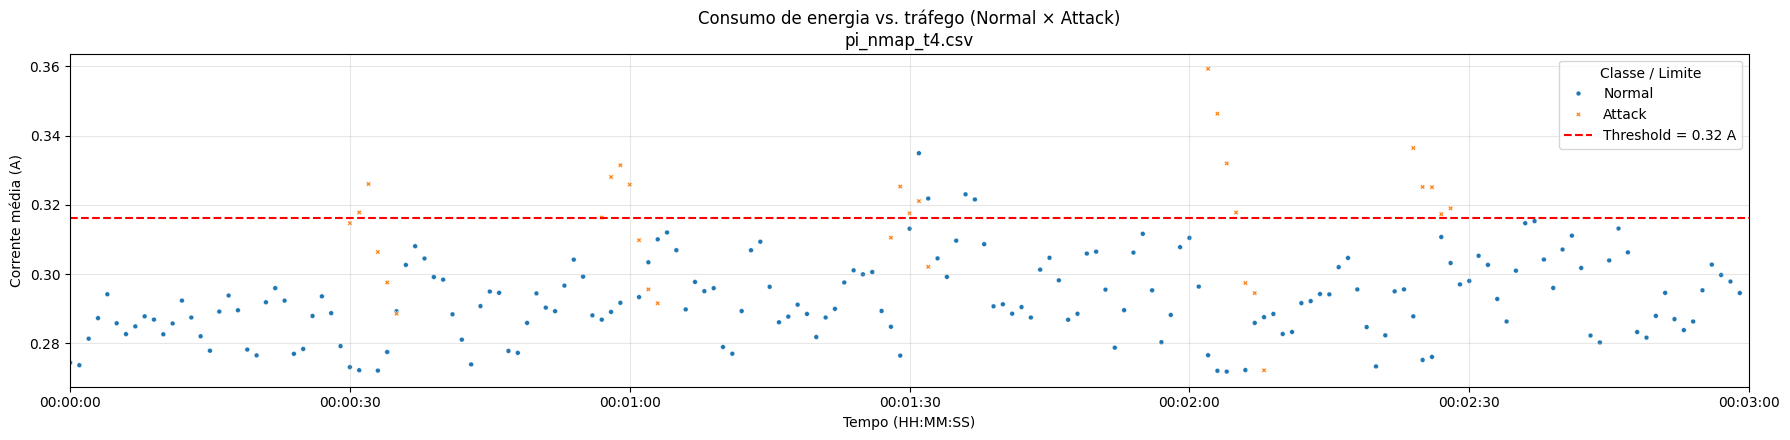

pi_nmap_t5.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:02:59.999989760 (duration: 0 days 00:02:59.999989760)


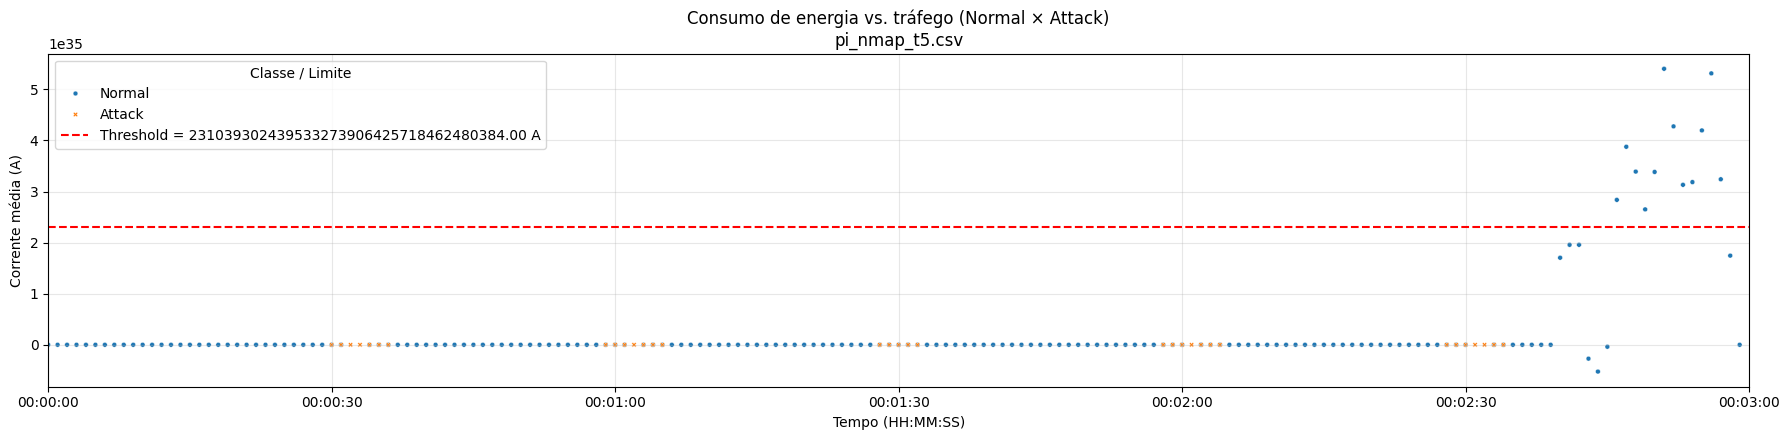

In [17]:
START_DATE = pd.to_datetime("2012-02-29 00:00:00")

for csv_file in sorted(PI_PORTSCAN_PATH.glob("*.csv")):
    if "_legend" in csv_file.name.lower():
        continue

    df = pd.read_csv(csv_file)

    if "Time" not in df.columns:
        continue

    start_td = pd.to_timedelta(df["Time"].min(), unit="s")
    end_td = pd.to_timedelta(df["Time"].max(), unit="s")
    duration_td = end_td - start_td

    print(f"{csv_file.name} — Starts at {start_td} and ends at {end_td} (duration: {duration_td})")

    df = df.set_index("Time")
    df["Datetime"] = pd.to_timedelta(df.index, unit="s") + START_DATE
    df = df.set_index("Datetime")

    for col in ["anno_string", "anno_type", "anno_specific"]:
        if col not in df.columns:
            df[col] = "Normal"

    df["is_attack"] = ~(
        (df["anno_string"].astype(str).str.lower() == "normal")
        & (df["anno_type"].astype(str).str.lower() == "normal")
        & (df["anno_specific"].astype(str).str.lower() == "normal")
    )

    df_sec = (
        df[["Current", "is_attack"]]
        .groupby("is_attack")["Current"]
        .resample("1s")
        .mean()
        .rename("Corrente (A)")
        .reset_index()
    )

    df_sec["Corrente (A)"] = (
        df_sec.groupby("is_attack")["Corrente (A)"]
        .transform(lambda s: s.rolling(3, min_periods=1, center=True).mean())
    )
    df_sec["classe"] = df_sec["is_attack"].map({False: "Normal", True: "Attack"})

    fig, ax = plt.subplots(figsize=(18, 4.5))
    sns.scatterplot(
        data=df_sec,
        x="Datetime",
        y="Corrente (A)",
        hue="classe",
        style="classe",
        s=12,
        ax=ax
    )

    xmin = df.index.min().floor("s")
    xmax = df.index.max().ceil("s")
    ax.set_xlim(xmin, xmax)

    ax.xaxis.set_major_locator(mdates.SecondLocator(interval=30))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))

    ax.set_title(f"Consumo de energia vs. tráfego (Normal × Attack)\n{csv_file.name}")
    ax.set_xlabel("Tempo (HH:MM:SS)")
    ax.set_ylabel("Corrente média (A)")
    ax.grid(True, alpha=0.3)

    threshold = df_sec.loc[df_sec["classe"] == "Normal", "Corrente (A)"].mean() \
             + 2 * df_sec.loc[df_sec["classe"] == "Normal", "Corrente (A)"].std()

    ax.axhline(y=threshold, color="red", linestyle="--", label=f"Threshold = {threshold:.2f} A")
    ax.legend(title="Classe / Limite")

    plt.tight_layout()
    plt.show()


In [21]:

DRAGON_PORTSCAN_PATH = Path("dragon_pi/dragon/dragon_portscan_large")

for csv_file in sorted(DRAGON_PORTSCAN_PATH.glob("dragon_nmap_*.csv")):
    if "_legend" in csv_file.name.lower():
        continue

    print(f"\n=== {csv_file.name} ===")
    dataset = pd.read_csv(csv_file, index_col=0)

    not_normal = dataset[
        (dataset["anno_string"] != "Normal") |
        (dataset["anno_type"] != "Normal") |
        (dataset["anno_specific"] != "Normal")
    ]

    print("Dimensões do conjunto original:", dataset.shape)
    print("Linhas com anomalias:", not_normal.shape)

    print("\nTipos de valores diferentes de 'Normal':")
    print(not_normal[["anno_string", "anno_type", "anno_specific"]].drop_duplicates())

    print("\nAmostra de ataques/anomalias:")
    display(not_normal.head(10))


=== dragon_nmap_t1.csv ===
Dimensões do conjunto original: (8789063, 5)
Linhas com anomalias: (6557601, 5)

Tipos de valores diferentes de 'Normal':
        anno_string  anno_type anno_specific
2231439     Anomaly  Port_Scan       Nmap_T1

Amostra de ataques/anomalias:


Time  Current anno_string  anno_type anno_specific
2231439 45.699871 0.095508     Anomaly  Port_Scan       Nmap_T1
2231440 45.699891 0.095420     Anomaly  Port_Scan       Nmap_T1
2231441 45.699912 0.095331     Anomaly  Port_Scan       Nmap_T1
2231442 45.699932 0.095331     Anomaly  Port_Scan       Nmap_T1
2231443 45.699953 0.095214     Anomaly  Port_Scan       Nmap_T1
2231444 45.699973 0.095155     Anomaly  Port_Scan       Nmap_T1
2231445 45.699994 0.095184     Anomaly  Port_Scan       Nmap_T1
2231446 45.700014 0.095214     Anomaly  Port_Scan       Nmap_T1
2231447 45.700035 0.095214     Anomaly  Port_Scan       Nmap_T1
2231448 45.700055 0.095184     Anomaly  Port_Scan       Nmap_T1


=== dragon_nmap_t2.csv ===
Dimensões do conjunto original: (8789063, 5)
Linhas com anomalias: (6801741, 5)

Tipos de valores diferentes de 'Normal':
        anno_string  anno_type anno_specific
1987299     Anomaly  Port_Scan       Nmap_T2

Amostra de ataques/anomalias:


Time  Current anno_string  anno_type anno_specific
1987299 40.699884 0.101579     Anomaly  Port_Scan       Nmap_T2
1987300 40.699904 0.100756     Anomaly  Port_Scan       Nmap_T2
1987301 40.699924 0.099962     Anomaly  Port_Scan       Nmap_T2
1987302 40.699945 0.099256     Anomaly  Port_Scan       Nmap_T2
1987303 40.699965 0.098638     Anomaly  Port_Scan       Nmap_T2
1987304 40.699986 0.098079     Anomaly  Port_Scan       Nmap_T2
1987305 40.700006 0.097520     Anomaly  Port_Scan       Nmap_T2
1987306 40.700027 0.097079     Anomaly  Port_Scan       Nmap_T2
1987307 40.700047 0.096726     Anomaly  Port_Scan       Nmap_T2
1987308 40.700068 0.096402     Anomaly  Port_Scan       Nmap_T2


=== dragon_nmap_t3_0.csv ===
Dimensões do conjunto original: (14648438, 5)
Linhas com anomalias: (449218, 5)

Tipos de valores diferentes de 'Normal':
         anno_string          anno_type    anno_specific
1069333      Anomaly          Port_Scan          Nmap_T3
14462853     Anomaly  Port_Scan(failed)  Nmap_T3(failed)

Amostra de ataques/anomalias:


Time  Current anno_string  anno_type anno_specific
1069333 21.899940 0.092675     Anomaly  Port_Scan       Nmap_T3
1069334 21.899960 0.092763     Anomaly  Port_Scan       Nmap_T3
1069335 21.899981 0.092792     Anomaly  Port_Scan       Nmap_T3
1069336 21.900001 0.092763     Anomaly  Port_Scan       Nmap_T3
1069337 21.900022 0.092733     Anomaly  Port_Scan       Nmap_T3
1069338 21.900042 0.092528     Anomaly  Port_Scan       Nmap_T3
1069339 21.900063 0.092292     Anomaly  Port_Scan       Nmap_T3
1069340 21.900083 0.092204     Anomaly  Port_Scan       Nmap_T3
1069341 21.900104 0.092086     Anomaly  Port_Scan       Nmap_T3
1069342 21.900124 0.092027     Anomaly  Port_Scan       Nmap_T3


=== dragon_nmap_t4.csv ===
Dimensões do conjunto original: (8789063, 5)
Linhas com anomalias: (576170, 5)

Tipos de valores diferentes de 'Normal':
        anno_string  anno_type anno_specific
1953120     Anomaly  Port_Scan       Nmap_T4

Amostra de ataques/anomalias:


Time  Current anno_string  anno_type anno_specific
1953120 39.999898 0.099160     Anomaly  Port_Scan       Nmap_T4
1953121 39.999918 0.098572     Anomaly  Port_Scan       Nmap_T4
1953122 39.999939 0.098042     Anomaly  Port_Scan       Nmap_T4
1953123 39.999959 0.097484     Anomaly  Port_Scan       Nmap_T4
1953124 39.999980 0.096984     Anomaly  Port_Scan       Nmap_T4
1953125 40.000000 0.096572     Anomaly  Port_Scan       Nmap_T4
1953126 40.000020 0.096278     Anomaly  Port_Scan       Nmap_T4
1953127 40.000041 0.096042     Anomaly  Port_Scan       Nmap_T4
1953128 40.000061 0.095836     Anomaly  Port_Scan       Nmap_T4
1953129 40.000082 0.095542     Anomaly  Port_Scan       Nmap_T4


=== dragon_nmap_t5_1.csv ===
Dimensões do conjunto original: (8789063, 5)
Linhas com anomalias: (351561, 5)

Tipos de valores diferentes de 'Normal':
        anno_string  anno_type anno_specific
2050776     Anomaly  Port_Scan       Nmap_T5

Amostra de ataques/anomalias:


Time  Current anno_string  anno_type anno_specific
2050776 41.999892 0.100593     Anomaly  Port_Scan       Nmap_T5
2050777 41.999913 0.100593     Anomaly  Port_Scan       Nmap_T5
2050778 41.999933 0.100622     Anomaly  Port_Scan       Nmap_T5
2050779 41.999954 0.100710     Anomaly  Port_Scan       Nmap_T5
2050780 41.999974 0.100740     Anomaly  Port_Scan       Nmap_T5
2050781 41.999995 0.100622     Anomaly  Port_Scan       Nmap_T5
2050782 42.000015 0.100622     Anomaly  Port_Scan       Nmap_T5
2050783 42.000036 0.100563     Anomaly  Port_Scan       Nmap_T5
2050784 42.000056 0.100387     Anomaly  Port_Scan       Nmap_T5
2050785 42.000077 0.100387     Anomaly  Port_Scan       Nmap_T5


=== dragon_nmap_t5_2.csv ===
Dimensões do conjunto original: (8789063, 5)
Linhas com anomalias: (473631, 5)

Tipos de valores diferentes de 'Normal':
        anno_string  anno_type anno_specific
2050776     Anomaly  Port_Scan       Nmap_T5

Amostra de ataques/anomalias:


Time  Current anno_string  anno_type anno_specific
2050776 41.999892 0.098328     Anomaly  Port_Scan       Nmap_T5
2050777 41.999913 0.098152     Anomaly  Port_Scan       Nmap_T5
2050778 41.999933 0.098005     Anomaly  Port_Scan       Nmap_T5
2050779 41.999954 0.097858     Anomaly  Port_Scan       Nmap_T5
2050780 41.999974 0.097681     Anomaly  Port_Scan       Nmap_T5
2050781 41.999995 0.097475     Anomaly  Port_Scan       Nmap_T5
2050782 42.000015 0.097358     Anomaly  Port_Scan       Nmap_T5
2050783 42.000036 0.097240     Anomaly  Port_Scan       Nmap_T5
2050784 42.000056 0.097210     Anomaly  Port_Scan       Nmap_T5
2050785 42.000077 0.097063     Anomaly  Port_Scan       Nmap_T5

In [22]:
pd.set_option("display.float_format", lambda x: f"{x:.6f}")

def rms(x: pd.Series) -> float:
    return float(np.sqrt(np.mean(np.square(x)))) if len(x) > 0 else np.nan

def stats_from_series(s: pd.Series) -> dict:
    return {
        "mean_current": float(s.mean()),
        "std_current": float(s.std(ddof=0)),
        "rms_current": rms(s),
        "max_current": float(s.max()),
        "min_current": float(s.min()),
        "amp_current": float(s.max() - s.min())
    }

all_stats = []

for csv_path in tqdm(sorted(DRAGON_PORTSCAN_PATH.glob("*.csv"))):
    if "_legend" in csv_path.name.lower():
        continue

    try:
        df = pd.read_csv(csv_path, usecols=["Time", "Current"])
    except Exception as e:
        print(f"[ERRO] Falha ao ler {csv_path.name}: {e}")
        continue

    df["Current"] = pd.to_numeric(df["Current"], errors="coerce")
    df = df.dropna(subset=["Current"])
    df = df[np.isfinite(df["Current"])]
    df = df[df["Current"].between(0, 5)]

    if df.empty:
        print(f"[AVISO] {csv_path.name} ficou vazio após limpeza.")
        continue

    s = df["Current"]
    stats = stats_from_series(s)
    stats["std_current"] = float(np.std(s, ddof=0))
    stats["source_file"] = csv_path.name
    all_stats.append(stats)

df_all = pd.DataFrame(all_stats)

print(f"Arquivos processados: {len(df_all)}\n")
display(df_all)


100%|██████████| 12/12 [00:36<00:00,  3.04s/it]

Arquivos processados: 6



mean_current  std_current  rms_current  max_current  min_current  \
0      0.101304     0.012060     0.102019     0.220704     0.079123   
1      0.104306     0.013365     0.105159     0.218392     0.079811   
2      0.102293     0.013243     0.103147     0.283264     0.078466   
3      0.102248     0.013026     0.103075     0.253773     0.079834   
4      0.102789     0.014240     0.103771     0.258353     0.079383   
5      0.101571     0.013049     0.102406     0.261590     0.053292   

   amp_current           source_file  
0     0.141581    dragon_nmap_t1.csv  
1     0.138581    dragon_nmap_t2.csv  
2     0.204798  dragon_nmap_t3_0.csv  
3     0.173939    dragon_nmap_t4.csv  
4     0.178970  dragon_nmap_t5_1.csv  
5     0.208298  dragon_nmap_t5_2.csv

In [ ]:
results = []

for csv_file in sorted(DRAGON_PORTSCAN_PATH.glob("*.csv")):
    if "_legend" in csv_file.name.lower():
        continue

    try:
        df = pd.read_csv(csv_file)
        if "Time" not in df.columns:
            continue

        start = pd.to_timedelta(df["Time"].min(), unit="s")
        end = pd.to_timedelta(df["Time"].max(), unit="s")
        duration = (end - start)

        results.append({
            "Arquivo": csv_file.name,
            "Tamanho (MB)": round(csv_file.stat().st_size / (1024 ** 2), 2),
            "Início": str(start),
            "Fim": str(end),
            "Duração (h)": round(duration.total_seconds() / 3600, 2)
        })
    except Exception as e:
        print(f"Erro ao processar {csv_file.name}: {e}")

df_summary = pd.DataFrame(results)
print(df_summary)


                Arquivo  Tamanho (MB)           Início  \
0    dragon_nmap_t1.csv        530.03  0 days 00:00:00   
1    dragon_nmap_t2.csv        530.31  0 days 00:00:00   
2  dragon_nmap_t3_0.csv        842.39  0 days 00:00:00   
3    dragon_nmap_t4.csv        501.39  0 days 00:00:00   
4  dragon_nmap_t5_1.csv        500.28  0 days 00:00:00   
5  dragon_nmap_t5_2.csv        500.98  0 days 00:00:00   

                         Fim  Duração (h)  
0  0 days 00:02:59.999989760         0.05  
1  0 days 00:02:59.999989760         0.05  
2  0 days 00:04:59.999989760         0.08  
3  0 days 00:02:59.999989760         0.05  
4  0 days 00:02:59.999989760         0.05  
5  0 days 00:02:59.999989760         0.05  


dragon_nmap_t1.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:02:59.999989760 (duration: 0 days 00:02:59.999989760)


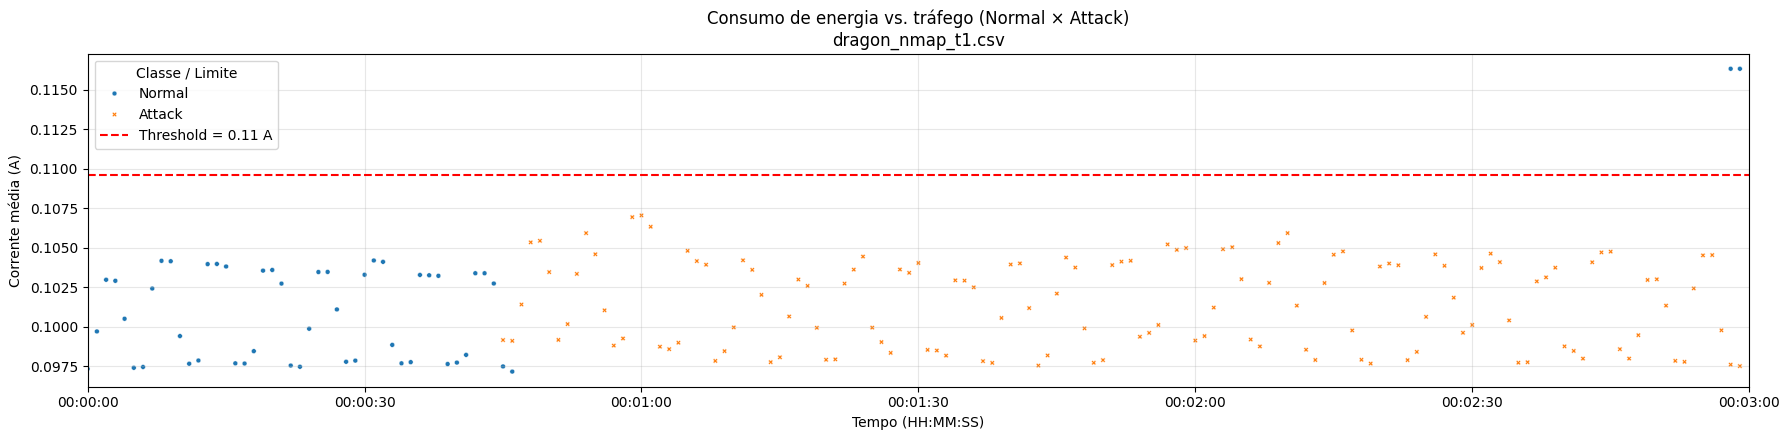

dragon_nmap_t2.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:02:59.999989760 (duration: 0 days 00:02:59.999989760)


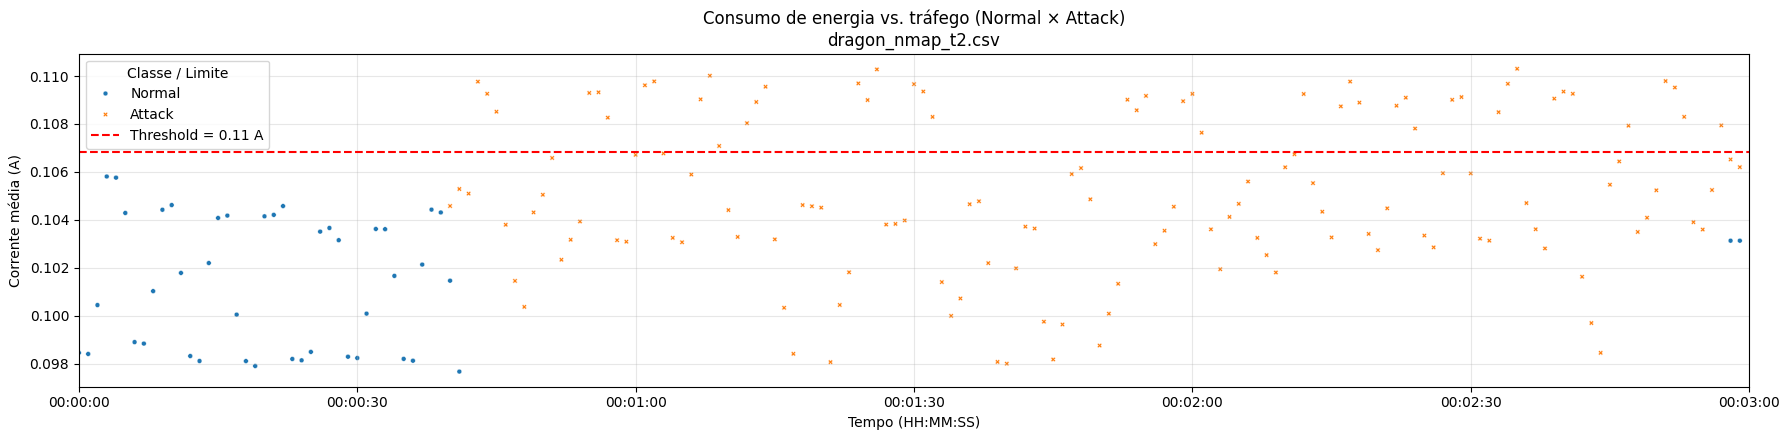

dragon_nmap_t3_0.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:04:59.999989760 (duration: 0 days 00:04:59.999989760)


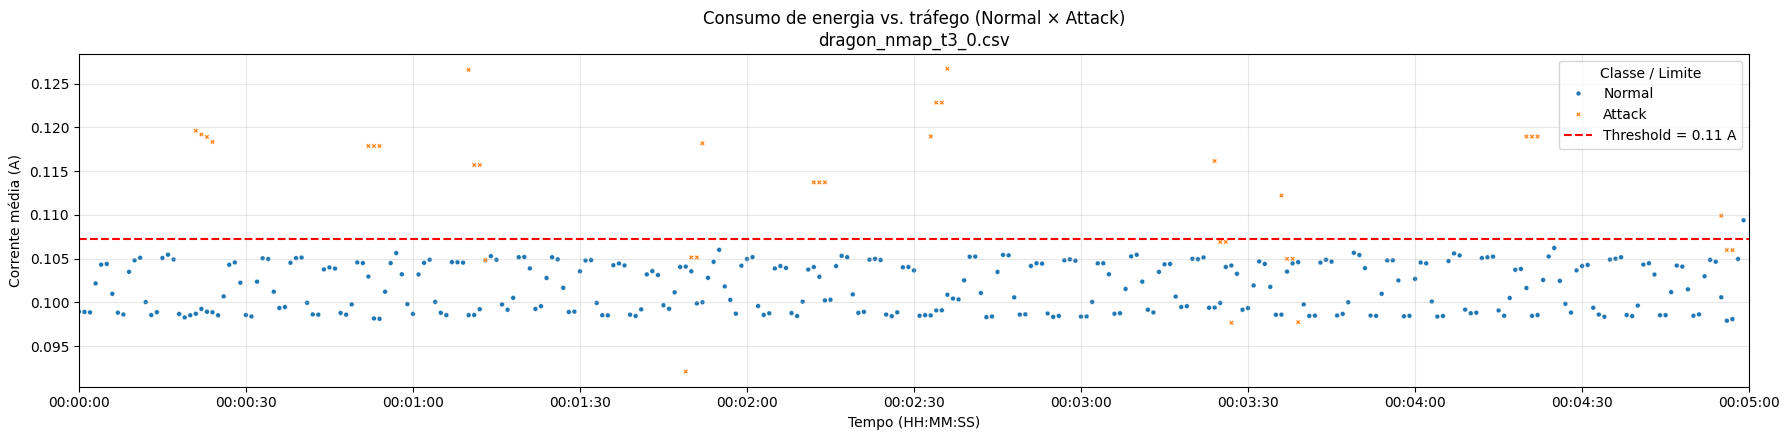

dragon_nmap_t4.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:02:59.999989760 (duration: 0 days 00:02:59.999989760)


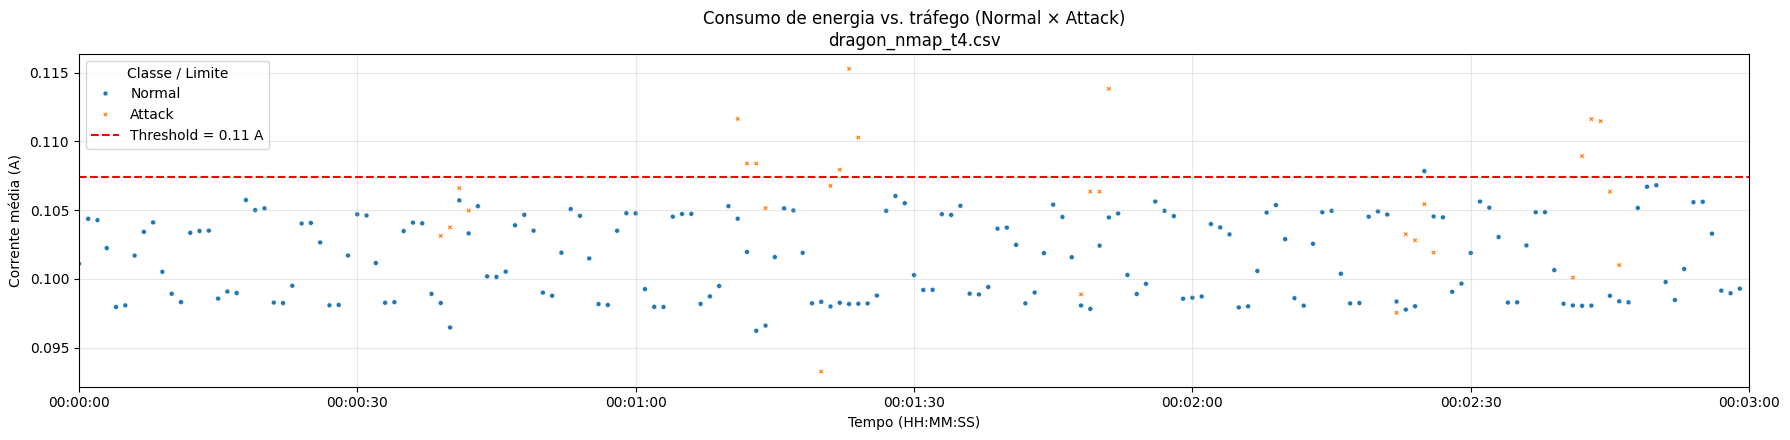

dragon_nmap_t5_1.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:02:59.999989760 (duration: 0 days 00:02:59.999989760)


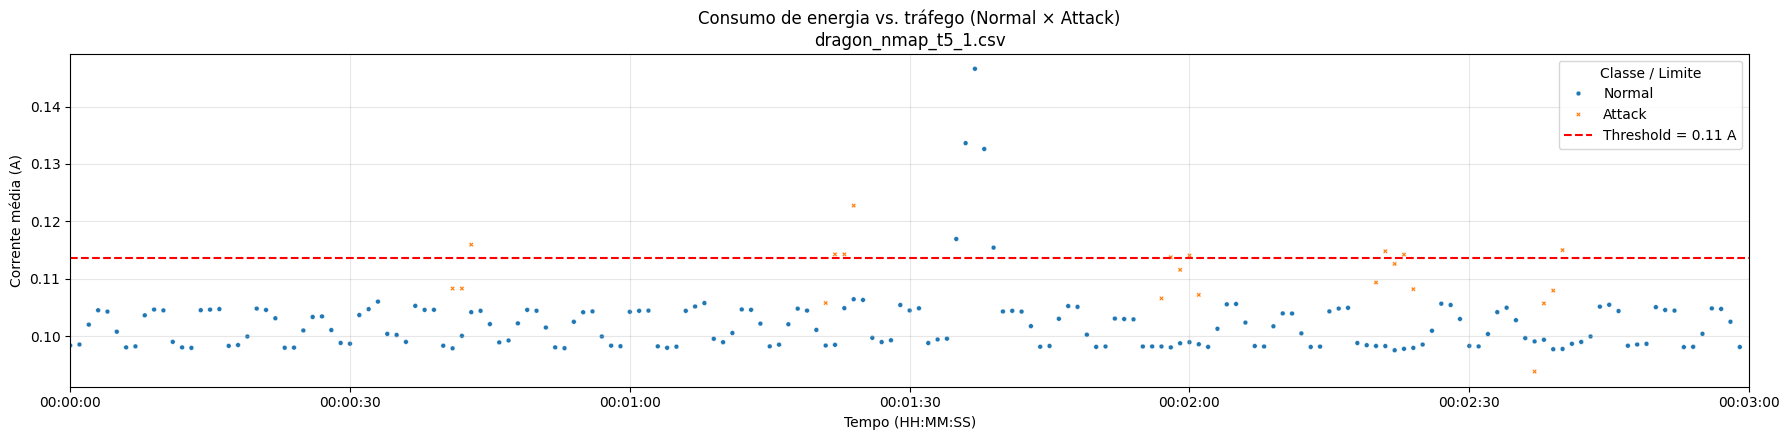

dragon_nmap_t5_2.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:02:59.999989760 (duration: 0 days 00:02:59.999989760)


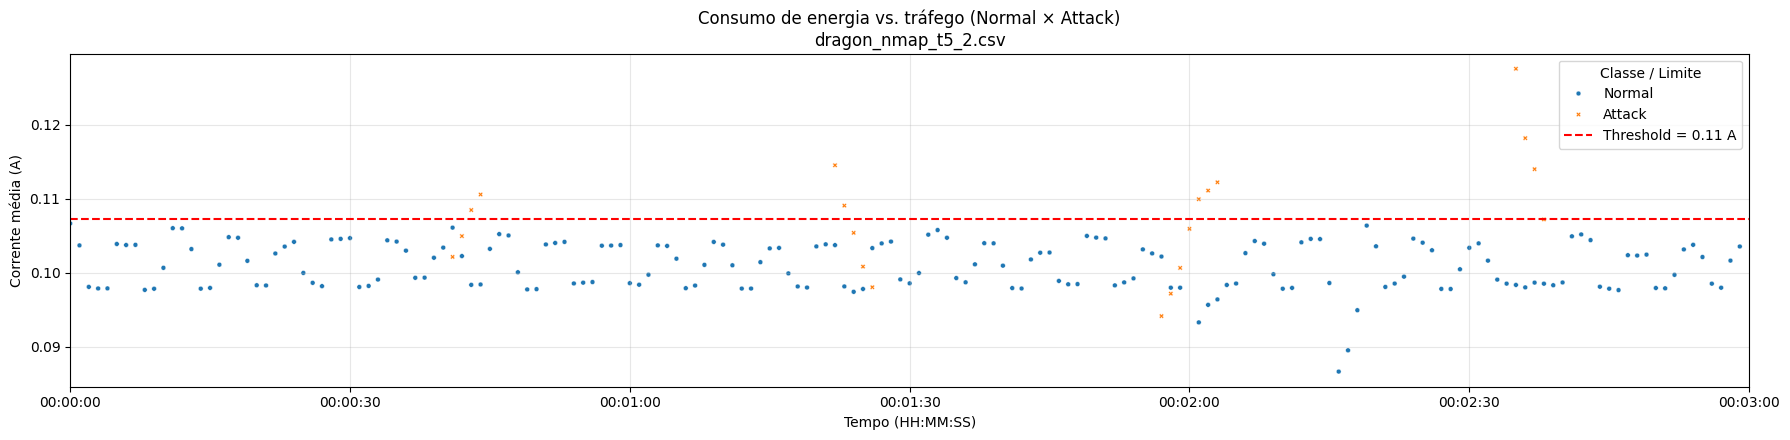

In [16]:
START_DATE = pd.to_datetime("2012-02-29 00:00:00")

for csv_file in sorted(DRAGON_PORTSCAN_PATH.glob("*.csv")):
    if "_legend" in csv_file.name.lower():
        continue

    df = pd.read_csv(csv_file)

    if "Time" not in df.columns:
        continue

    start_td = pd.to_timedelta(df["Time"].min(), unit="s")
    end_td = pd.to_timedelta(df["Time"].max(), unit="s")
    duration_td = end_td - start_td

    print(f"{csv_file.name} — Starts at {start_td} and ends at {end_td} (duration: {duration_td})")

    df = df.set_index("Time")
    df["Datetime"] = pd.to_timedelta(df.index, unit="s") + START_DATE
    df = df.set_index("Datetime")

    for col in ["anno_string", "anno_type", "anno_specific"]:
        if col not in df.columns:
            df[col] = "Normal"

    df["is_attack"] = ~(
        (df["anno_string"].astype(str).str.lower() == "normal")
        & (df["anno_type"].astype(str).str.lower() == "normal")
        & (df["anno_specific"].astype(str).str.lower() == "normal")
    )

    df_sec = (
        df[["Current", "is_attack"]]
        .groupby("is_attack")["Current"]
        .resample("1s")
        .mean()
        .rename("Corrente (A)")
        .reset_index()
    )

    df_sec["Corrente (A)"] = (
        df_sec.groupby("is_attack")["Corrente (A)"]
        .transform(lambda s: s.rolling(3, min_periods=1, center=True).mean())
    )
    df_sec["classe"] = df_sec["is_attack"].map({False: "Normal", True: "Attack"})

    fig, ax = plt.subplots(figsize=(18, 4.5))
    sns.scatterplot(
        data=df_sec,
        x="Datetime",
        y="Corrente (A)",
        hue="classe",
        style="classe",
        s=12,
        ax=ax
    )

    xmin = df.index.min().floor("s")
    xmax = df.index.max().ceil("s")
    ax.set_xlim(xmin, xmax)

    ax.xaxis.set_major_locator(mdates.SecondLocator(interval=30))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))

    ax.set_title(f"Consumo de energia vs. tráfego (Normal × Attack)\n{csv_file.name}")
    ax.set_xlabel("Tempo (HH:MM:SS)")
    ax.set_ylabel("Corrente média (A)")
    ax.grid(True, alpha=0.3)

    threshold = df_sec.loc[df_sec["classe"] == "Normal", "Corrente (A)"].mean() \
             + 2 * df_sec.loc[df_sec["classe"] == "Normal", "Corrente (A)"].std()

    ax.axhline(y=threshold, color="red", linestyle="--", label=f"Threshold = {threshold:.2f} A")
    ax.legend(title="Classe / Limite")

    plt.tight_layout()
    plt.show()


# ============================================================
# DRAGON_CTFs_LARGE e PI_CTFs_LARGE
# ============================================================



--- CTFs data (GB) ---
dragon_ctfs_large    3.33
pi_ctfs_large        5.27

--- Quantidade de arquivos ---
dragon_ctfs_large    3
pi_ctfs_large        5

--- Tamanhos reais dos subarquivos (ctfs) ---
DRAGON  | dragon_ctf_1.csv               |      0.851 GB
DRAGON  | dragon_ctf_2.csv               |      0.849 GB
DRAGON  | dragon_ctf_3.csv               |      0.848 GB
PI      | pi_ctf_1.csv                   |      1.496 GB
PI      | pi_ctf_2.csv                   |      1.422 GB
PI      | pi_ctf_3.csv                   |      1.428 GB
PI      | pi_ctf_4.csv                   |      1.696 GB
PI      | pi_ctf_5.csv                   |      1.717 GB


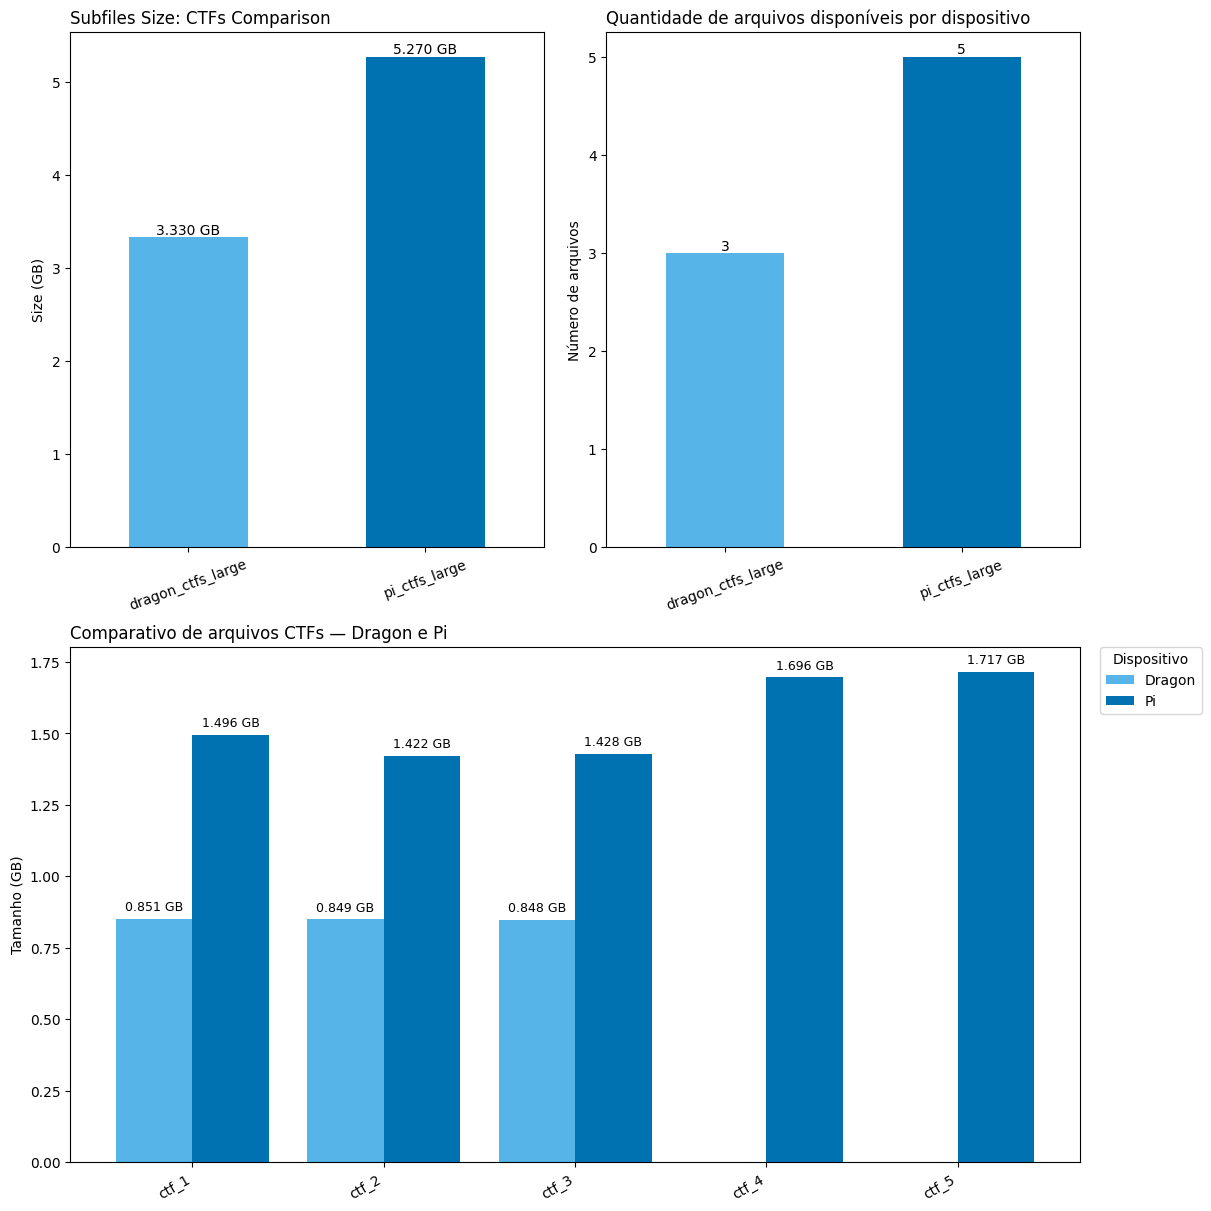

In [24]:
data_structure_text = """
📁 dragon
  📂 dragon_ctfs_large
  └── subtotal dragon_ctfs_large: 3.33 GB
📁 pi
  📂 pi_ctfs_large
  └── subtotal pi_ctfs_large: 5.27 GB
"""

fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])
ax00 = fig.add_subplot(gs[0, 0])   # CTFs subtotal
ax01 = fig.add_subplot(gs[0, 1])   # Quantidade de arquivos
ax10 = fig.add_subplot(gs[1, :])   # Comparativo detalhado (ocupa as duas colunas)

# --- 1. Comparativo de tamanho total (subtotais) ---
pattern_bf = re.compile(r"subtotal\s+(dragon_ctfs_large|pi_ctfs_large):\s+([\d.]+)\s+(GB|MB)", re.IGNORECASE)
sizes_bf = {}
for line in data_structure_text.splitlines():
    m = pattern_bf.search(line)
    if m:
        name, size_str, unit = m.groups()
        size = float(size_str)
        if unit.upper() == "MB":
            size /= 1024.0
        sizes_bf[name] = size

if sizes_bf:
    df2 = pd.Series(sizes_bf, name="Size (GB)")
    print("\n--- CTFs data (GB) ---")
    print(df2.round(3).to_string())
    df2.plot(kind="bar", ax=ax00, color=["#56B4E9", "#0072B2"])
    ax00.set_title("Subfiles Size: CTFs Comparison", loc="left")
    ax00.set_ylabel("Size (GB)")
    ax00.tick_params(axis="x", rotation=20)
    for c in ax00.containers:
        ax00.bar_label(c, fmt="%.3f GB")
else:
    ax00.text(0.5, 0.5, "No data to plot", ha="center", va="center", fontsize=12)
    ax00.set_title("Subfiles Size: CTFs Comparison", loc="left")

# --- 2. Quantidade de arquivos ---
counts = pd.Series({"dragon_ctfs_large": 3, "pi_ctfs_large": 5})
print("\n--- Quantidade de arquivos ---")
print(counts.to_string())

counts.plot(kind="bar", color=["#56B4E9", "#0072B2"], ax=ax01)
ax01.set_title("Quantidade de arquivos disponíveis por dispositivo", loc="left")
ax01.set_ylabel("Número de arquivos")
ax01.tick_params(axis='x', rotation=20)
for c in ax01.containers:
    ax01.bar_label(c)

# --- 3. Comparativo arquivos CTFs — Dragon vs Pi (em GB) ---
BASE_DIR = Path("./dragon_pi").expanduser()
EXCLUDE_SUBSTR = "_legend"
DEVICE_KEYS = ["dragon", "pi"]

entries = []
if BASE_DIR.exists():
    for ctfs_dir in BASE_DIR.rglob("*ctf*"):
        if ctfs_dir.is_dir():
            for f in ctfs_dir.rglob("*.csv"):
                if EXCLUDE_SUBSTR in f.stem.lower():
                    continue
                entries.append(f)

rows = []
num_re = re.compile(r'[_\-](\d+)\b')
for f in entries:
    nlow = f.stem.lower()
    dev = "dragon" if "dragon" in nlow else ("pi" if "pi" in nlow else None)
    if dev not in DEVICE_KEYS:
        continue
    m = num_re.search(nlow)
    file_id = int(m.group(1)) if m else None
    if file_id is None:
        continue
    try:
        size_gb = f.stat().st_size / (1024 ** 3)
    except OSError:
        continue
    rows.append((file_id, dev, f.name, size_gb))

print("\n--- Tamanhos reais dos subarquivos (ctfs) ---")
for e in sorted(rows, key=lambda x: (x[1], x[0])):
    print(f"{e[1].upper():7s} | {e[2]:30s} | {e[3]:10.3f} GB")

if not rows:
    ax10.text(0.5, 0.5, "Nenhum arquivo válido encontrado em ./dragon_pi/*ctf*", ha="center", va="center")
else:
    df = pd.DataFrame(rows, columns=["id", "device", "file", "size_GB"])
    df = df.sort_values("id")
    pv = df.pivot_table(index="id", columns="device", values="size_GB", aggfunc="sum").fillna(0)

    labels = [f"ctf_{i}" for i in pv.index.tolist()]
    x = np.arange(len(labels))
    width = 0.4

    y_dragon = pv.get("dragon", pd.Series([0]*len(labels), index=pv.index)).values
    y_pi     = pv.get("pi",     pd.Series([0]*len(labels), index=pv.index)).values

    b1 = ax10.bar(x - width/2, y_dragon, width, label="Dragon", color="#56B4E9")
    b2 = ax10.bar(x + width/2, y_pi,     width, label="Pi", color="#0072B2")

    ax10.set_ylabel("Tamanho (GB)")
    ax10.set_title("Comparativo de arquivos CTFs — Dragon e Pi", loc="left")
    ax10.set_xticks(x)
    ax10.set_xticklabels(labels, rotation=30, ha="right")
    ax10.legend(title="Dispositivo", loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0)

    for bar in list(b1) + list(b2):
        h = bar.get_height()
        if h > 0:
            ax10.annotate(f"{h:.3f} GB",
                          xy=(bar.get_x() + bar.get_width()/2, h),
                          xytext=(0, 4), textcoords="offset points",
                          ha="center", va="bottom", fontsize=9)

plt.show()

In [23]:
PI_CTFS_PATH = Path("dragon_pi/pi/pi_ctfs_large")

for csv_file in sorted(PI_CTFS_PATH.glob("pi_ctf_*.csv")):
    if "_legend" in csv_file.name.lower():
        continue

    print(f"\n=== {csv_file.name} ===")
    dataset = pd.read_csv(csv_file, index_col=0)

    not_normal = dataset[
        (dataset["anno_string"] != "Normal") |
        (dataset["anno_type"] != "Normal") |
        (dataset["anno_specific"] != "Normal")
    ]

    print("Dimensões do conjunto original:", dataset.shape)
    print("Linhas com anomalias:", not_normal.shape)

    print("\nTipos de valores diferentes de 'Normal':")
    print(not_normal[["anno_string", "anno_type", "anno_specific"]].drop_duplicates())

    print("\nAmostra de ataques/anomalias:")
    display(not_normal.head(10))



=== pi_ctf_1.csv ===
Dimensões do conjunto original: (23437500, 5)
Linhas com anomalias: (13139616, 5)

Tipos de valores diferentes de 'Normal':
         anno_string                      anno_type  \
1435543      Anomaly                           Ping   
3027336      Anomaly                      Port_Scan   
3671865      Anomaly                 SSH_BruteForce   
8837868      Anomaly                      SSH_Login   
10263645     Anomaly                   Unix_Command   
10707980     Anomaly                   Unix_Command   
11171846     Anomaly                   Unix_Command   
11723602     Anomaly                   Unix_Command   
12875943     Anomaly                   Unix_Command   
13662074     Anomaly                   Unix_Command   
16181599     Anomaly                   Unix_Command   
16625934     Anomaly                   Unix_Command   
17490189     Anomaly  data_exfiltration(SCP)_failed   
17949172     Anomaly         data_exfiltration(SCP)   
18662061     Anomaly         

Time  Current anno_string anno_type anno_specific
1435543 29.399921 0.267390     Anomaly      Ping          Ping
1435544 29.399941 0.266949     Anomaly      Ping          Ping
1435545 29.399962 0.266625     Anomaly      Ping          Ping
1435546 29.399982 0.266331     Anomaly      Ping          Ping
1435547 29.400003 0.266067     Anomaly      Ping          Ping
1435548 29.400023 0.265919     Anomaly      Ping          Ping
1435549 29.400044 0.265831     Anomaly      Ping          Ping
1435550 29.400064 0.265861     Anomaly      Ping          Ping
1435551 29.400084 0.265861     Anomaly      Ping          Ping
1435552 29.400105 0.265772     Anomaly      Ping          Ping


=== pi_ctf_2.csv ===
Dimensões do conjunto original: (23437500, 5)
Linhas com anomalias: (8691384, 5)

Tipos de valores diferentes de 'Normal':
         anno_string                anno_type                   anno_specific
1660152      Anomaly                     Ping                            Ping
3017570      Anomaly                Port_Scan                         Nmap_T3
4384754      Anomaly           SSH_BruteForce                        Hydra_T4
8872047      Anomaly                SSH_Login                       SSH_Login
9804662      Anomaly             Unix_Command                          whoami
10292942     Anomaly             Unix_Command                         sudo -l
10742160     Anomaly             Unix_Command                              ls
11269502     Anomaly             Unix_Command                    cd directory
12314421     Anomaly             Unix_Command                      cat file_1
13266567     Anomaly             Unix_Command                      cat file

Time  Current anno_string anno_type anno_specific
1660152 33.999913 0.299353     Anomaly      Ping          Ping
1660153 33.999933 0.299471     Anomaly      Ping          Ping
1660154 33.999954 0.299559     Anomaly      Ping          Ping
1660155 33.999974 0.299530     Anomaly      Ping          Ping
1660156 33.999995 0.299383     Anomaly      Ping          Ping
1660157 34.000015 0.299236     Anomaly      Ping          Ping
1660158 34.000036 0.299206     Anomaly      Ping          Ping
1660159 34.000056 0.299294     Anomaly      Ping          Ping
1660160 34.000077 0.299383     Anomaly      Ping          Ping
1660161 34.000097 0.299471     Anomaly      Ping          Ping


=== pi_ctf_3.csv ===
Dimensões do conjunto original: (23437500, 5)
Linhas com anomalias: (8876933, 5)

Tipos de valores diferentes de 'Normal':
         anno_string                      anno_type  \
1464840      Anomaly                           Ping   
2944328      Anomaly                      Port_Scan   
4453113      Anomaly                 SSH_BruteFroce   
8779274      Anomaly                      SSH_Login   
9819310      Anomaly                   Unix_Command   
10312473     Anomaly                   Unix_Command   
10747042     Anomaly                   Unix_Command   
11254854     Anomaly                   Unix_Command   
12309538     Anomaly                   Unix_Command   
13207974     Anomaly                   Unix_Command   
14248010     Anomaly                   Unix_Command   
15624960     Anomaly                   Unix_Command   
16650348     Anomaly                   Unix_Command   
17582962     Anomaly         data_exfiltration(SCP)   
18559522     Anomaly   payload

Time  Current anno_string anno_type anno_specific
1464840 29.999923 0.266284     Anomaly      Ping          Ping
1464841 29.999944 0.266049     Anomaly      Ping          Ping
1464842 29.999964 0.265931     Anomaly      Ping          Ping
1464843 29.999985 0.265872     Anomaly      Ping          Ping
1464844 30.000005 0.265843     Anomaly      Ping          Ping
1464845 30.000026 0.265902     Anomaly      Ping          Ping
1464846 30.000046 0.266049     Anomaly      Ping          Ping
1464847 30.000067 0.266225     Anomaly      Ping          Ping
1464848 30.000087 0.266284     Anomaly      Ping          Ping
1464849 30.000108 0.266313     Anomaly      Ping          Ping


=== pi_ctf_4.csv ===
Dimensões do conjunto original: (23437500, 6)
Linhas com anomalias: (11889619, 6)

Tipos de valores diferentes de 'Normal':
         anno_string                   anno_type  \
1464840      Anomaly                        Ping   
2895500      Anomaly                   Port_Scan   
4394520      Anomaly              SSH_BruteForce   
8803688      Anomaly                   SSH_Login   
9765600      Anomaly                Unix_Command   
10302708     Anomaly                Unix_Command   
10869112     Anomaly                Unix_Command   
11293916     Anomaly                Unix_Command   
12221648     Anomaly                Unix_Command   
13281216     Anomaly                Unix_Command   
14033167     Anomaly                Unix_Command   
16054646     Anomaly                Unix_Command   
16567340     Anomaly                Unix_Command   
17578080     Anomaly     data_exfiltration (SCP)   
18608350     Anomaly       payload_delivery(SCP)   
19067334     Anomaly  

Unnamed: 0      Time  Current anno_string anno_type anno_specific
1464840     1464840 29.999923 0.303217     Anomaly      Ping          Ping
1464841     1464841 29.999944 0.303158     Anomaly      Ping          Ping
1464842     1464842 29.999964 0.302923     Anomaly      Ping          Ping
1464843     1464843 29.999985 0.302599     Anomaly      Ping          Ping
1464844     1464844 30.000005 0.302305     Anomaly      Ping          Ping
1464845     1464845 30.000026 0.302070     Anomaly      Ping          Ping
1464846     1464846 30.000046 0.301775     Anomaly      Ping          Ping
1464847     1464847 30.000067 0.301511     Anomaly      Ping          Ping
1464848     1464848 30.000087 0.301128     Anomaly      Ping          Ping
1464849     1464849 30.000108 0.300687     Anomaly      Ping          Ping


=== pi_ctf_5.csv ===
Dimensões do conjunto original: (23437500, 5)
Linhas com anomalias: (18994092, 5)

Tipos de valores diferentes de 'Normal':
         anno_string              anno_type            anno_specific
1503902      Anomaly         Reconnaissance         Ping_and_Nmap_T3
2187494      Anomaly         SSH_BruteForce                 Hydra_T4
5493150      Anomaly           Infiltration                SSH_Login
5737290      Anomaly            Exploration            Unix_Commands
8564431      Anomaly           Exfiltration               SCP file_1
9150367      Anomaly       Payload_Delivery              SCP payload
9477514      Anomaly  Remote_Code_Execution        payload_execution
10522434     Anomaly             Withdrawal               SSH_Logout
11069307     Anomaly       Payload_Executes  Battery_Drainer_Payload

Amostra de ataques/anomalias:


Time  Current anno_string       anno_type     anno_specific
1503902 30.799913 0.292099     Anomaly  Reconnaissance  Ping_and_Nmap_T3
1503903 30.799933 0.292246     Anomaly  Reconnaissance  Ping_and_Nmap_T3
1503904 30.799954 0.292158     Anomaly  Reconnaissance  Ping_and_Nmap_T3
1503905 30.799974 0.291775     Anomaly  Reconnaissance  Ping_and_Nmap_T3
1503906 30.799995 0.291128     Anomaly  Reconnaissance  Ping_and_Nmap_T3
1503907 30.800015 0.290246     Anomaly  Reconnaissance  Ping_and_Nmap_T3
1503908 30.800036 0.289275     Anomaly  Reconnaissance  Ping_and_Nmap_T3
1503909 30.800056 0.288451     Anomaly  Reconnaissance  Ping_and_Nmap_T3
1503910 30.800077 0.287951     Anomaly  Reconnaissance  Ping_and_Nmap_T3
1503911 30.800097 0.287922     Anomaly  Reconnaissance  Ping_and_Nmap_T3

In [24]:
pd.set_option("display.float_format", lambda x: f"{x:.6f}")

def rms(x: pd.Series) -> float:
    return float(np.sqrt(np.mean(np.square(x)))) if len(x) > 0 else np.nan

def stats_from_series(s: pd.Series) -> dict:
    return {
        "mean_current": float(s.mean()),
        "std_current": float(s.std(ddof=0)),
        "rms_current": rms(s),
        "max_current": float(s.max()),
        "min_current": float(s.min()),
        "amp_current": float(s.max() - s.min())
    }

all_stats = []

for csv_path in tqdm(sorted(PI_CTFS_PATH.glob("*.csv"))):
    if "_legend" in csv_path.name.lower():
        continue

    try:
        df = pd.read_csv(csv_path, usecols=["Time", "Current"])
    except Exception as e:
        print(f"[ERRO] Falha ao ler {csv_path.name}: {e}")
        continue

    df["Current"] = pd.to_numeric(df["Current"], errors="coerce")
    df = df.dropna(subset=["Current"])
    df = df[np.isfinite(df["Current"])]
    df = df[df["Current"].between(0, 5)]

    if df.empty:
        print(f"[AVISO] {csv_path.name} ficou vazio após limpeza.")
        continue

    s = df["Current"]
    stats = stats_from_series(s)
    stats["std_current"] = float(np.std(s, ddof=0))
    stats["source_file"] = csv_path.name
    all_stats.append(stats)

df_all = pd.DataFrame(all_stats)

print(f"Arquivos processados: {len(df_all)}\n")
display(df_all)


100%|██████████| 10/10 [01:28<00:00,  8.90s/it]

Arquivos processados: 5



mean_current  std_current  rms_current  max_current  min_current  \
0      0.323017     0.076616     0.331979     1.095169     0.246122   
1      0.306643     0.063149     0.313078     1.027322     0.246404   
2      0.304274     0.061339     0.310395     0.914534     0.246428   
3      0.326363     0.073707     0.334583     0.913520     0.246767   
4      0.381856     0.086353     0.391498     0.919493     0.248327   

   amp_current   source_file  
0     0.849047  pi_ctf_1.csv  
1     0.780919  pi_ctf_2.csv  
2     0.668107  pi_ctf_3.csv  
3     0.666753  pi_ctf_4.csv  
4     0.671166  pi_ctf_5.csv

Processando pi_ctf_1.csv...
Processando pi_ctf_2.csv...
Processando pi_ctf_3.csv...
Processando pi_ctf_4.csv...
Processando pi_ctf_5.csv...


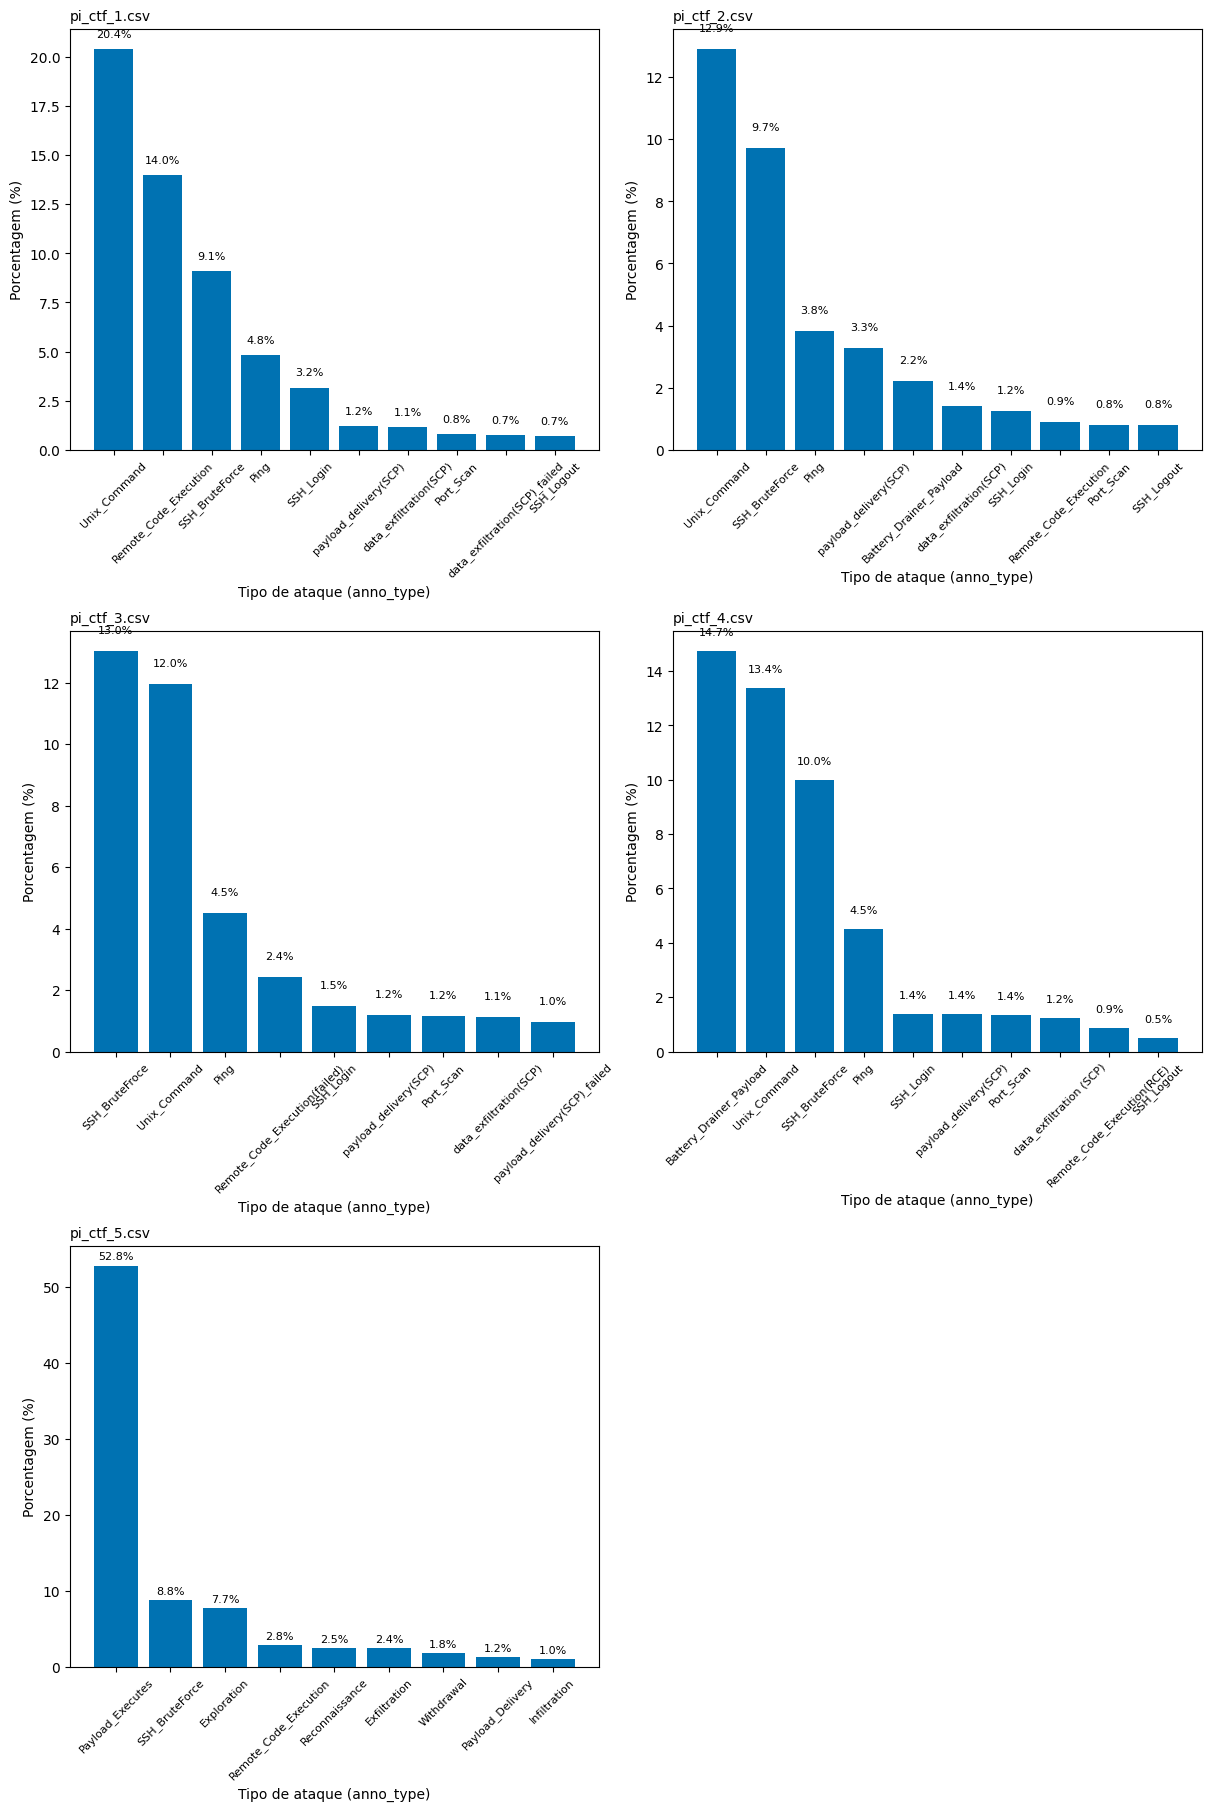

In [31]:
files = sorted(f for f in PI_CTFS_PATH.glob("pi_ctf_*.csv") if "_legend" not in f.name.lower())

n = len(files)
cols = 2
rows = math.ceil(n / cols)

fig = plt.figure(figsize=(12, 6 * rows), constrained_layout=True)
gs = fig.add_gridspec(rows, cols)

for i, f in enumerate(files):
    r, c = divmod(i, cols)
    ax = fig.add_subplot(gs[r, c])
    print(f"Processando {f.name}...")

    df = pd.read_csv(f)
    if "anno_type" not in df.columns:
        ax.text(0.5, 0.5, f"{f.name}\n(coluna 'anno_type' ausente)",
                ha="center", va="center", fontsize=10)
        continue

    counts = df["anno_type"].value_counts()
    total = counts.sum()
    perc = (counts / total) * 100
    perc_no_normal = perc.drop(labels=["Normal"], errors="ignore")

    bars = ax.bar(perc_no_normal.index, perc_no_normal.values, color="#0072B2")
    ax.set_title(f"{f.name}", loc="left", fontsize=10)
    ax.set_ylabel("Porcentagem (%)")
    ax.set_xlabel("Tipo de ataque (anno_type)")
    ax.tick_params(axis="x", rotation=45, labelsize=8)

    for bar, pct in zip(bars, perc_no_normal.values):
        ax.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height() + 0.5,
            f"{pct:.1f}%",
            ha="center", va="bottom", fontsize=8
        )

if n % cols != 0:
    for j in range(n, rows * cols):
        fig.add_subplot(gs[j // cols, j % cols]).axis("off")


plt.show()


In [36]:
results = []

for csv_file in sorted(PI_CTFS_PATH.glob("*.csv")):
    if "_legend" in csv_file.name.lower():
        continue

    try:
        df = pd.read_csv(csv_file)
        if "Time" not in df.columns:
            continue

        start = pd.to_timedelta(df["Time"].min(), unit="s")
        end = pd.to_timedelta(df["Time"].max(), unit="s")
        duration = (end - start)

        results.append({
            "Arquivo": csv_file.name,
            "Tamanho (MB)": round(csv_file.stat().st_size / (1024 ** 2), 2),
            "Início": str(start),
            "Fim": str(end),
            "Duração (h)": round(duration.total_seconds() / 3600, 2)
        })
    except Exception as e:
        print(f"Erro ao processar {csv_file.name}: {e}")

df_summary = pd.DataFrame(results)
print(df_summary)


        Arquivo  Tamanho (MB)           Início                        Fim  \
0  pi_ctf_1.csv       1531.87  0 days 00:00:00  0 days 00:07:59.999979520   
1  pi_ctf_2.csv       1455.93  0 days 00:00:00  0 days 00:07:59.999979520   
2  pi_ctf_3.csv       1461.93  0 days 00:00:00  0 days 00:07:59.999979520   
3  pi_ctf_4.csv       1736.37  0 days 00:00:00  0 days 00:07:59.999979520   
4  pi_ctf_5.csv       1757.76  0 days 00:00:00  0 days 00:07:59.999979520   

   Duração (h)  
0         0.13  
1         0.13  
2         0.13  
3         0.13  
4         0.13  


pi_ctf_1.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:07:59.999979520 (duration: 0 days 00:07:59.999979520)


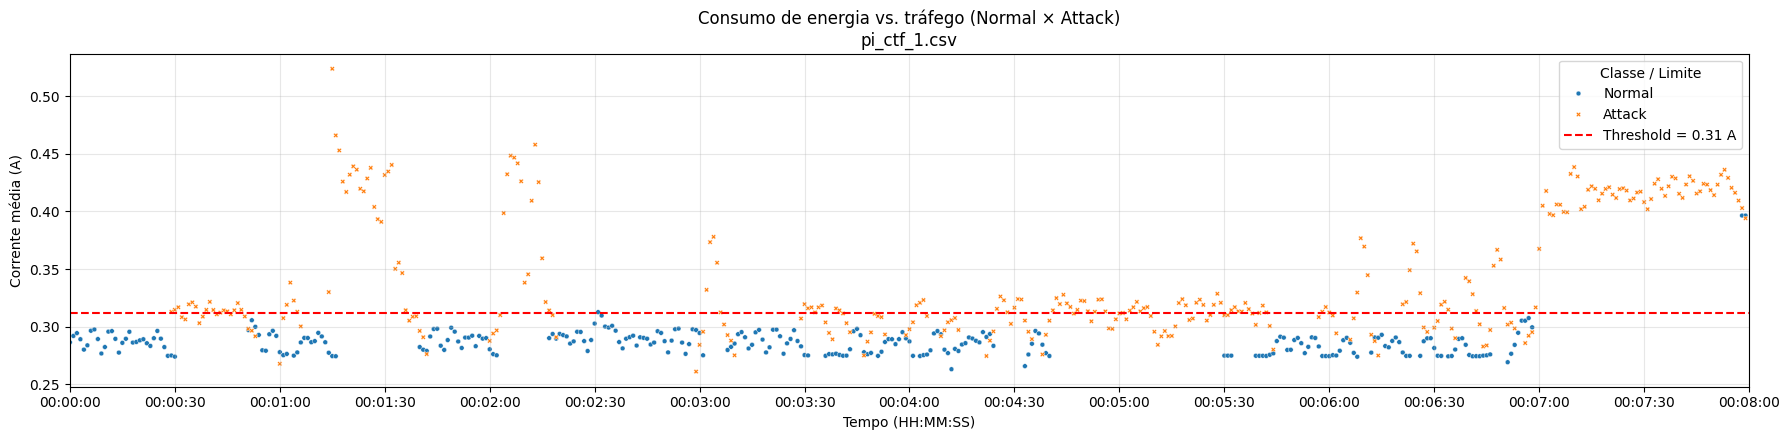

pi_ctf_2.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:07:59.999979520 (duration: 0 days 00:07:59.999979520)


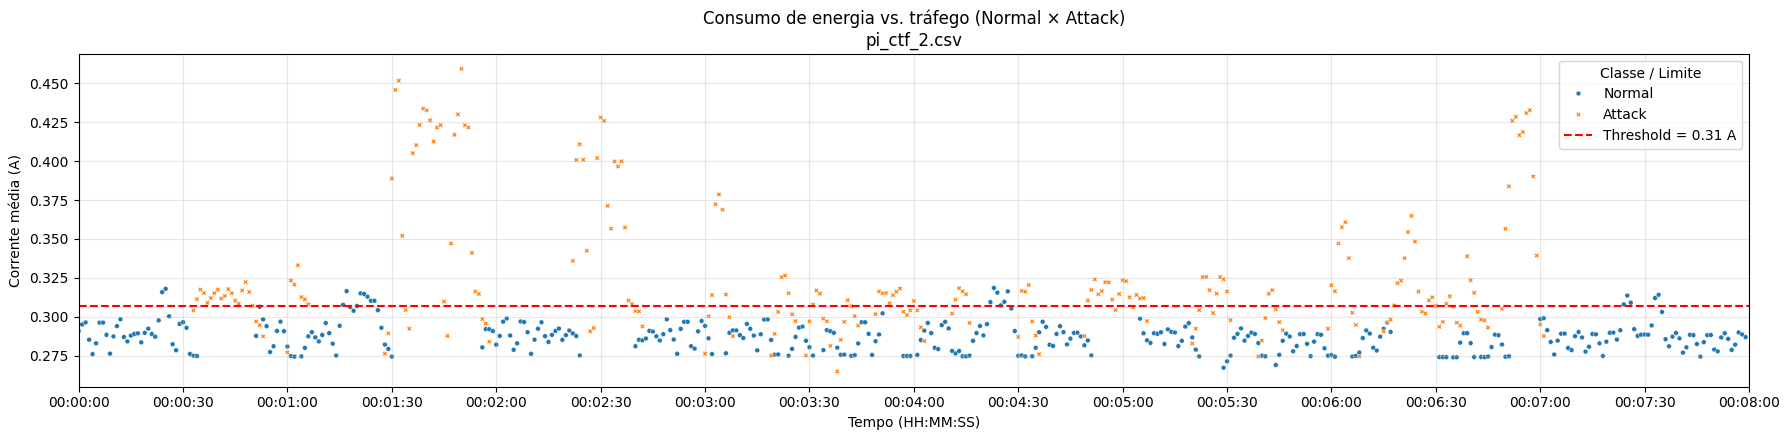

pi_ctf_3.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:07:59.999979520 (duration: 0 days 00:07:59.999979520)


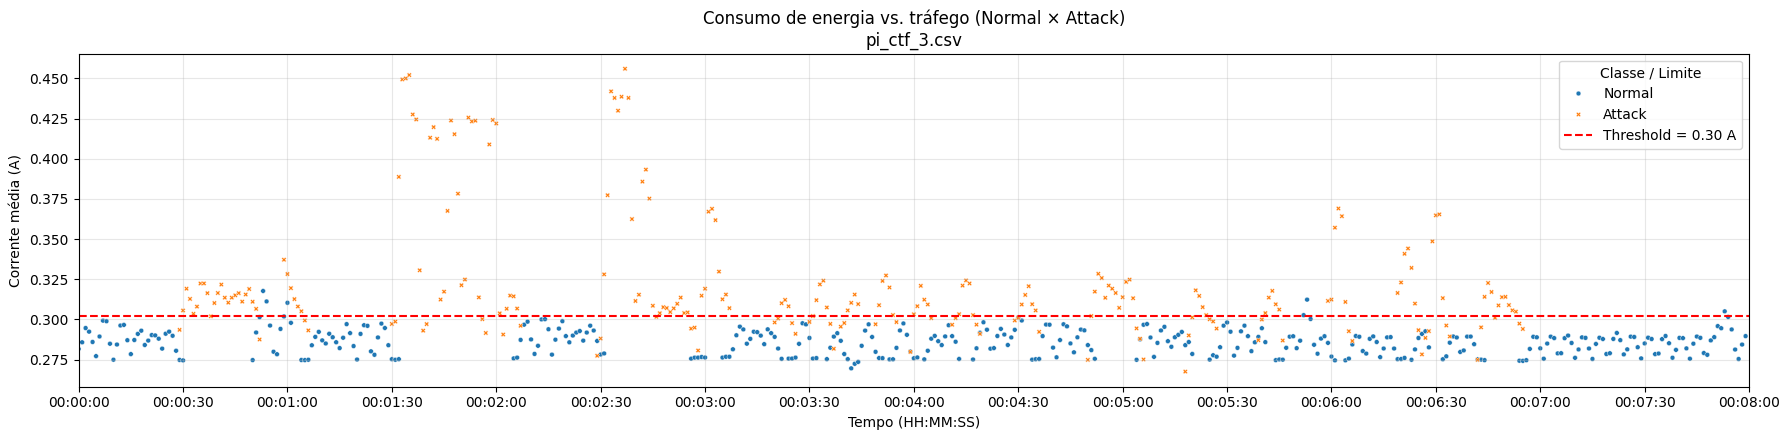

pi_ctf_4.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:07:59.999979520 (duration: 0 days 00:07:59.999979520)


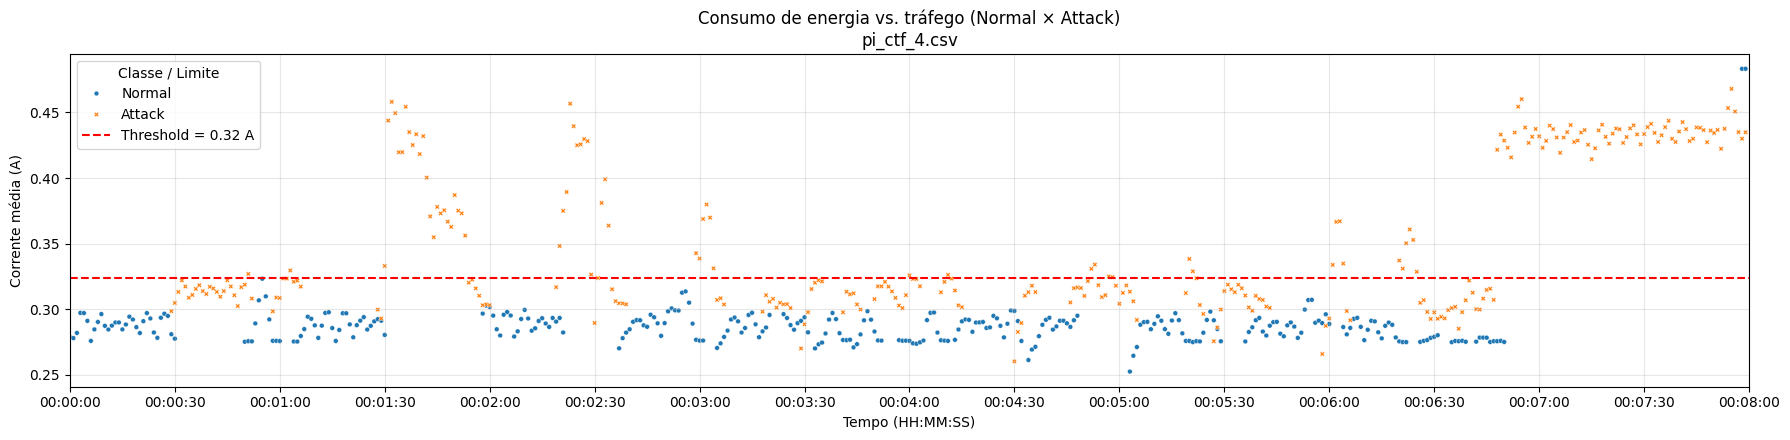

pi_ctf_5.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:07:59.999979520 (duration: 0 days 00:07:59.999979520)


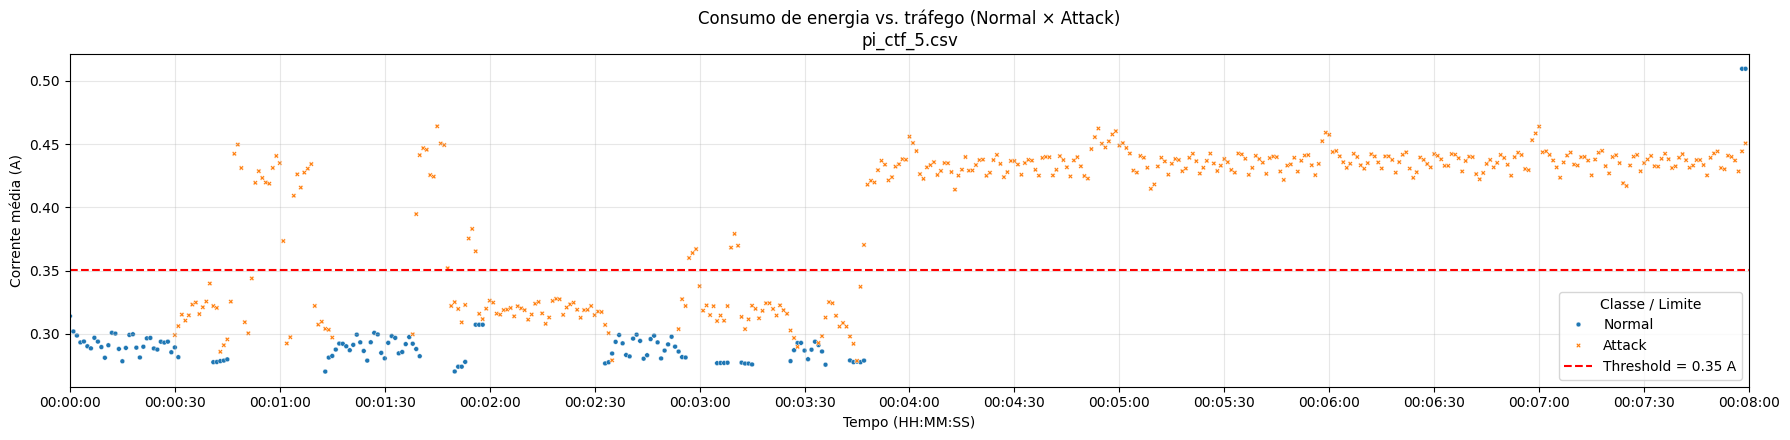

In [ ]:
START_DATE = pd.to_datetime("2012-02-29 00:00:00")

for csv_file in sorted(PI_CTFS_PATH.glob("*.csv")):
    if "_legend" in csv_file.name.lower():
        continue

    df = pd.read_csv(csv_file)

    if "Time" not in df.columns:
        continue

    start_td = pd.to_timedelta(df["Time"].min(), unit="s")
    end_td = pd.to_timedelta(df["Time"].max(), unit="s")
    duration_td = end_td - start_td

    print(f"{csv_file.name} — Starts at {start_td} and ends at {end_td} (duration: {duration_td})")

    df = df.set_index("Time")
    df["Datetime"] = pd.to_timedelta(df.index, unit="s") + START_DATE
    df = df.set_index("Datetime")

    for col in ["anno_string", "anno_type", "anno_specific"]:
        if col not in df.columns:
            df[col] = "Normal"

    df["is_attack"] = ~(
        (df["anno_string"].astype(str).str.lower() == "normal")
        & (df["anno_type"].astype(str).str.lower() == "normal")
        & (df["anno_specific"].astype(str).str.lower() == "normal")
    )

    df_sec = (
        df[["Current", "is_attack"]]
        .groupby("is_attack")["Current"]
        .resample("1s")
        .mean()
        .rename("Corrente (A)")
        .reset_index()
    )

    df_sec["Corrente (A)"] = (
        df_sec.groupby("is_attack")["Corrente (A)"]
        .transform(lambda s: s.rolling(3, min_periods=1, center=True).mean())
    )
    df_sec["classe"] = df_sec["is_attack"].map({False: "Normal", True: "Attack"})

    fig, ax = plt.subplots(figsize=(18, 4.5))
    sns.scatterplot(
        data=df_sec,
        x="Datetime",
        y="Corrente (A)",
        hue="classe",
        style="classe",
        s=12,
        ax=ax
    )

    xmin = df.index.min().floor("s")
    xmax = df.index.max().ceil("s")
    ax.set_xlim(xmin, xmax)

    ax.xaxis.set_major_locator(mdates.SecondLocator(interval=30))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))

    ax.set_title(f"Consumo de energia vs. tráfego (Normal × Attack)\n{csv_file.name}")
    ax.set_xlabel("Tempo (HH:MM:SS)")
    ax.set_ylabel("Corrente média (A)")
    ax.grid(True, alpha=0.3)

    threshold = df_sec.loc[df_sec["classe"] == "Normal", "Corrente (A)"].mean() \
             + 2 * df_sec.loc[df_sec["classe"] == "Normal", "Corrente (A)"].std()

    ax.axhline(y=threshold, color="red", linestyle="--", label=f"Threshold = {threshold:.2f} A")
    ax.legend(title="Classe / Limite")

    plt.tight_layout()
    plt.show()


In [25]:
DRAGON_CTFS_PATH = Path("dragon_pi/dragon/dragon_ctfs_large")

for csv_file in sorted(DRAGON_CTFS_PATH.glob("dragon_ctf_*.csv")):
    if "_legend" in csv_file.name.lower():
        continue

    print(f"\n=== {csv_file.name} ===")
    dataset = pd.read_csv(csv_file, index_col=0)

    not_normal = dataset[
        (dataset["anno_string"] != "Normal") |
        (dataset["anno_type"] != "Normal") |
        (dataset["anno_specific"] != "Normal")
    ]

    print("Dimensões do conjunto original:", dataset.shape)
    print("Linhas com anomalias:", not_normal.shape)

    print("\nTipos de valores diferentes de 'Normal':")
    print(not_normal[["anno_string", "anno_type", "anno_specific"]].drop_duplicates())

    print("\nAmostra de ataques/anomalias:")
    display(not_normal.head(10))



=== dragon_ctf_1.csv ===
Dimensões do conjunto original: (14648438, 5)
Linhas com anomalias: (3741200, 5)

Tipos de valores diferentes de 'Normal':
         anno_string               anno_type           anno_specific
2900383      Anomaly                    Ping                    Ping
4443348      Anomaly               Port_Scan                 Nmap_T3
5859360      Anomaly          SSH_BruteForce               Hydra_T16
7470684      Anomaly               SSH_Login               SSH_Login
8398416      Anomaly            Unix_Command                    Misc
11718720     Anomaly  data_exfiltration(SCP)  data_exfiltration(SCP)
12905240     Anomaly              SSH_Logout              SSH_Logout

Amostra de ataques/anomalias:


Time  Current anno_string anno_type anno_specific
2900383 59.399844 0.093738     Anomaly      Ping          Ping
2900384 59.399864 0.093650     Anomaly      Ping          Ping
2900385 59.399885 0.093591     Anomaly      Ping          Ping
2900386 59.399905 0.093680     Anomaly      Ping          Ping
2900387 59.399926 0.093827     Anomaly      Ping          Ping
2900388 59.399946 0.093944     Anomaly      Ping          Ping
2900389 59.399967 0.094062     Anomaly      Ping          Ping
2900390 59.399987 0.094180     Anomaly      Ping          Ping
2900391 59.400008 0.094327     Anomaly      Ping          Ping
2900392 59.400028 0.094445     Anomaly      Ping          Ping


=== dragon_ctf_2.csv ===
Dimensões do conjunto original: (14648438, 5)
Linhas com anomalias: (5151352, 5)

Tipos de valores diferentes de 'Normal':
         anno_string               anno_type           anno_specific
1660152      Anomaly                    Ping                    Ping
2929680      Anomaly               Port_Scan                 Nmap_T3
4150380      Anomaly          SSH_BruteForce               Hydra_T16
5859360      Anomaly               SSH_Login               SSH_Login
7324200      Anomaly            Unix_Command                    Misc
10356418     Anomaly  data_exfiltration(SCP)  data_exfiltration(SCP)
11718720     Anomaly              SSH_Logout              SSH_Logout

Amostra de ataques/anomalias:


Time  Current anno_string anno_type anno_specific
1660152 33.999913 0.110793     Anomaly      Ping          Ping
1660153 33.999933 0.110764     Anomaly      Ping          Ping
1660154 33.999954 0.110646     Anomaly      Ping          Ping
1660155 33.999974 0.110558     Anomaly      Ping          Ping
1660156 33.999995 0.110587     Anomaly      Ping          Ping
1660157 34.000015 0.110528     Anomaly      Ping          Ping
1660158 34.000036 0.110440     Anomaly      Ping          Ping
1660159 34.000056 0.110381     Anomaly      Ping          Ping
1660160 34.000077 0.110293     Anomaly      Ping          Ping
1660161 34.000097 0.110322     Anomaly      Ping          Ping


=== dragon_ctf_3.csv ===
Dimensões do conjunto original: (14648438, 5)
Linhas com anomalias: (3798818, 5)

Tipos de valores diferentes de 'Normal':
         anno_string               anno_type           anno_specific
1269528      Anomaly                    Ping                    Ping
2929680      Anomaly               Port_Scan                 Nmap_T3
4516590      Anomaly          SSH_BruteForce               Hydra_T16
5859360      Anomaly               SSH_Login               SSH_Login
7324200      Anomaly            Unix_Command                    Misc
10263645     Anomaly  data_exfiltration(SCP)  data_exfiltration(SCP)
11718720     Anomaly   payload_delivery(SCP)   payload_delivery(SCP)
13144497     Anomaly              SSH_Logout              SSH_Logout

Amostra de ataques/anomalias:


Time  Current anno_string anno_type anno_specific
1269528 25.999933 0.114598     Anomaly      Ping          Ping
1269529 25.999954 0.114863     Anomaly      Ping          Ping
1269530 25.999974 0.114951     Anomaly      Ping          Ping
1269531 25.999995 0.114834     Anomaly      Ping          Ping
1269532 26.000015 0.114510     Anomaly      Ping          Ping
1269533 26.000036 0.114157     Anomaly      Ping          Ping
1269534 26.000056 0.113892     Anomaly      Ping          Ping
1269535 26.000077 0.113686     Anomaly      Ping          Ping
1269536 26.000097 0.113686     Anomaly      Ping          Ping
1269537 26.000118 0.114069     Anomaly      Ping          Ping

In [26]:
pd.set_option("display.float_format", lambda x: f"{x:.6f}")

def rms(x: pd.Series) -> float:
    return float(np.sqrt(np.mean(np.square(x)))) if len(x) > 0 else np.nan

def stats_from_series(s: pd.Series) -> dict:
    return {
        "mean_current": float(s.mean()),
        "std_current": float(s.std(ddof=0)),
        "rms_current": rms(s),
        "max_current": float(s.max()),
        "min_current": float(s.min()),
        "amp_current": float(s.max() - s.min())
    }

all_stats = []

for csv_path in tqdm(sorted(DRAGON_CTFS_PATH.glob("*.csv"))):
    if "_legend" in csv_path.name.lower():
        continue

    try:
        df = pd.read_csv(csv_path, usecols=["Time", "Current"])
    except Exception as e:
        print(f"[ERRO] Falha ao ler {csv_path.name}: {e}")
        continue

    df["Current"] = pd.to_numeric(df["Current"], errors="coerce")
    df = df.dropna(subset=["Current"])
    df = df[np.isfinite(df["Current"])]
    df = df[df["Current"].between(0, 5)]

    if df.empty:
        print(f"[AVISO] {csv_path.name} ficou vazio após limpeza.")
        continue

    s = df["Current"]
    stats = stats_from_series(s)
    stats["std_current"] = float(np.std(s, ddof=0))
    stats["source_file"] = csv_path.name
    all_stats.append(stats)

df_all = pd.DataFrame(all_stats)

print(f"Arquivos processados: {len(df_all)}\n")
display(df_all)


100%|██████████| 6/6 [00:22<00:00,  3.72s/it]

Arquivos processados: 3



mean_current  std_current  rms_current  max_current  min_current  \
0      0.106121     0.023441     0.108679     0.371930     0.080148   
1      0.106629     0.023472     0.109182     0.380189     0.080230   
2      0.106093     0.023870     0.108745     0.362255     0.080004   

   amp_current       source_file  
0     0.291782  dragon_ctf_1.csv  
1     0.299959  dragon_ctf_2.csv  
2     0.282251  dragon_ctf_3.csv

Processando dragon_ctf_1.csv...
Processando dragon_ctf_2.csv...
Processando dragon_ctf_3.csv...


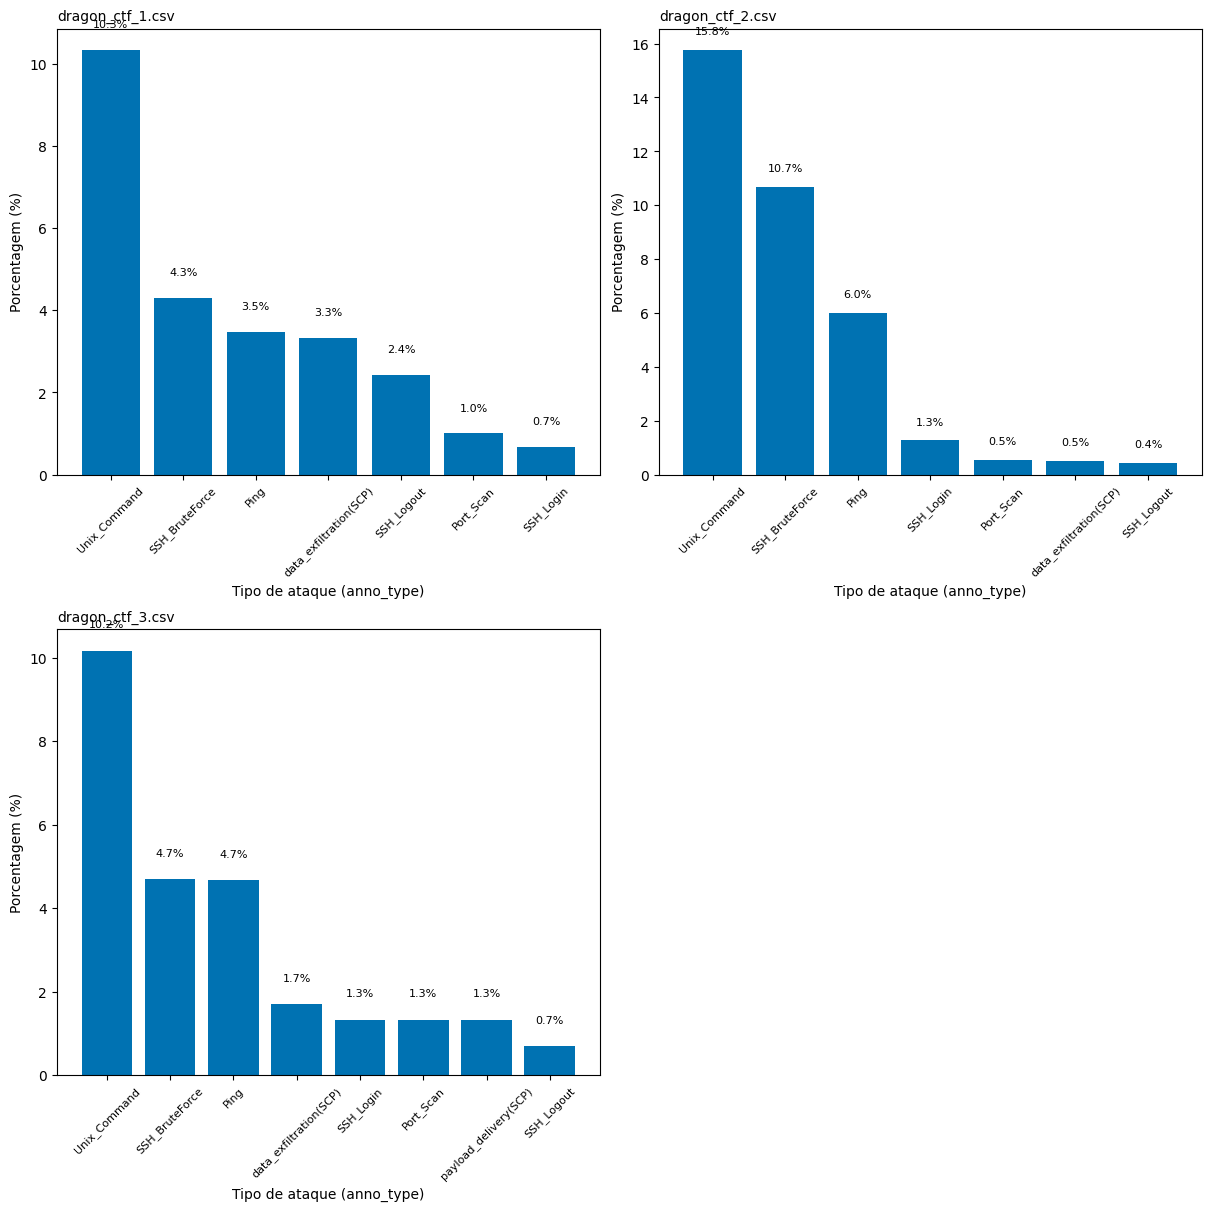

In [42]:
files = sorted(f for f in DRAGON_CTFS_PATH.glob("dragon_ctf_*.csv") if "_legend" not in f.name.lower())

n = len(files)
cols = 2
rows = math.ceil(n / cols)

fig = plt.figure(figsize=(12, 6 * rows), constrained_layout=True)
gs = fig.add_gridspec(rows, cols)

for i, f in enumerate(files):
    r, c = divmod(i, cols)
    ax = fig.add_subplot(gs[r, c])
    print(f"Processando {f.name}...")

    df = pd.read_csv(f)
    if "anno_type" not in df.columns:
        ax.text(0.5, 0.5, f"{f.name}\n(coluna 'anno_type' ausente)",
                ha="center", va="center", fontsize=10)
        continue

    counts = df["anno_type"].value_counts()
    total = counts.sum()
    perc = (counts / total) * 100
    perc_no_normal = perc.drop(labels=["Normal"], errors="ignore")

    bars = ax.bar(perc_no_normal.index, perc_no_normal.values, color="#0072B2")
    ax.set_title(f"{f.name}", loc="left", fontsize=10)
    ax.set_ylabel("Porcentagem (%)")
    ax.set_xlabel("Tipo de ataque (anno_type)")
    ax.tick_params(axis="x", rotation=45, labelsize=8)

    for bar, pct in zip(bars, perc_no_normal.values):
        ax.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height() + 0.5,
            f"{pct:.1f}%",
            ha="center", va="bottom", fontsize=8
        )

if n % cols != 0:
    for j in range(n, rows * cols):
        fig.add_subplot(gs[j // cols, j % cols]).axis("off")


plt.show()


In [39]:
results = []

for csv_file in sorted(DRAGON_CTFS_PATH.glob("*.csv")):
    if "_legend" in csv_file.name.lower():
        continue

    try:
        df = pd.read_csv(csv_file)
        if "Time" not in df.columns:
            continue

        start = pd.to_timedelta(df["Time"].min(), unit="s")
        end = pd.to_timedelta(df["Time"].max(), unit="s")
        duration = (end - start)

        results.append({
            "Arquivo": csv_file.name,
            "Tamanho (MB)": round(csv_file.stat().st_size / (1024 ** 2), 2),
            "Início": str(start),
            "Fim": str(end),
            "Duração (h)": round(duration.total_seconds() / 3600, 2)
        })
    except Exception as e:
        print(f"Erro ao processar {csv_file.name}: {e}")

df_summary = pd.DataFrame(results)
print(df_summary)


            Arquivo  Tamanho (MB)           Início                        Fim  \
0  dragon_ctf_1.csv        871.35  0 days 00:00:00  0 days 00:04:59.999989760   
1  dragon_ctf_2.csv        869.35  0 days 00:00:00  0 days 00:04:59.999989760   
2  dragon_ctf_3.csv        868.47  0 days 00:00:00  0 days 00:04:59.999989760   

   Duração (h)  
0         0.08  
1         0.08  
2         0.08  


dragon_ctf_1.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:04:59.999989760 (duration: 0 days 00:04:59.999989760)


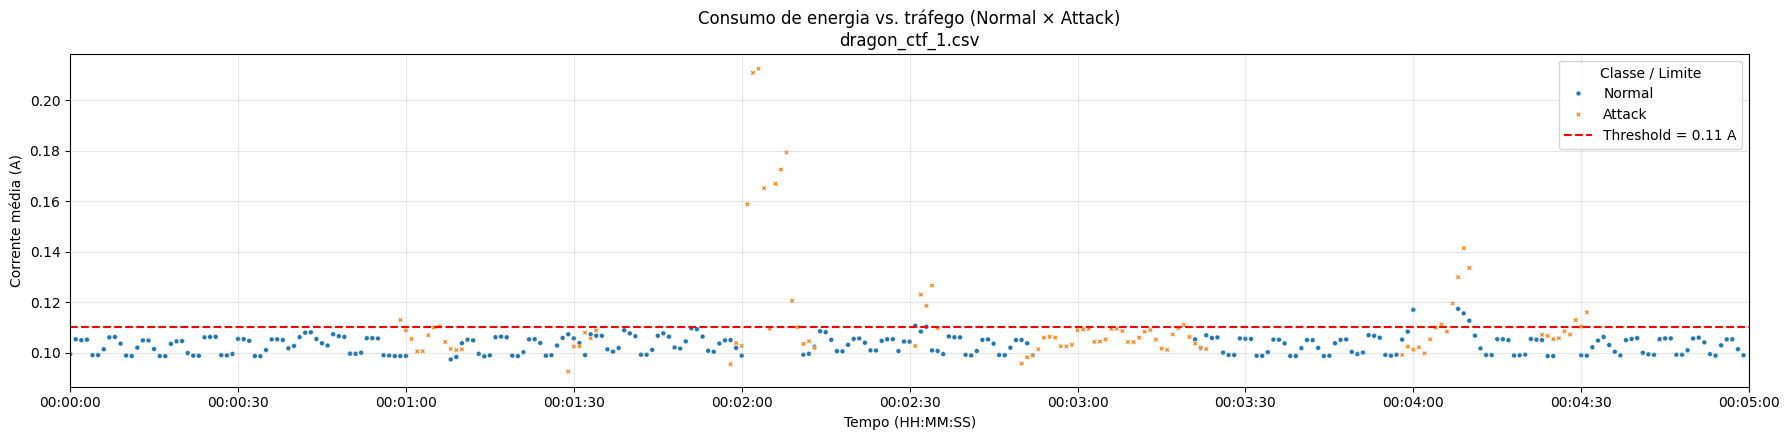

dragon_ctf_2.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:04:59.999989760 (duration: 0 days 00:04:59.999989760)


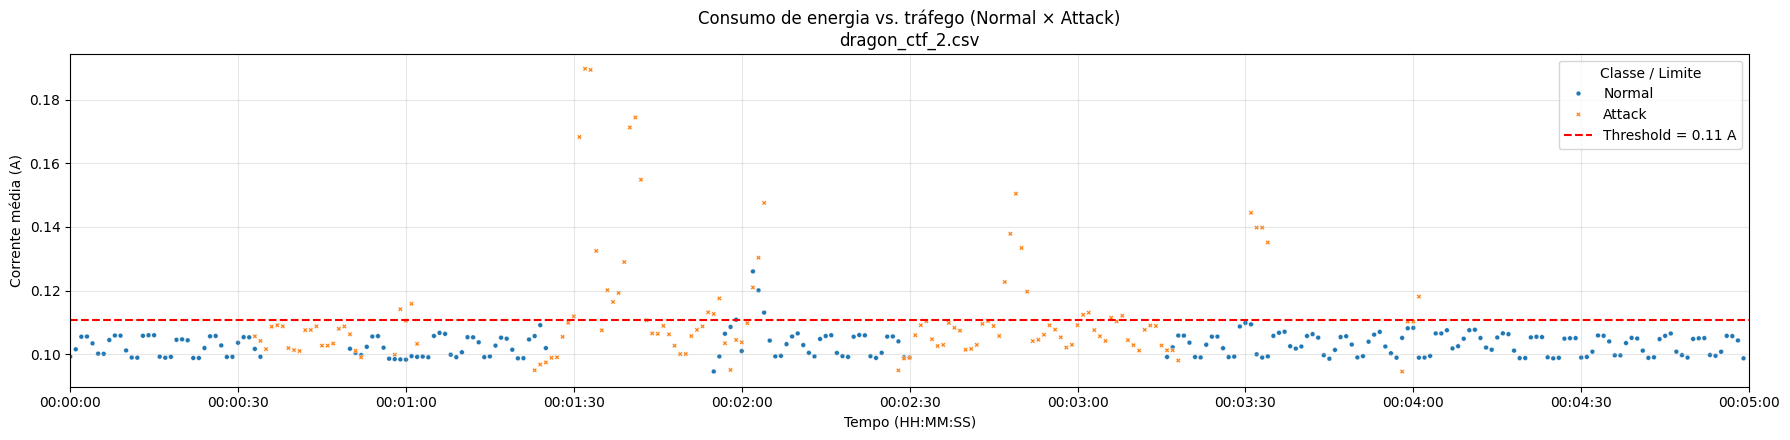

dragon_ctf_3.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:04:59.999989760 (duration: 0 days 00:04:59.999989760)


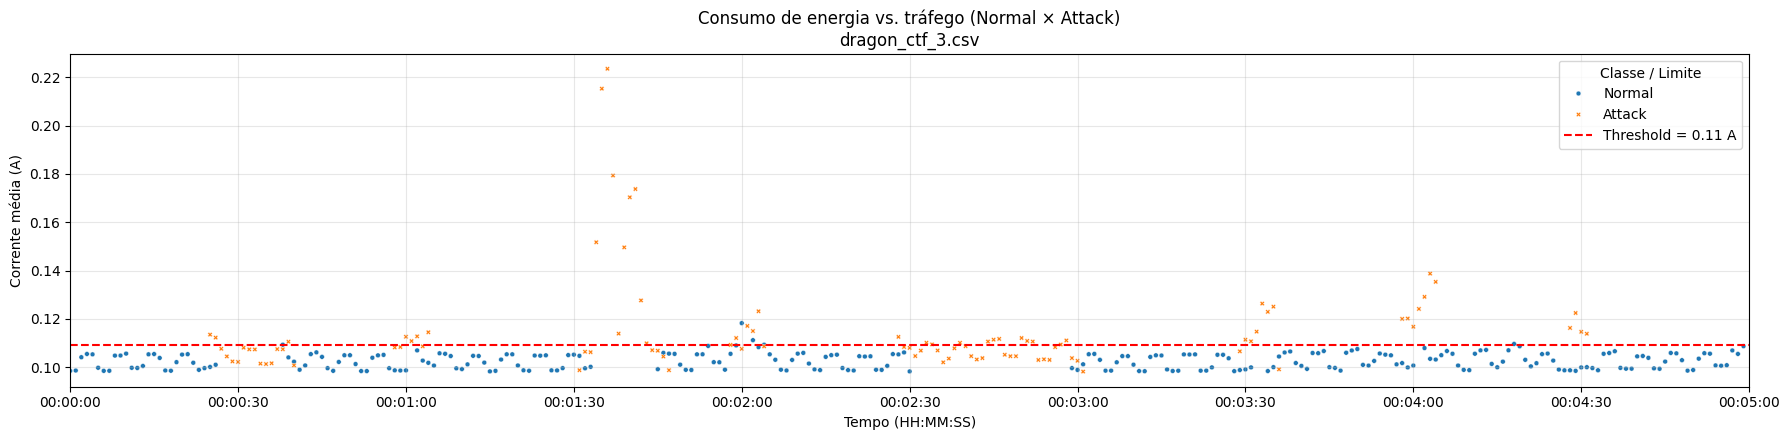

In [ ]:
START_DATE = pd.to_datetime("2012-02-29 00:00:00")

for csv_file in sorted(DRAGON_CTFS_PATH.glob("*.csv")):
    if "_legend" in csv_file.name.lower():
        continue

    df = pd.read_csv(csv_file)

    if "Time" not in df.columns:
        continue

    start_td = pd.to_timedelta(df["Time"].min(), unit="s")
    end_td = pd.to_timedelta(df["Time"].max(), unit="s")
    duration_td = end_td - start_td

    print(f"{csv_file.name} — Starts at {start_td} and ends at {end_td} (duration: {duration_td})")

    df = df.set_index("Time")
    df["Datetime"] = pd.to_timedelta(df.index, unit="s") + START_DATE
    df = df.set_index("Datetime")

    for col in ["anno_string", "anno_type", "anno_specific"]:
        if col not in df.columns:
            df[col] = "Normal"

    df["is_attack"] = ~(
        (df["anno_string"].astype(str).str.lower() == "normal")
        & (df["anno_type"].astype(str).str.lower() == "normal")
        & (df["anno_specific"].astype(str).str.lower() == "normal")
    )

    df_sec = (
        df[["Current", "is_attack"]]
        .groupby("is_attack")["Current"]
        .resample("1s")
        .mean()
        .rename("Corrente (A)")
        .reset_index()
    )

    df_sec["Corrente (A)"] = (
        df_sec.groupby("is_attack")["Corrente (A)"]
        .transform(lambda s: s.rolling(3, min_periods=1, center=True).mean())
    )
    df_sec["classe"] = df_sec["is_attack"].map({False: "Normal", True: "Attack"})

    fig, ax = plt.subplots(figsize=(18, 4.5))
    sns.scatterplot(
        data=df_sec,
        x="Datetime",
        y="Corrente (A)",
        hue="classe",
        style="classe",
        s=12,
        ax=ax
    )

    xmin = df.index.min().floor("s")
    xmax = df.index.max().ceil("s")
    ax.set_xlim(xmin, xmax)

    ax.xaxis.set_major_locator(mdates.SecondLocator(interval=30))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))

    ax.set_title(f"Consumo de energia vs. tráfego (Normal × Attack)\n{csv_file.name}")
    ax.set_xlabel("Tempo (HH:MM:SS)")
    ax.set_ylabel("Corrente média (A)")
    ax.grid(True, alpha=0.3)

    threshold = df_sec.loc[df_sec["classe"] == "Normal", "Corrente (A)"].mean() \
             + 2 * df_sec.loc[df_sec["classe"] == "Normal", "Corrente (A)"].std()

    ax.axhline(y=threshold, color="red", linestyle="--", label=f"Threshold = {threshold:.2f} A")
    ax.legend(title="Classe / Limite")

    plt.tight_layout()
    plt.show()


# ============================================================
# DRAGON_DOS_LARGE e PI_DOS_LARGE
# ============================================================


In [27]:
DATASETS = {
    "Dragon": Path("dragon_pi/dragon/dragon_dos_large/dragon_synflood.csv"),
    "Pi": Path("dragon_pi/pi/pi_dos_large/pi_synflood.csv")
}

for nome, path in DATASETS.items():
    print(f"\n=== {nome.upper()} ===")
    dataset = pd.read_csv(path, index_col=0)

    not_normal = dataset[
        (dataset["anno_string"] != "Normal") |
        (dataset["anno_type"] != "Normal") |
        (dataset["anno_specific"] != "Normal")
    ]

    print("Dimensões do conjunto original:", dataset.shape)
    print("Linhas com anomalias:", not_normal.shape)
    print("\nTipos de valores diferentes de 'Normal':")
    print(not_normal[["anno_string", "anno_type", "anno_specific"]].drop_duplicates())

    print("\nAmostra de ataques/anomalias:")
    display(not_normal.head(10))



=== DRAGON ===
Dimensões do conjunto original: (8789063, 5)
Linhas com anomalias: (2963860, 5)

Tipos de valores diferentes de 'Normal':
        anno_string anno_type anno_specific
3012687     Anomaly       DOS      SYNFlood

Amostra de ataques/anomalias:


Time  Current anno_string anno_type anno_specific
3012687 61.699830 0.093879     Anomaly       DOS      SYNFlood
3012688 61.699850 0.093673     Anomaly       DOS      SYNFlood
3012689 61.699871 0.093526     Anomaly       DOS      SYNFlood
3012690 61.699891 0.093379     Anomaly       DOS      SYNFlood
3012691 61.699912 0.093203     Anomaly       DOS      SYNFlood
3012692 61.699932 0.093114     Anomaly       DOS      SYNFlood
3012693 61.699953 0.093085     Anomaly       DOS      SYNFlood
3012694 61.699973 0.093085     Anomaly       DOS      SYNFlood
3012695 61.699994 0.093055     Anomaly       DOS      SYNFlood
3012696 61.700014 0.092997     Anomaly       DOS      SYNFlood


=== PI ===
Dimensões do conjunto original: (8789063, 5)
Linhas com anomalias: (3549795, 5)

Tipos de valores diferentes de 'Normal':
        anno_string anno_type     anno_specific
2929680     Anomaly       DOS          SYNFlood
3369132     Anomaly       DOS  SYNFlood(Broken)

Amostra de ataques/anomalias:


Time  Current anno_string anno_type anno_specific
2929680 59.999846 0.287758     Anomaly       DOS      SYNFlood
2929681 59.999867 0.287376     Anomaly       DOS      SYNFlood
2929682 59.999887 0.286758     Anomaly       DOS      SYNFlood
2929683 59.999908 0.285817     Anomaly       DOS      SYNFlood
2929684 59.999928 0.284729     Anomaly       DOS      SYNFlood
2929685 59.999949 0.283758     Anomaly       DOS      SYNFlood
2929686 59.999969 0.283052     Anomaly       DOS      SYNFlood
2929687 59.999990 0.282934     Anomaly       DOS      SYNFlood
2929688 60.000010 0.283346     Anomaly       DOS      SYNFlood
2929689 60.000031 0.284140     Anomaly       DOS      SYNFlood

In [29]:
pd.set_option("display.float_format", lambda x: f"{x:.6f}")

def rms(x: pd.Series) -> float:
    return float(np.sqrt(np.mean(np.square(x)))) if len(x) > 0 else np.nan

def stats_from_series(s: pd.Series) -> dict:
    return {
        "mean_current": float(s.mean()),
        "std_current": float(s.std(ddof=0)),
        "rms_current": rms(s),
        "max_current": float(s.max()),
        "min_current": float(s.min()),
        "amp_current": float(s.max() - s.min())
    }

all_stats = []

for label, csv_path in DATASETS.items():
    print(f"\nProcessando {label}: {csv_path}")
    try:
        df = pd.read_csv(csv_path, usecols=["Time", "Current"])
    except Exception as e:
        print(f"[ERRO] Falha ao ler {csv_path.name}: {e}")
        continue

    df["Current"] = pd.to_numeric(df["Current"], errors="coerce")
    df = df.dropna(subset=["Current"])
    df = df[np.isfinite(df["Current"])]
    df = df[df["Current"].between(0, 5)]

    if df.empty:
        print(f"[AVISO] {csv_path.name} ficou vazio após limpeza.")
        continue

    s = df["Current"]
    stats = stats_from_series(s)
    stats["std_current"] = float(np.std(s, ddof=0))
    stats["source_file"] = csv_path.name
    all_stats.append(stats)

df_all = pd.DataFrame(all_stats)

print(f"\nArquivos processados: {len(df_all)}")
display(df_all)



Processando Dragon: dragon_pi/dragon/dragon_dos_large/dragon_synflood.csv

Processando Pi: dragon_pi/pi/pi_dos_large/pi_synflood.csv

Arquivos processados: 2


mean_current  std_current  rms_current  max_current  min_current  \
0      0.107035     0.018975     0.108704     0.276879     0.078759   
1      0.303854     0.040546     0.306547     0.721975     0.244810   

   amp_current          source_file  
0     0.198120  dragon_synflood.csv  
1     0.477164      pi_synflood.csv

In [45]:
DATASETS = {
    "Dragon": Path("dragon_pi/dragon/dragon_dos_large"),
    "Pi": Path("dragon_pi/pi/pi_dos_large")
}

for nome, pasta in DATASETS.items():
    print(f"\n=== {nome.upper()} ===")
    results = []

    for csv_file in sorted(pasta.glob("*.csv")):
        if "_legend" in csv_file.name.lower():
            continue

        try:
            df = pd.read_csv(csv_file)
            if "Time" not in df.columns:
                continue

            start = pd.to_timedelta(df["Time"].min(), unit="s")
            end = pd.to_timedelta(df["Time"].max(), unit="s")
            duration = end - start

            results.append({
                "Arquivo": csv_file.name,
                "Tamanho (MB)": round(csv_file.stat().st_size / (1024 ** 2), 2),
                "Início": str(start),
                "Fim": str(end),
                "Duração (h)": round(duration.total_seconds() / 3600, 2)
            })
        except Exception as e:
            print(f"Erro ao processar {csv_file.name}: {e}")

    if results:
        df_summary = pd.DataFrame(results)
        display(df_summary)
    else:
        print("Nenhum arquivo CSV válido encontrado nessa pasta.")



=== DRAGON ===


Arquivo  Tamanho (MB)           Início  \
0  dragon_synflood.csv        497.97  0 days 00:00:00   

                         Fim  Duração (h)  
0  0 days 00:02:59.999989760         0.05


=== PI ===


Arquivo  Tamanho (MB)           Início                        Fim  \
0  pi_synflood.csv        517.43  0 days 00:00:00  0 days 00:02:59.999989760   

   Duração (h)  
0         0.05

dragon_synflood.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:02:59.999989760 (duration: 0 days 00:02:59.999989760)


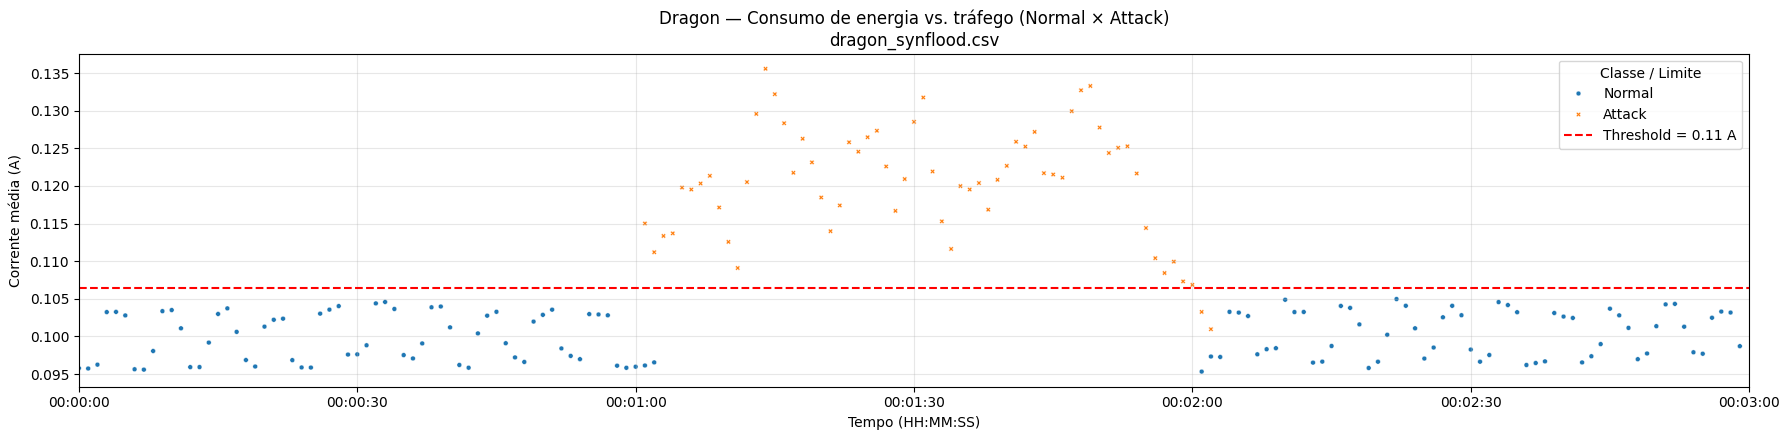

pi_synflood.csv — Starts at 0 days 00:00:00 and ends at 0 days 00:02:59.999989760 (duration: 0 days 00:02:59.999989760)


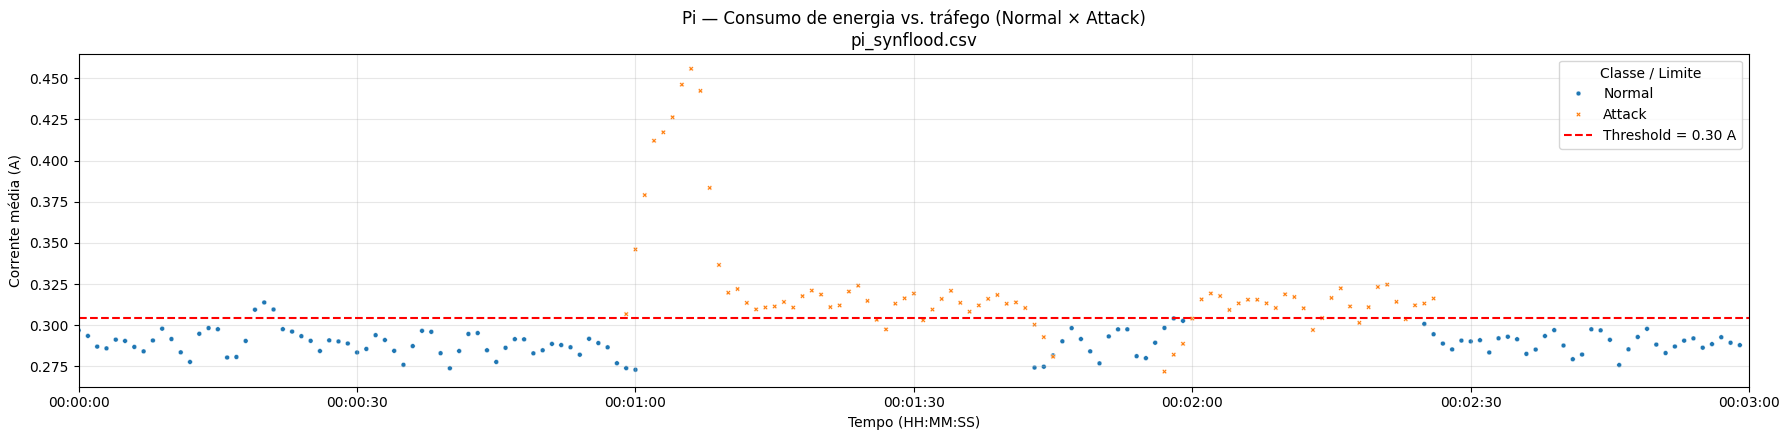

In [ ]:
START_DATE = pd.to_datetime("2012-02-29 00:00:00")

DATASETS = {
    "Dragon": Path("dragon_pi/dragon/dragon_dos_large"),
    "Pi": Path("dragon_pi/pi/pi_dos_large")
}

for nome, pasta in DATASETS.items():
    for csv_file in sorted(pasta.glob("*.csv")):
        if "_legend" in csv_file.name.lower():
            continue

        df = pd.read_csv(csv_file)

        if "Time" not in df.columns or "Current" not in df.columns:
            continue

        start_td = pd.to_timedelta(df["Time"].min(), unit="s")
        end_td = pd.to_timedelta(df["Time"].max(), unit="s")
        duration_td = end_td - start_td

        print(f"{csv_file.name} — Starts at {start_td} and ends at {end_td} (duration: {duration_td})")

        df["Datetime"] = pd.to_timedelta(df["Time"], unit="s") + START_DATE
        df = df.set_index("Datetime")

        for col in ["anno_string", "anno_type", "anno_specific"]:
            if col not in df.columns:
                df[col] = "Normal"

        df["is_attack"] = ~(
            (df["anno_string"].astype(str).str.lower() == "normal")
            & (df["anno_type"].astype(str).str.lower() == "normal")
            & (df["anno_specific"].astype(str).str.lower() == "normal")
        )

        df_sec = (
            df[["Current", "is_attack"]]
            .groupby("is_attack")["Current"]
            .resample("1s")
            .mean()
            .rename("Corrente (A)")
            .reset_index()
        )

        df_sec["Corrente (A)"] = (
            df_sec.groupby("is_attack")["Corrente (A)"]
            .transform(lambda s: s.rolling(3, min_periods=1, center=True).mean())
        )

        df_sec["classe"] = df_sec["is_attack"].map({False: "Normal", True: "Attack"})

        fig, ax = plt.subplots(figsize=(18, 4.5))
        sns.scatterplot(
            data=df_sec,
            x="Datetime",
            y="Corrente (A)",
            hue="classe",
            style="classe",
            s=12,
            ax=ax
        )

        xmin = df.index.min().floor("s")
        xmax = df.index.max().ceil("s")
        ax.set_xlim(xmin, xmax)
        ax.xaxis.set_major_locator(mdates.SecondLocator(interval=30))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))

        ax.set_title(f"{nome} — Consumo de energia vs. tráfego (Normal × Attack)\n{csv_file.name}")
        ax.set_xlabel("Tempo (HH:MM:SS)")
        ax.set_ylabel("Corrente média (A)")
        ax.grid(True, alpha=0.3)

        threshold = df_sec.loc[df_sec["classe"] == "Normal", "Corrente (A)"].mean() \
                  + 2 * df_sec.loc[df_sec["classe"] == "Normal", "Corrente (A)"].std()

        ax.axhline(y=threshold, color="red", linestyle="--", label=f"Threshold = {threshold:.2f} A")
        ax.legend(title="Classe / Limite")

        plt.tight_layout()
        plt.show()


## Exploratory Threshold-Based Detection

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

# ========================
# CONFIGURAÇÕES
# ========================
K = 2.0
CHUNKSIZE = 100000  # menor = menos RAM
LIMIT_FILES = 4     # limite de arquivos normais lidos (use None para todos)

# ========================
# FUNÇÕES
# ========================
def find_columns(file):
    """Detecta automaticamente colunas de corrente e rótulo."""
    sample = pd.read_csv(file, nrows=5)
    cols = [c.lower() for c in sample.columns]
    if "current" in cols:
        corr_col = sample.columns[cols.index("current")]
    else:
        raise ValueError(f"Nenhuma coluna de corrente encontrada em {file.name}")
    if "anno_string" in cols:
        label_col = sample.columns[cols.index("anno_string")]
    elif "anno_type" in cols:
        label_col = sample.columns[cols.index("anno_type")]
    else:
        raise ValueError(f"Nenhuma coluna de rótulo encontrada em {file.name}")
    return corr_col, label_col


def fast_stats_normal(files):
    """Calcula média e desvio de forma vetorizada e incremental."""
    total_sum, total_sq, total_n = 0.0, 0.0, 0
    for f in tqdm(files, desc="Calculando média/desvio"):
        corr_col, label_col = find_columns(f)
        for chunk in pd.read_csv(f, chunksize=CHUNKSIZE, usecols=[corr_col, label_col]):
            df_norm = chunk[chunk[label_col].astype(str).str.lower().isin(["normal", "norm", "background"])]
            arr = df_norm[corr_col].dropna().to_numpy()
            n = len(arr)
            if n == 0:
                continue
            total_sum += arr.sum()
            total_sq += (arr**2).sum()
            total_n += n
    mean = total_sum / total_n
    variance = total_sq / total_n - mean**2
    return mean, np.sqrt(variance)


def evaluate_fast(files, threshold):
    """Avalia baseline sem armazenar tudo na memória."""
    tp = tn = fp = fn = 0
    for f in tqdm(files, desc="Avaliando"):
        corr_col, label_col = find_columns(f)
        for chunk in pd.read_csv(f, chunksize=CHUNKSIZE, usecols=[corr_col, label_col]):
            chunk = chunk.dropna(subset=[corr_col])
            y_true = chunk[label_col].astype(str).str.lower().isin(
                ["attack", "bruteforce", "dos", "ctf", "portscan"]
            )
            y_pred = chunk[corr_col] > threshold
            tp += np.sum(y_true & y_pred)
            tn += np.sum(~y_true & ~y_pred)
            fp += np.sum(~y_true & y_pred)
            fn += np.sum(y_true & ~y_pred)
    cm = np.array([[tn, fp], [fn, tp]])
    prec = tp / (tp + fp + 1e-9)
    rec = tp / (tp + fn + 1e-9)
    f1 = 2 * prec * rec / (prec + rec + 1e-9)
    return cm, prec, rec, f1


def list_csvs(path):
    return [f for f in path.glob("*.csv") if "legend" not in f.name.lower()]


# ========================
# ARQUIVOS NORMAIS
# ========================
normal_files = [
    p for p in Path("dragon_pi").rglob("*.csv")
    if ("norm" in p.name.lower() or "normal" in p.name.lower())
    and "legend" not in p.name.lower()
]
if not normal_files:
    raise SystemExit("Nenhum arquivo normal encontrado.")
if LIMIT_FILES:
    normal_files = normal_files[:LIMIT_FILES]

mu, sigma = fast_stats_normal(normal_files)
threshold = mu + K * sigma
print(f"\nBaseline: μ={mu:.6f}, σ={sigma:.6f}, threshold={threshold:.6f}")

# ========================
# AVALIAÇÃO
# ========================
attack_groups = {
    "pi_bruteforce": list_csvs(Path("dragon_pi/pi/pi_bruteforce_large")),
    "dragon_bruteforce": list_csvs(Path("dragon_pi/dragon/dragon_bruteforce_large")),
}

for name, files in attack_groups.items():
    if not files:
        continue
    files = files[:LIMIT_FILES]  # limita para não travar
    print(f"\n=== {name.upper()} ===")
    cm, prec, rec, f1 = evaluate_fast(files, threshold)
    print("Confusion matrix:\n", cm)
    print(f"Precision={prec:.3f} Recall={rec:.3f} F1={f1:.3f}")

print("\nProcessamento concluído com segurança.")


Calculando média/desvio:   0%|          | 0/4 [00:00<?, ?it/s]

Calculando média/desvio: 100%|██████████| 4/4 [02:04<00:00, 31.07s/it]



Baseline: μ=0.176770, σ=0.096958, threshold=0.370687

=== PI_BRUTEFORCE ===


Avaliando: 100%|██████████| 4/4 [00:52<00:00, 13.23s/it]


Confusion matrix:
 [[50166729  8427023]
 [       0        0]]
Precision=0.000 Recall=0.000 F1=0.000

=== DRAGON_BRUTEFORCE ===


Avaliando: 100%|██████████| 4/4 [00:41<00:00, 10.37s/it]

Confusion matrix:
 [[49804429      259]
 [       0        0]]
Precision=0.000 Recall=0.000 F1=0.000

Processamento concluído com segurança.
